# Project Prep by Bezborodov

## Dataset - Animals-10

## [Github](https://github.com/vladyslavBrothervinn/DL4CV)


## Dataset Loading and Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image
from PIL import Image

from torch.utils.data import DataLoader, Dataset, random_split

import random
import time
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn.model_selection import ParameterGrid

%matplotlib inline

In [2]:
os.getcwd()

'C:\\Users\\Cyberpower\\PycharmProjects\\modelTraining\\DL4CV\\2025\\Practices'

In [3]:
data_dir = "../Datasets/raw-img"

In [5]:
def get_aspect_ratio(width, height):
    return width / height if height != 0 else 0

def get_raw_size(width, height):
    return width * height

def get_average_brightness(image):
    return np.mean(image)

In [6]:
def load_data(data_path):
    data = []

    for label in os.listdir(data_path):
        label_dir = os.path.join(data_path, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file)
                file_extension = os.path.splitext(file_path)[1].lower()
                if file_path.endswith(('jpg', 'jpeg', 'png')):
                    with PIL.Image.open(file_path) as img:
                        width, height = img.size
                        img = np.array(img).reshape(-1)
                        average_brightness = get_average_brightness(img)
                        aspect_ratio = get_aspect_ratio(width, height)
                        raw_size = get_raw_size(width, height)

                        data.append([file, width, height, label, average_brightness, file_extension, aspect_ratio, raw_size])
                    
    return data

In [7]:
df = pd.DataFrame(
    load_data(data_dir), 
    columns=['Filename', 'Width', 'Height', 'Label', 'AverageBrightness', 'Extension', 'Aspect_Ratio', 'Raw_Size']
)

In [8]:
df.to_csv('../Datasets/animal-10_metadata.csv', index=False)

In [9]:
df.head()

Filename  Width  Height  \
0  e030b20928e90021d85a5854ee454296eb70e3c818b413...    426     640   
1  e030b20929e90021d85a5854ee454296eb70e3c818b413...    640     457   
2  e030b2092be90021d85a5854ee454296eb70e3c818b413...    426     640   
3  e030b2092ce90021d85a5854ee454296eb70e3c818b413...    425     640   
4  e030b2092de90021d85a5854ee454296eb70e3c818b413...    426     640   

       Label  AverageBrightness Extension  Aspect_Ratio  Raw_Size  
0  butterfly         147.072210      .jpg      0.665625    272640  
1  butterfly         144.815149      .jpg      1.400438    292480  
2  butterfly         173.383853      .jpg      0.665625    272640  
3  butterfly         128.923267      .jpg      0.664062    272000  
4  butterfly         160.853471      .jpg      0.665625    272640

In [10]:
df.describe()

Width        Height  AverageBrightness  Aspect_Ratio  \
count  26179.000000  26179.000000       26179.000000  26179.000000   
mean     320.038810    252.630162         121.628519      1.311385   
std      196.935326    148.403298          36.164577      0.311234   
min       60.000000     57.000000           3.004002      0.293333   
25%      300.000000    200.000000          99.050946      1.136364   
50%      300.000000    225.000000         117.596617      1.333333   
75%      300.000000    300.000000         138.670773      1.500000   
max     6720.000000   6000.000000         250.052742      4.225352   

           Raw_Size  
count  2.617900e+04  
mean   1.064363e+05  
std    6.528056e+05  
min    3.420000e+03  
25%    6.000000e+04  
50%    6.750000e+04  
75%    7.410000e+04  
max    3.010560e+07

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(df['Width'], bins=100, color='blue', alpha=0.7)
axes[0].set_title('Image Height Distribution')
axes[0].set_xlabel('Height')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['Height'], bins=100, color='orange', alpha=0.7)
axes[1].set_title('Image Width Distribution')
axes[1].set_xlabel('Width')
axes[1].set_ylabel('Frequency')

plt.show()

In [12]:
df['AverageBrightness'].plot(kind='hist', bins=100, title='Average brightness');

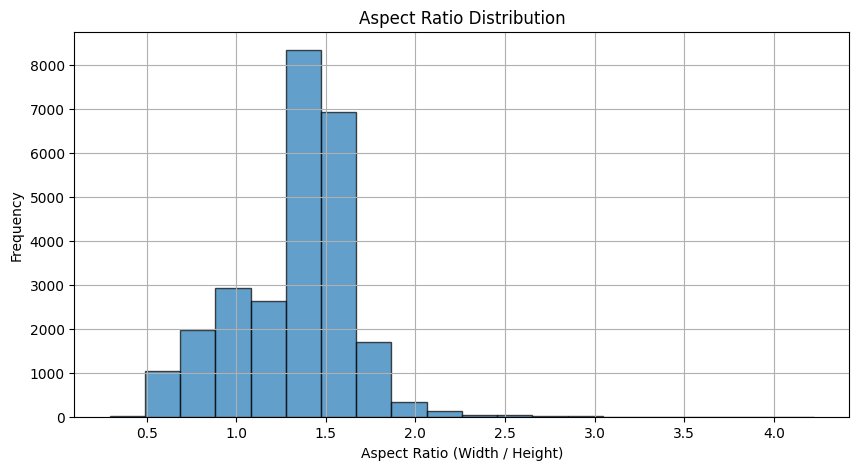

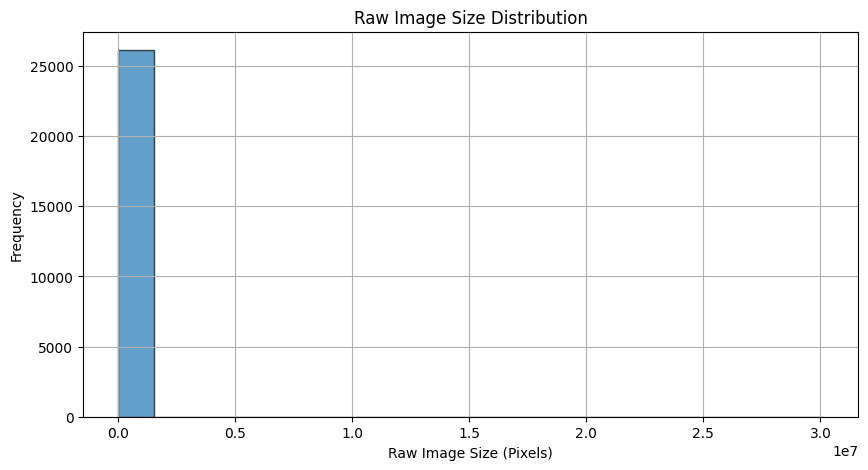

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(df['Aspect_Ratio'], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Frequency')
plt.title('Aspect Ratio Distribution')
plt.grid(True)
plt.show()

# Plot Raw Size Distribution
plt.figure(figsize=(10, 5))
plt.hist(df['Raw_Size'], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Raw Image Size (Pixels)')
plt.ylabel('Frequency')
plt.title('Raw Image Size Distribution')
plt.grid(True)
plt.show()

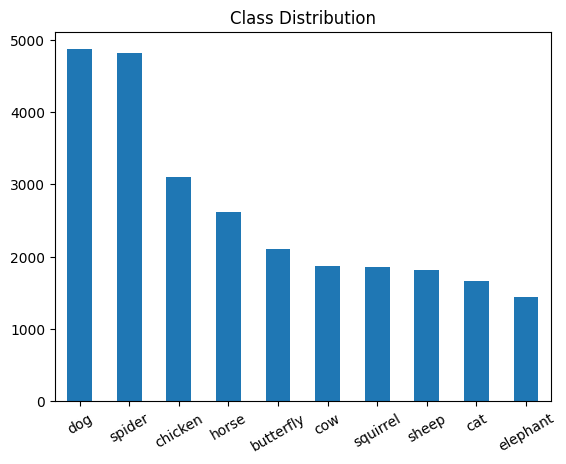

In [14]:
df['Label'].value_counts().plot(kind='bar', title='Class Distribution');
plt.xticks(rotation=30);

Dataset is not equally distributed by classes


two potential solutions:


- either reduce dog and spider classes images
- extend other classes that are < 2000 images

In [15]:
print("Amont of classes : ",len(df["Label"].unique()))

Amont of classes :  10


In [16]:
df['Label'].value_counts()

dog          4863
spider       4821
chicken      3098
horse        2623
butterfly    2112
cow          1866
squirrel     1862
sheep        1820
cat          1668
elephant     1446
Name: Label, dtype: int64

## Dataset

In [4]:
# os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device, dtype=torch.int64)


In [5]:
class AnimalDataset(Dataset):
    def __init__(self, data_dir, split="train", transform=None, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1):
        
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir)) 
        self.images = []
        self.labels = []

        all_data = []  # Store all images before splitting

        for label_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            if os.path.isdir(class_dir):
                image_files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) 
                               if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_data.extend([(img, label_idx) for img in image_files])  

        random.shuffle(all_data)
        
        # Compute split indices
        total = len(all_data)
        train_end = int(total * train_ratio)
        valid_end = train_end + int(total * valid_ratio)

        # Split dataset
        if split == "train":
            data_subset = all_data[:train_end]
        elif split == "valid":
            data_subset = all_data[train_end:valid_end]
        elif split == "test":
            data_subset = all_data[valid_end:]
        else:
            raise ValueError("split must be 'train', 'valid', or 'test'")

        # Store images and labels
        self.images, self.labels = zip(*data_subset) if data_subset else ([], [])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]

        # Open image using PIL
        image = Image.open(image_path).convert("RGB")  # Convert to RGB

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [6]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

In [7]:
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
train_dataset = AnimalDataset(data_dir, split="train", transform=transform_train)
valid_dataset = AnimalDataset(data_dir, split="valid", transform=transform_train)
test_dataset = AnimalDataset(data_dir, split="test", transform=transform_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

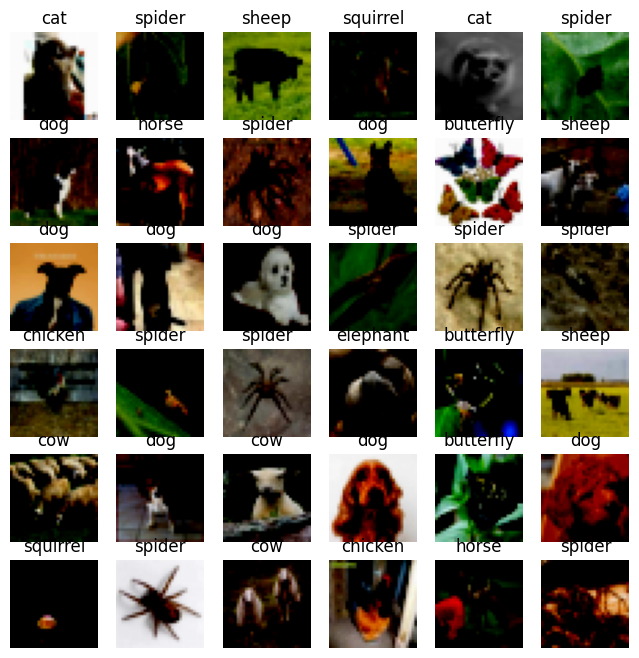

In [9]:
labels_map = {
    0: "butterfly",
    1: "cat",
    2: "chicken",
    3: "sheep",
    4: "dog",
    5: "elephant",
    6: "horse",
    7: "cow",
    8: "spider",
    9: "squirrel",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 6,6
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    
    img = img.permute(1, 2, 0)  # Convert (C, H, W) -> (H, W, C)
    
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label.item()]) 
    plt.axis("off")
    plt.imshow(img) 

plt.show()


In [10]:
# train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=16, num_workers=2, pin_memory=True)
# valid_loader = DataLoader(dataset=valid_dataset, shuffle=True, batch_size=64, num_workers=2, pin_memory=True)
# test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=64, num_workers=2, pin_memory=True)

Планування на наступний етап:
- Визначте метрики, за якими будете оцінювати ефективність моделі;
- Заплануйте архітектуру нейронної мережі:
- Кількість згорткових шарів;
- Активації;
- Кількість повноз’язних шарів;
- Оптимізатор;
- Dropout.



## Model Architecture

In [11]:
class Model(nn.Module):
    
    
    def __init__(self, act_fn):
        super().__init__()
        self.act_fn = act_fn
        
        # Original input : 224x224x3
        self.conv1 = nn.Conv2d(3, 6, kernel_size= 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size= 5) 
        self.fc1 = nn.Linear(16*6*6,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,10)
        self.dropout = nn.Dropout(p=0.5)

    
    def forward(self, x):
        # print(f"Shape before 1st avg pooling : {x.shape}")  # Debugging output
        x = F.max_pool2d(self.act_fn(self.conv1(x)), kernel_size = 2, stride = 2)
        # print(f"Shape after 1st avg pooling : {x.shape}")  # Debugging output
        x = F.max_pool2d(self.act_fn(self.conv2(x)), kernel_size = 2, stride = 2)  
        # print(f"Shape after 2nd avg pooling : {x.shape}")  # Debugging output

        # print(f"Shape before flattening: {x.shape}")  # Debugging output
        x = x.view(x.size(0), -1)  # Flatten the output
        # print(f"Shape after flattening: {x.shape}")  # Debugging output
        x = self.act_fn(self.fc1(x))
        x = self.dropout(x)
        x = self.act_fn(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x 


In [12]:
def loss(model, loss_func, X, y, optimizer=None):
    loss_ = loss_func(model(X), y)
    if optimizer is not None:
      loss_.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss_.item(), len(X)

In [13]:
def validate(model, loss_func, X, y):
    output = model(X)
    loss_ = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return loss_.item(), torch.sum(correct).item(), len(X)

In [14]:
def fit(epochs, model, idx, loss_func, optimizer, train_loader, valid_loader, patience=10):
    graphic_losses = []

    wait = 0
    valid_loss_min = np.Inf

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

    for epoch in tqdm(range(epochs)):

        model.train()

        losses = []
        for X, y  in train_loader:
          losses.append(loss(model, loss_func, X, y, optimizer))

        losses, nums = zip(*losses)
        train_loss = sum(np.multiply(losses, nums)) / sum(nums)

        model.eval()

        with torch.no_grad():

            losses = []
            for X, y in valid_loader:
              losses.append(validate(model, loss_func, X, y))

            losses, corrects, nums = zip(*losses)
            valid_loss = sum(np.multiply(losses, nums)) / sum(nums)
            valid_accuracy = sum(corrects) / sum(nums) * 100

            print(f"\nepoch: {epoch+1:3}, loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, valid accruacy: {valid_accuracy:.3f}%")

            graphic_losses.append((train_loss, valid_loss, valid_accuracy))

            # Apply Learning Rate Scheduler
            scheduler.step(valid_loss)  # Reduce LR if validation loss stops improving
            
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), f'lab4/models/model_{idx}.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return graphic_losses

    return graphic_losses

In [15]:
def evaluate(model, loss_func, loader):
    model.eval()

    with torch.no_grad():
        validated_batches = []

        for X, y in loader:
          validated_batches.append(validate(model, loss_func, X, y))

        losses, corrects, nums = zip(*validated_batches)
        test_loss = sum(np.multiply(losses, nums)) / sum(nums)
        test_accuracy = sum(corrects) / sum(nums) * 100

    print(f"Test loss: {test_loss:.5f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")
    return test_loss, test_accuracy

In [16]:
def training_plots(losses_arr):
    plt.figure(figsize=(8,6))
    plt.plot([x[2] for x in losses_arr])
    plt.ylabel('Accuracy in %')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[0] for x in losses_arr], label='train loss')
    plt.plot([x[1] for x in losses_arr], label='validation loss')
    plt.legend(loc="upper right")
    plt.ylabel('Losses')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

In [17]:
def train(model, idx, criterion, optimizer, n_epochs, batch_size, saving_model_path):
    
    train_dataset = AnimalDataset(data_dir, split="train", transform=transform_train)
    valid_dataset = AnimalDataset(data_dir, split="valid", transform=transform_train)
    test_dataset = AnimalDataset(data_dir, split="test", transform=transform_test)

    train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=batch_size, shuffle=True), to_device)
    valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=batch_size, shuffle=False), to_device)
    test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=batch_size, shuffle=False), to_device)
    
    print('\nFitting nn model')
    start_time = time.time()

    losses_arr = fit(n_epochs, model, idx, criterion, optimizer, train_loader, valid_loader)
    print(f'Fit time: {time.time() - start_time} s')

    check_point = torch.load(f'lab4/models/model_{idx}.pt', map_location=device)
    model.load_state_dict(check_point)

    test_loss, test_accuracy = evaluate(model, criterion, test_loader)

    if saving_model_path is not None:
        print('Saving model')
        torch.save(model.state_dict(), model_path(saving_model_path))

    training_plots(losses_arr)
    return losses_arr, test_loss, test_accuracy

## Parameters grid

In [18]:
model_path = lambda name: f"lab4/models/animals/{name}.model"
params_grid = {
    "batch_size": [32, 64],
    "lr": [0.001, 0.0001],
    "epochs": [20, 30],
    "activation_fn": [nn.LeakyReLU(), nn.GELU()],
    "optimizer" : [torch.optim.AdamW, torch.optim.Adam, torch.optim.SGD]
}

In [19]:
def grid_search(params_grid):
    param_grid = ParameterGrid(params_grid)
    df = pd.DataFrame(columns=["batch_size", "lr", "epochs", "activation_fn",
                               "optimizer", "losses_arr", "test_loss", "test_accuracy", "model"])

    idx = 0
    for params in param_grid:
        model = Model(act_fn=params["activation_fn"]).to(device)
        
        if params["optimizer"] in [torch.optim.SGD]:
            optimizer = params["optimizer"](model.parameters(), lr=params["lr"], momentum=0.9)
        else:
            optimizer = params["optimizer"](model.parameters(), lr=params["lr"])
        
        criterion = nn.CrossEntropyLoss()
        losses_arr, test_loss, test_accuracy = train(model, idx, criterion, optimizer,
                                                     params["epochs"], params["batch_size"], 'base_model_'+str(idx))

        new_row = {
            "batch_size": params["batch_size"],
            "lr": params["lr"],
            "epochs": params["epochs"],
            "activation_fn": params["activation_fn"],
            "optimizer": params["optimizer"].__name__, 
            "losses_arr": losses_arr,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "model": "model_"+str(idx)
        }
        new_df = pd.DataFrame([new_row])
        df = pd.concat([df, new_df], ignore_index=True)
        
        idx += 1

        df.to_csv('lab4/models/models_results.csv', sep=',')
        print("results were saved to csv")
    return df



Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:19<25:05, 79.26s/it]


epoch:   1, loss: 2.06769, valid loss: 1.83967, valid accruacy: 36.160%
Validation loss decreased (inf --> 1.839668). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:27<21:46, 72.57s/it]


epoch:   2, loss: 1.82868, valid loss: 1.66863, valid accruacy: 40.993%
Validation loss decreased (1.839668 --> 1.668634). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [03:38<20:23, 71.95s/it]


epoch:   3, loss: 1.71109, valid loss: 1.58501, valid accruacy: 44.222%
Validation loss decreased (1.668634 --> 1.585011). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [04:55<19:43, 74.00s/it]


epoch:   4, loss: 1.62667, valid loss: 1.49569, valid accruacy: 48.921%
Validation loss decreased (1.585011 --> 1.495687). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [06:15<19:03, 76.24s/it]


epoch:   5, loss: 1.56073, valid loss: 1.42346, valid accruacy: 49.799%
Validation loss decreased (1.495687 --> 1.423455). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [07:25<17:18, 74.20s/it]


epoch:   6, loss: 1.49198, valid loss: 1.37793, valid accruacy: 51.824%
Validation loss decreased (1.423455 --> 1.377933). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [08:31<15:26, 71.25s/it]


epoch:   7, loss: 1.43696, valid loss: 1.33214, valid accruacy: 54.766%
Validation loss decreased (1.377933 --> 1.332141). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [09:36<13:51, 69.30s/it]


epoch:   8, loss: 1.38570, valid loss: 1.29025, valid accruacy: 55.645%
Validation loss decreased (1.332141 --> 1.290252). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [10:40<12:24, 67.64s/it]


epoch:   9, loss: 1.34002, valid loss: 1.22280, valid accruacy: 57.670%
Validation loss decreased (1.290252 --> 1.222801). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [11:31<10:27, 62.70s/it]


epoch:  10, loss: 1.28912, valid loss: 1.18913, valid accruacy: 60.134%
Validation loss decreased (1.222801 --> 1.189128). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [12:31<09:15, 61.70s/it]


epoch:  11, loss: 1.23786, valid loss: 1.13665, valid accruacy: 61.452%
Validation loss decreased (1.189128 --> 1.136652). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [13:26<07:56, 59.60s/it]


epoch:  12, loss: 1.20918, valid loss: 1.11282, valid accruacy: 63.228%
Validation loss decreased (1.136652 --> 1.112820). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [14:22<06:50, 58.66s/it]


epoch:  13, loss: 1.16530, valid loss: 1.08830, valid accruacy: 63.610%
Validation loss decreased (1.112820 --> 1.088304). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [15:20<05:51, 58.53s/it]


epoch:  14, loss: 1.13481, valid loss: 1.03920, valid accruacy: 65.253%
Validation loss decreased (1.088304 --> 1.039195). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [16:19<04:52, 58.57s/it]


epoch:  15, loss: 1.09169, valid loss: 1.00144, valid accruacy: 67.011%
Validation loss decreased (1.039195 --> 1.001443). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [17:18<03:54, 58.72s/it]


epoch:  16, loss: 1.06595, valid loss: 0.98438, valid accruacy: 67.947%
Validation loss decreased (1.001443 --> 0.984385). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [18:17<02:56, 58.75s/it]


epoch:  17, loss: 1.03780, valid loss: 0.96339, valid accruacy: 68.806%
Validation loss decreased (0.984385 --> 0.963386). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [19:16<01:57, 58.75s/it]


epoch:  18, loss: 0.99422, valid loss: 0.95207, valid accruacy: 69.876%
Validation loss decreased (0.963386 --> 0.952069). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [20:14<00:58, 58.73s/it]


epoch:  19, loss: 0.97679, valid loss: 0.91562, valid accruacy: 71.748%
Validation loss decreased (0.952069 --> 0.915621). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [21:13<00:00, 63.70s/it]



epoch:  20, loss: 0.94990, valid loss: 0.89226, valid accruacy: 71.824%
Validation loss decreased (0.915621 --> 0.892257). Saving model...
Fit time: 1273.9334325790405 s
Test loss: 0.84817	Test accruacy: 72.661%
Saving model


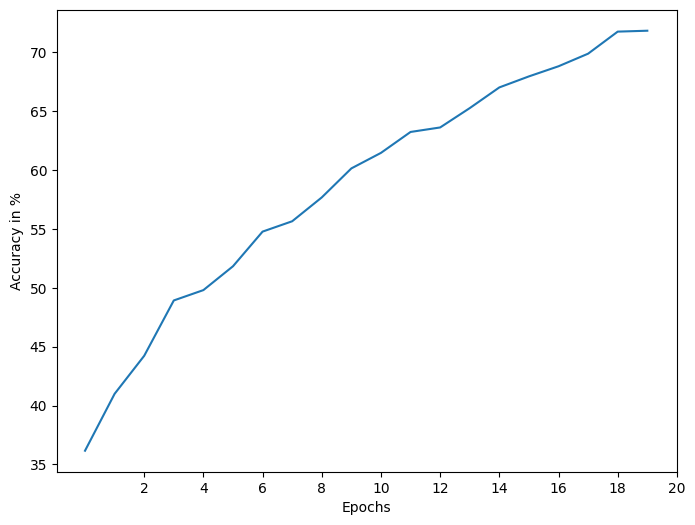

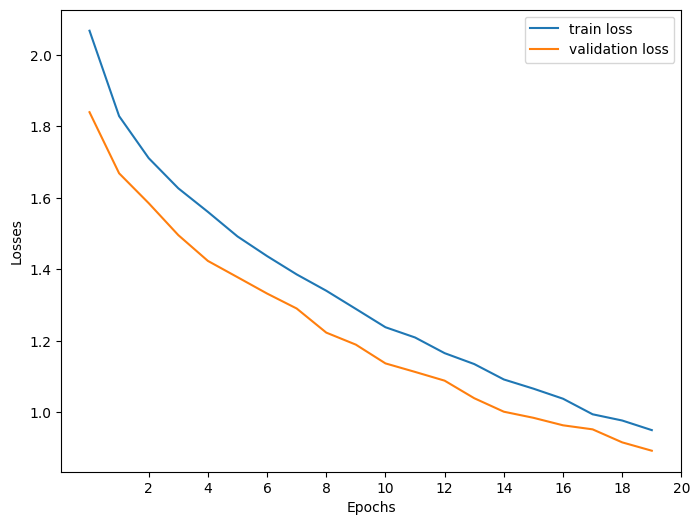

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:55<17:30, 55.27s/it]


epoch:   1, loss: 2.04109, valid loss: 1.86238, valid accruacy: 34.040%
Validation loss decreased (inf --> 1.862382). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:54<17:16, 57.56s/it]


epoch:   2, loss: 1.81676, valid loss: 1.65130, valid accruacy: 41.624%
Validation loss decreased (1.862382 --> 1.651301). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:55<16:42, 58.94s/it]


epoch:   3, loss: 1.68947, valid loss: 1.52333, valid accruacy: 46.361%
Validation loss decreased (1.651301 --> 1.523335). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:53<15:39, 58.72s/it]


epoch:   4, loss: 1.58725, valid loss: 1.42746, valid accruacy: 50.583%
Validation loss decreased (1.523335 --> 1.427459). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:51<14:38, 58.58s/it]


epoch:   5, loss: 1.49667, valid loss: 1.35419, valid accruacy: 53.849%
Validation loss decreased (1.427459 --> 1.354194). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:43<13:05, 56.14s/it]


epoch:   6, loss: 1.43694, valid loss: 1.28253, valid accruacy: 55.511%
Validation loss decreased (1.354194 --> 1.282533). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:34<11:51, 54.70s/it]


epoch:   7, loss: 1.37501, valid loss: 1.26709, valid accruacy: 56.141%
Validation loss decreased (1.282533 --> 1.267092). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:27<10:48, 54.01s/it]


epoch:   8, loss: 1.32866, valid loss: 1.21114, valid accruacy: 58.529%
Validation loss decreased (1.267092 --> 1.211144). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:19<09:47, 53.38s/it]


epoch:   9, loss: 1.26500, valid loss: 1.13461, valid accruacy: 61.051%
Validation loss decreased (1.211144 --> 1.134611). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:10<08:47, 52.79s/it]


epoch:  10, loss: 1.23263, valid loss: 1.11911, valid accruacy: 62.139%
Validation loss decreased (1.134611 --> 1.119114). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:03<07:53, 52.59s/it]


epoch:  11, loss: 1.18056, valid loss: 1.07730, valid accruacy: 63.572%
Validation loss decreased (1.119114 --> 1.077302). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [10:54<06:58, 52.27s/it]


epoch:  12, loss: 1.13815, valid loss: 1.04520, valid accruacy: 65.158%
Validation loss decreased (1.077302 --> 1.045195). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [11:46<06:06, 52.33s/it]


epoch:  13, loss: 1.10494, valid loss: 0.99831, valid accruacy: 66.590%
Validation loss decreased (1.045195 --> 0.998312). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [12:44<05:22, 53.75s/it]


epoch:  14, loss: 1.06160, valid loss: 1.00685, valid accruacy: 66.151%


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [13:44<04:39, 55.85s/it]


epoch:  15, loss: 1.02437, valid loss: 0.92060, valid accruacy: 70.277%
Validation loss decreased (0.998312 --> 0.920602). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [14:40<03:43, 55.92s/it]


epoch:  16, loss: 0.99209, valid loss: 0.91785, valid accruacy: 69.475%
Validation loss decreased (0.920602 --> 0.917851). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [15:41<02:52, 57.39s/it]


epoch:  17, loss: 0.96218, valid loss: 0.89053, valid accruacy: 71.385%
Validation loss decreased (0.917851 --> 0.890532). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [16:44<01:58, 59.12s/it]


epoch:  18, loss: 0.93431, valid loss: 0.92472, valid accruacy: 69.761%


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [17:51<01:01, 61.43s/it]


epoch:  19, loss: 0.89332, valid loss: 0.85834, valid accruacy: 72.588%
Validation loss decreased (0.890532 --> 0.858337). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [18:58<00:00, 56.92s/it]


epoch:  20, loss: 0.85705, valid loss: 0.81005, valid accruacy: 75.263%
Validation loss decreased (0.858337 --> 0.810054). Saving model...
Fit time: 1138.451664686203 s


Test loss: 0.78132	Test accruacy: 76.136%
Saving model


results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:52<16:44, 52.86s/it]


epoch:   1, loss: 2.24774, valid loss: 2.19912, valid accruacy: 18.720%
Validation loss decreased (inf --> 2.199123). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:50<16:45, 55.86s/it]


epoch:   2, loss: 2.20199, valid loss: 2.18201, valid accruacy: 23.400%
Validation loss decreased (2.199123 --> 2.182008). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:47<15:55, 56.20s/it]


epoch:   3, loss: 2.18445, valid loss: 2.15831, valid accruacy: 24.336%
Validation loss decreased (2.182008 --> 2.158310). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:40<14:42, 55.14s/it]


epoch:   4, loss: 2.15969, valid loss: 2.11694, valid accruacy: 25.712%
Validation loss decreased (2.158310 --> 2.116942). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:35<13:45, 55.01s/it]


epoch:   5, loss: 2.11673, valid loss: 2.05013, valid accruacy: 28.653%
Validation loss decreased (2.116942 --> 2.050130). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:30<12:50, 55.01s/it]


epoch:   6, loss: 2.06820, valid loss: 1.99233, valid accruacy: 28.749%
Validation loss decreased (2.050130 --> 1.992326). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:25<11:53, 54.90s/it]


epoch:   7, loss: 2.02078, valid loss: 1.94625, valid accruacy: 30.697%
Validation loss decreased (1.992326 --> 1.946254). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:19<10:57, 54.80s/it]


epoch:   8, loss: 1.97555, valid loss: 1.89080, valid accruacy: 32.684%
Validation loss decreased (1.946254 --> 1.890804). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:17<10:13, 55.79s/it]


epoch:   9, loss: 1.92922, valid loss: 1.84410, valid accruacy: 35.224%
Validation loss decreased (1.890804 --> 1.844098). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:09<09:05, 54.58s/it]


epoch:  10, loss: 1.89802, valid loss: 1.80878, valid accruacy: 36.141%
Validation loss decreased (1.844098 --> 1.808782). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:05<08:14, 54.94s/it]


epoch:  11, loss: 1.86616, valid loss: 1.76845, valid accruacy: 37.326%
Validation loss decreased (1.808782 --> 1.768453). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:01<07:22, 55.31s/it]


epoch:  12, loss: 1.83478, valid loss: 1.73525, valid accruacy: 38.548%
Validation loss decreased (1.768453 --> 1.735251). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [11:55<06:23, 54.82s/it]


epoch:  13, loss: 1.80351, valid loss: 1.70794, valid accruacy: 39.561%
Validation loss decreased (1.735251 --> 1.707943). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [12:46<05:22, 53.82s/it]


epoch:  14, loss: 1.77077, valid loss: 1.67840, valid accruacy: 41.624%
Validation loss decreased (1.707943 --> 1.678399). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [13:42<04:31, 54.39s/it]


epoch:  15, loss: 1.75264, valid loss: 1.65508, valid accruacy: 41.242%
Validation loss decreased (1.678399 --> 1.655084). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [14:37<03:38, 54.57s/it]


epoch:  16, loss: 1.72170, valid loss: 1.60776, valid accruacy: 44.413%
Validation loss decreased (1.655084 --> 1.607762). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [15:32<02:44, 54.72s/it]


epoch:  17, loss: 1.70050, valid loss: 1.59192, valid accruacy: 43.878%
Validation loss decreased (1.607762 --> 1.591916). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [16:28<01:50, 55.03s/it]


epoch:  18, loss: 1.67343, valid loss: 1.55514, valid accruacy: 45.864%
Validation loss decreased (1.591916 --> 1.555143). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [17:29<00:56, 56.75s/it]


epoch:  19, loss: 1.65234, valid loss: 1.55467, valid accruacy: 46.323%
Validation loss decreased (1.555143 --> 1.554671). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [18:25<00:00, 55.26s/it]


epoch:  20, loss: 1.62632, valid loss: 1.51763, valid accruacy: 47.259%
Validation loss decreased (1.554671 --> 1.517633). Saving model...
Fit time: 1105.1970071792603 s


Test loss: 1.55140	Test accruacy: 46.812%
Saving model


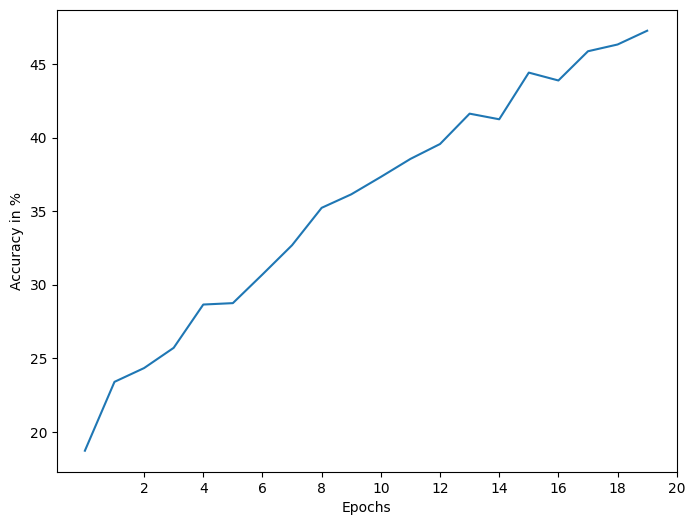

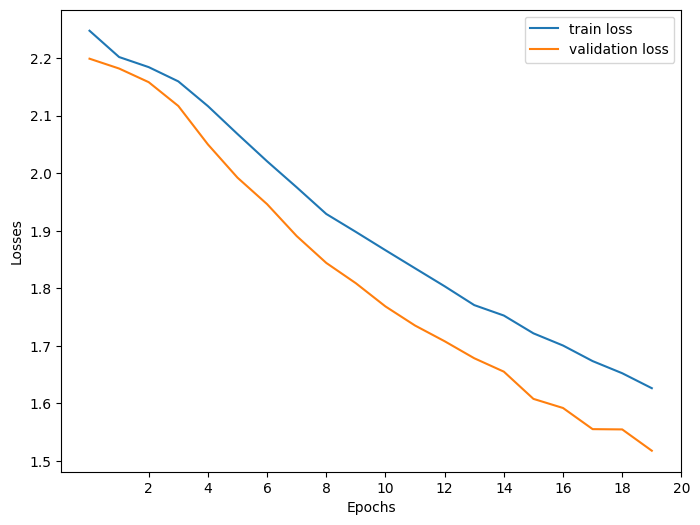

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:00<19:03, 60.18s/it]


epoch:   1, loss: 2.19923, valid loss: 2.12219, valid accruacy: 23.954%
Validation loss decreased (inf --> 2.122191). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:01<18:13, 60.74s/it]


epoch:   2, loss: 2.08543, valid loss: 2.00084, valid accruacy: 29.628%
Validation loss decreased (2.122191 --> 2.000845). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:59<16:54, 59.70s/it]


epoch:   3, loss: 1.99320, valid loss: 1.90744, valid accruacy: 33.467%
Validation loss decreased (2.000845 --> 1.907437). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:58<15:48, 59.29s/it]


epoch:   4, loss: 1.93050, valid loss: 1.85521, valid accruacy: 34.250%
Validation loss decreased (1.907437 --> 1.855210). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:56<14:44, 58.95s/it]


epoch:   5, loss: 1.87715, valid loss: 1.81069, valid accruacy: 36.294%
Validation loss decreased (1.855210 --> 1.810691). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:54<13:40, 58.61s/it]


epoch:   6, loss: 1.84776, valid loss: 1.77793, valid accruacy: 37.421%
Validation loss decreased (1.810691 --> 1.777931). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:52<12:39, 58.45s/it]


epoch:   7, loss: 1.81949, valid loss: 1.75222, valid accruacy: 38.472%
Validation loss decreased (1.777931 --> 1.752224). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:50<11:39, 58.33s/it]


epoch:   8, loss: 1.79413, valid loss: 1.73672, valid accruacy: 39.408%
Validation loss decreased (1.752224 --> 1.736721). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:57<11:11, 61.06s/it]


epoch:   9, loss: 1.77796, valid loss: 1.71695, valid accruacy: 39.924%
Validation loss decreased (1.736721 --> 1.716952). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [10:03<10:25, 62.51s/it]


epoch:  10, loss: 1.75156, valid loss: 1.69410, valid accruacy: 40.344%
Validation loss decreased (1.716952 --> 1.694098). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [11:08<09:29, 63.23s/it]


epoch:  11, loss: 1.73639, valid loss: 1.68501, valid accruacy: 40.573%
Validation loss decreased (1.694098 --> 1.685012). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [12:12<08:27, 63.49s/it]


epoch:  12, loss: 1.71761, valid loss: 1.65563, valid accruacy: 41.681%
Validation loss decreased (1.685012 --> 1.655627). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [13:15<07:22, 63.18s/it]


epoch:  13, loss: 1.70480, valid loss: 1.64080, valid accruacy: 42.732%
Validation loss decreased (1.655627 --> 1.640801). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [14:13<06:10, 61.69s/it]


epoch:  14, loss: 1.68350, valid loss: 1.63012, valid accruacy: 43.075%
Validation loss decreased (1.640801 --> 1.630125). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [15:11<05:02, 60.54s/it]


epoch:  15, loss: 1.67416, valid loss: 1.61837, valid accruacy: 43.419%
Validation loss decreased (1.630125 --> 1.618370). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [16:08<03:58, 59.50s/it]


epoch:  16, loss: 1.65998, valid loss: 1.58906, valid accruacy: 44.164%
Validation loss decreased (1.618370 --> 1.589062). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [17:04<02:55, 58.55s/it]


epoch:  17, loss: 1.63888, valid loss: 1.57930, valid accruacy: 44.795%
Validation loss decreased (1.589062 --> 1.579304). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [18:01<01:55, 57.95s/it]


epoch:  18, loss: 1.62764, valid loss: 1.56634, valid accruacy: 44.394%
Validation loss decreased (1.579304 --> 1.566343). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [18:57<00:57, 57.52s/it]


epoch:  19, loss: 1.60730, valid loss: 1.55013, valid accruacy: 45.291%
Validation loss decreased (1.566343 --> 1.550134). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:55<00:00, 59.76s/it]


epoch:  20, loss: 1.59251, valid loss: 1.53051, valid accruacy: 45.922%
Validation loss decreased (1.550134 --> 1.530510). Saving model...
Fit time: 1195.2768821716309 s


Test loss: 1.52463	Test accruacy: 46.315%
Saving model


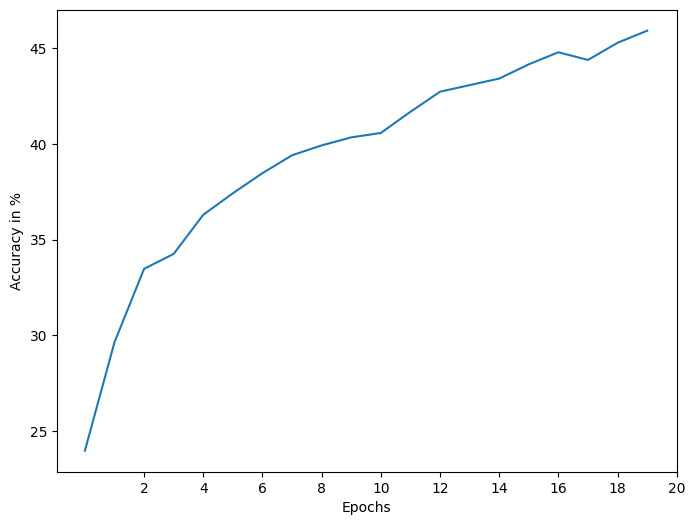

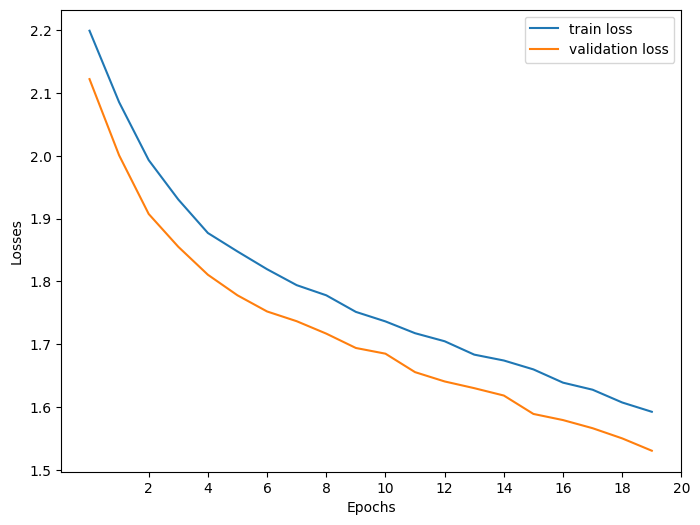

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:58<18:29, 58.38s/it]


epoch:   1, loss: 2.19832, valid loss: 2.12019, valid accruacy: 23.266%
Validation loss decreased (inf --> 2.120188). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:56<17:24, 58.05s/it]


epoch:   2, loss: 2.10202, valid loss: 2.00477, valid accruacy: 31.328%
Validation loss decreased (2.120188 --> 2.004773). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:53<16:21, 57.75s/it]


epoch:   3, loss: 2.01074, valid loss: 1.92300, valid accruacy: 33.887%
Validation loss decreased (2.004773 --> 1.922995). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:51<15:23, 57.72s/it]


epoch:   4, loss: 1.94653, valid loss: 1.85891, valid accruacy: 35.339%
Validation loss decreased (1.922995 --> 1.858907). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:49<14:29, 57.95s/it]


epoch:   5, loss: 1.90387, valid loss: 1.82806, valid accruacy: 36.600%
Validation loss decreased (1.858907 --> 1.828056). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:49<13:40, 58.61s/it]


epoch:   6, loss: 1.87339, valid loss: 1.78935, valid accruacy: 37.498%
Validation loss decreased (1.828056 --> 1.789351). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:47<12:38, 58.35s/it]


epoch:   7, loss: 1.84300, valid loss: 1.76982, valid accruacy: 38.472%
Validation loss decreased (1.789351 --> 1.769824). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:46<11:42, 58.51s/it]


epoch:   8, loss: 1.81742, valid loss: 1.74863, valid accruacy: 38.988%
Validation loss decreased (1.769824 --> 1.748630). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:44<10:44, 58.60s/it]


epoch:   9, loss: 1.79455, valid loss: 1.72232, valid accruacy: 40.764%
Validation loss decreased (1.748630 --> 1.722317). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:45<09:51, 59.11s/it]


epoch:  10, loss: 1.77035, valid loss: 1.70360, valid accruacy: 40.535%
Validation loss decreased (1.722317 --> 1.703601). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:44<08:52, 59.12s/it]


epoch:  11, loss: 1.74709, valid loss: 1.67533, valid accruacy: 41.433%
Validation loss decreased (1.703601 --> 1.675325). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:43<07:52, 59.10s/it]


epoch:  12, loss: 1.73397, valid loss: 1.65411, valid accruacy: 43.037%
Validation loss decreased (1.675325 --> 1.654106). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [12:42<06:53, 59.08s/it]


epoch:  13, loss: 1.71203, valid loss: 1.63011, valid accruacy: 43.629%
Validation loss decreased (1.654106 --> 1.630111). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [13:41<05:55, 59.19s/it]


epoch:  14, loss: 1.69478, valid loss: 1.61973, valid accruacy: 44.852%
Validation loss decreased (1.630111 --> 1.619733). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [14:42<04:58, 59.60s/it]


epoch:  15, loss: 1.67969, valid loss: 1.59838, valid accruacy: 45.177%
Validation loss decreased (1.619733 --> 1.598383). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [15:41<03:57, 59.50s/it]


epoch:  16, loss: 1.65557, valid loss: 1.56961, valid accruacy: 46.361%
Validation loss decreased (1.598383 --> 1.569613). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [16:40<02:58, 59.41s/it]


epoch:  17, loss: 1.63999, valid loss: 1.56689, valid accruacy: 46.552%
Validation loss decreased (1.569613 --> 1.566887). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [17:40<01:58, 59.33s/it]


epoch:  18, loss: 1.62540, valid loss: 1.53634, valid accruacy: 47.412%
Validation loss decreased (1.566887 --> 1.536338). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [18:39<00:59, 59.27s/it]


epoch:  19, loss: 1.60560, valid loss: 1.52678, valid accruacy: 47.354%
Validation loss decreased (1.536338 --> 1.526780). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:38<00:00, 58.93s/it]


epoch:  20, loss: 1.59090, valid loss: 1.50966, valid accruacy: 48.443%
Validation loss decreased (1.526780 --> 1.509662). Saving model...
Fit time: 1178.6687304973602 s


Test loss: 1.53748	Test accruacy: 47.308%
Saving model


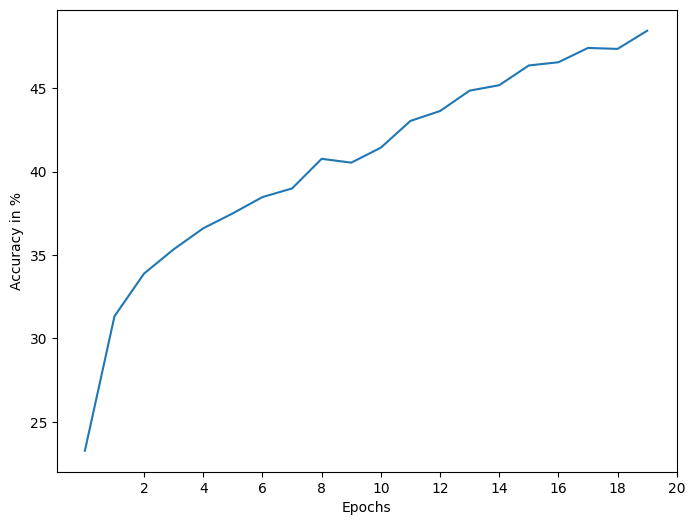

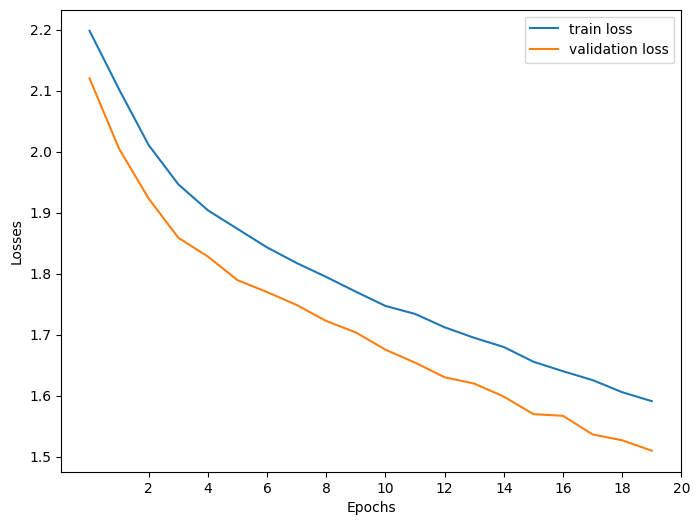

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:59<18:44, 59.18s/it]


epoch:   1, loss: 2.29809, valid loss: 2.28812, valid accruacy: 18.300%
Validation loss decreased (inf --> 2.288119). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:58<17:42, 59.04s/it]


epoch:   2, loss: 2.28143, valid loss: 2.27278, valid accruacy: 18.300%
Validation loss decreased (2.288119 --> 2.272784). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:56<16:41, 58.92s/it]


epoch:   3, loss: 2.26692, valid loss: 2.25902, valid accruacy: 18.300%
Validation loss decreased (2.272784 --> 2.259018). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:55<15:43, 58.96s/it]


epoch:   4, loss: 2.25329, valid loss: 2.24588, valid accruacy: 18.300%
Validation loss decreased (2.259018 --> 2.245880). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:55<14:48, 59.23s/it]


epoch:   5, loss: 2.24002, valid loss: 2.23351, valid accruacy: 18.300%
Validation loss decreased (2.245880 --> 2.233515). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:54<13:48, 59.20s/it]


epoch:   6, loss: 2.22897, valid loss: 2.22295, valid accruacy: 18.376%
Validation loss decreased (2.233515 --> 2.222947). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:53<12:47, 59.05s/it]


epoch:   7, loss: 2.22166, valid loss: 2.21575, valid accruacy: 20.344%
Validation loss decreased (2.222947 --> 2.215748). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:52<11:48, 59.03s/it]


epoch:   8, loss: 2.21621, valid loss: 2.21121, valid accruacy: 22.464%
Validation loss decreased (2.215748 --> 2.211213). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:51<10:48, 58.92s/it]


epoch:   9, loss: 2.21343, valid loss: 2.20840, valid accruacy: 22.942%
Validation loss decreased (2.211213 --> 2.208400). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:50<09:49, 58.94s/it]


epoch:  10, loss: 2.21116, valid loss: 2.20621, valid accruacy: 22.674%
Validation loss decreased (2.208400 --> 2.206215). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:49<08:51, 59.08s/it]


epoch:  11, loss: 2.20907, valid loss: 2.20439, valid accruacy: 22.961%
Validation loss decreased (2.206215 --> 2.204388). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:49<07:54, 59.27s/it]


epoch:  12, loss: 2.20791, valid loss: 2.20276, valid accruacy: 23.343%
Validation loss decreased (2.204388 --> 2.202762). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [12:48<06:54, 59.20s/it]


epoch:  13, loss: 2.20557, valid loss: 2.20098, valid accruacy: 23.553%
Validation loss decreased (2.202762 --> 2.200982). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [13:47<05:54, 59.10s/it]


epoch:  14, loss: 2.20369, valid loss: 2.19929, valid accruacy: 23.496%
Validation loss decreased (2.200982 --> 2.199291). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [14:46<04:56, 59.26s/it]


epoch:  15, loss: 2.20330, valid loss: 2.19747, valid accruacy: 23.419%
Validation loss decreased (2.199291 --> 2.197472). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [15:46<03:57, 59.33s/it]


epoch:  16, loss: 2.20087, valid loss: 2.19530, valid accruacy: 23.649%
Validation loss decreased (2.197472 --> 2.195297). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [16:45<02:57, 59.26s/it]


epoch:  17, loss: 2.19913, valid loss: 2.19318, valid accruacy: 23.572%
Validation loss decreased (2.195297 --> 2.193179). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [17:44<01:58, 59.35s/it]


epoch:  18, loss: 2.19814, valid loss: 2.19091, valid accruacy: 22.942%
Validation loss decreased (2.193179 --> 2.190910). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [18:44<00:59, 59.34s/it]


epoch:  19, loss: 2.19598, valid loss: 2.18849, valid accruacy: 22.770%
Validation loss decreased (2.190910 --> 2.188494). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:43<00:00, 59.19s/it]


epoch:  20, loss: 2.19301, valid loss: 2.18564, valid accruacy: 23.056%
Validation loss decreased (2.188494 --> 2.185642). Saving model...
Fit time: 1183.8694665431976 s


Test loss: 2.19546	Test accruacy: 23.177%
Saving model


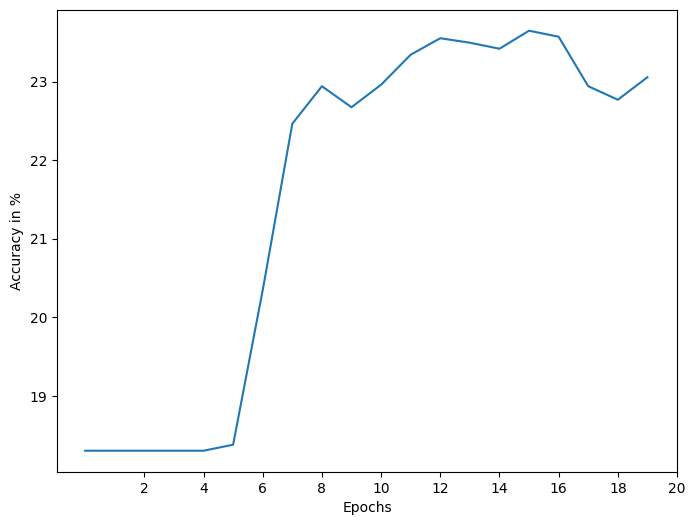

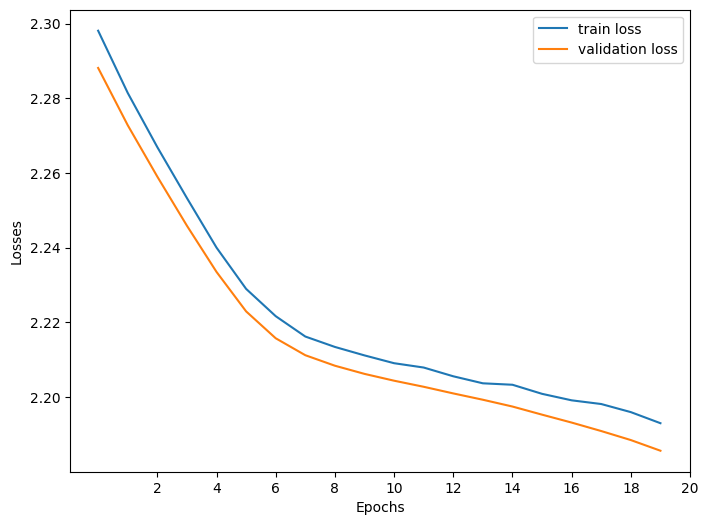

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [01:00<29:00, 60.01s/it]


epoch:   1, loss: 2.04973, valid loss: 1.85123, valid accruacy: 34.862%
Validation loss decreased (inf --> 1.851229). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [02:00<28:01, 60.04s/it]


epoch:   2, loss: 1.80782, valid loss: 1.65963, valid accruacy: 41.643%
Validation loss decreased (1.851229 --> 1.659631). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [03:00<27:02, 60.09s/it]


epoch:   3, loss: 1.67570, valid loss: 1.52847, valid accruacy: 47.106%
Validation loss decreased (1.659631 --> 1.528468). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:59<25:58, 59.96s/it]


epoch:   4, loss: 1.59077, valid loss: 1.48431, valid accruacy: 48.290%
Validation loss decreased (1.528468 --> 1.484305). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:59<24:59, 59.98s/it]


epoch:   5, loss: 1.51495, valid loss: 1.40281, valid accruacy: 50.946%
Validation loss decreased (1.484305 --> 1.402813). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [06:00<24:01, 60.06s/it]


epoch:   6, loss: 1.45410, valid loss: 1.37804, valid accruacy: 51.423%
Validation loss decreased (1.402813 --> 1.378041). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [07:00<23:00, 60.03s/it]


epoch:   7, loss: 1.39932, valid loss: 1.27591, valid accruacy: 57.020%
Validation loss decreased (1.378041 --> 1.275910). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [08:00<22:01, 60.06s/it]


epoch:   8, loss: 1.34627, valid loss: 1.22343, valid accruacy: 58.032%
Validation loss decreased (1.275910 --> 1.223427). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [09:00<20:59, 59.99s/it]


epoch:   9, loss: 1.29526, valid loss: 1.18933, valid accruacy: 60.172%
Validation loss decreased (1.223427 --> 1.189327). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [10:00<19:59, 59.95s/it]


epoch:  10, loss: 1.25921, valid loss: 1.13483, valid accruacy: 61.337%
Validation loss decreased (1.189327 --> 1.134833). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [11:00<19:00, 60.02s/it]


epoch:  11, loss: 1.20230, valid loss: 1.09734, valid accruacy: 62.751%
Validation loss decreased (1.134833 --> 1.097344). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:59<17:58, 59.92s/it]


epoch:  12, loss: 1.16444, valid loss: 1.04769, valid accruacy: 64.126%
Validation loss decreased (1.097344 --> 1.047691). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:59<16:57, 59.86s/it]


epoch:  13, loss: 1.12792, valid loss: 1.02348, valid accruacy: 65.406%
Validation loss decreased (1.047691 --> 1.023482). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [14:01<16:08, 60.51s/it]


epoch:  14, loss: 1.07952, valid loss: 0.98314, valid accruacy: 67.966%
Validation loss decreased (1.023482 --> 0.983142). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [15:02<15:07, 60.49s/it]


epoch:  15, loss: 1.05251, valid loss: 0.94171, valid accruacy: 69.608%
Validation loss decreased (0.983142 --> 0.941709). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [16:02<14:05, 60.40s/it]


epoch:  16, loss: 1.00995, valid loss: 0.92849, valid accruacy: 70.010%
Validation loss decreased (0.941709 --> 0.928490). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [17:02<13:02, 60.22s/it]


epoch:  17, loss: 0.99592, valid loss: 0.90827, valid accruacy: 70.602%
Validation loss decreased (0.928490 --> 0.908274). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [18:01<12:00, 60.01s/it]


epoch:  18, loss: 0.95681, valid loss: 0.88091, valid accruacy: 71.328%
Validation loss decreased (0.908274 --> 0.880913). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [19:01<10:59, 59.99s/it]


epoch:  19, loss: 0.91941, valid loss: 0.84840, valid accruacy: 72.760%
Validation loss decreased (0.880913 --> 0.848404). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [20:01<09:59, 59.96s/it]


epoch:  20, loss: 0.89448, valid loss: 0.81471, valid accruacy: 75.282%
Validation loss decreased (0.848404 --> 0.814706). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [21:01<08:59, 59.92s/it]


epoch:  21, loss: 0.87860, valid loss: 0.82020, valid accruacy: 74.709%


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [22:01<07:59, 59.95s/it]


epoch:  22, loss: 0.84004, valid loss: 0.81881, valid accruacy: 75.110%


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [23:01<07:00, 60.02s/it]


epoch:  23, loss: 0.82333, valid loss: 0.80151, valid accruacy: 75.626%
Validation loss decreased (0.814706 --> 0.801513). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [24:01<06:00, 60.04s/it]


epoch:  24, loss: 0.80515, valid loss: 0.78691, valid accruacy: 76.447%
Validation loss decreased (0.801513 --> 0.786906). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [25:01<05:00, 60.11s/it]


epoch:  25, loss: 0.78603, valid loss: 0.74798, valid accruacy: 77.593%
Validation loss decreased (0.786906 --> 0.747978). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [26:03<04:02, 60.70s/it]


epoch:  26, loss: 0.78022, valid loss: 0.77125, valid accruacy: 77.020%


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [27:03<03:01, 60.49s/it]


epoch:  27, loss: 0.75506, valid loss: 0.73258, valid accruacy: 78.109%
Validation loss decreased (0.747978 --> 0.732575). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [28:03<02:00, 60.25s/it]


epoch:  28, loss: 0.73913, valid loss: 0.72264, valid accruacy: 78.606%
Validation loss decreased (0.732575 --> 0.722644). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [29:03<01:00, 60.11s/it]


epoch:  29, loss: 0.71875, valid loss: 0.72413, valid accruacy: 79.542%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [30:05<00:00, 60.19s/it]


epoch:  30, loss: 0.72456, valid loss: 0.72909, valid accruacy: 79.503%
Fit time: 1805.7731959819794 s


Test loss: 0.74703	Test accruacy: 78.541%
Saving model


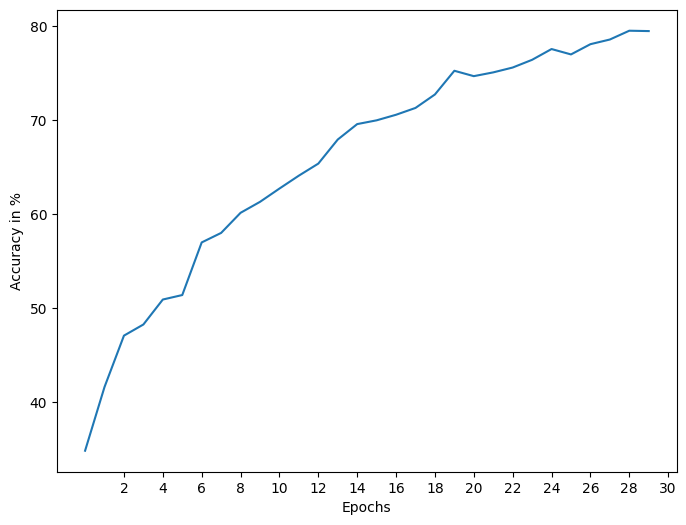

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [00:59<28:51, 59.72s/it]


epoch:   1, loss: 2.05102, valid loss: 1.79967, valid accruacy: 37.555%
Validation loss decreased (inf --> 1.799668). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [01:58<27:42, 59.36s/it]


epoch:   2, loss: 1.80894, valid loss: 1.66681, valid accruacy: 42.579%
Validation loss decreased (1.799668 --> 1.666811). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:57<26:37, 59.16s/it]


epoch:   3, loss: 1.67249, valid loss: 1.52320, valid accruacy: 47.641%
Validation loss decreased (1.666811 --> 1.523199). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:56<25:34, 59.03s/it]


epoch:   4, loss: 1.58050, valid loss: 1.45589, valid accruacy: 50.048%
Validation loss decreased (1.523199 --> 1.455886). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:55<24:36, 59.04s/it]


epoch:   5, loss: 1.49351, valid loss: 1.38349, valid accruacy: 52.378%
Validation loss decreased (1.455886 --> 1.383488). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [05:54<23:34, 58.92s/it]


epoch:   6, loss: 1.43943, valid loss: 1.33635, valid accruacy: 54.938%
Validation loss decreased (1.383488 --> 1.336351). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:53<22:36, 58.96s/it]


epoch:   7, loss: 1.38197, valid loss: 1.26139, valid accruacy: 57.574%
Validation loss decreased (1.336351 --> 1.261394). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:52<21:35, 58.88s/it]


epoch:   8, loss: 1.31981, valid loss: 1.20804, valid accruacy: 60.267%
Validation loss decreased (1.261394 --> 1.208038). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:50<20:36, 58.89s/it]


epoch:   9, loss: 1.26691, valid loss: 1.17816, valid accruacy: 60.248%
Validation loss decreased (1.208038 --> 1.178161). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:50<19:41, 59.10s/it]


epoch:  10, loss: 1.21402, valid loss: 1.12849, valid accruacy: 62.445%
Validation loss decreased (1.178161 --> 1.128491). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:50<18:45, 59.23s/it]


epoch:  11, loss: 1.17066, valid loss: 1.08168, valid accruacy: 63.878%
Validation loss decreased (1.128491 --> 1.081682). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:49<17:46, 59.25s/it]


epoch:  12, loss: 1.13008, valid loss: 1.02797, valid accruacy: 66.934%
Validation loss decreased (1.081682 --> 1.027973). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:48<16:46, 59.21s/it]


epoch:  13, loss: 1.08427, valid loss: 1.01024, valid accruacy: 67.908%
Validation loss decreased (1.027973 --> 1.010237). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:48<15:50, 59.40s/it]


epoch:  14, loss: 1.03157, valid loss: 0.98658, valid accruacy: 69.245%
Validation loss decreased (1.010237 --> 0.986583). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [14:47<14:51, 59.47s/it]


epoch:  15, loss: 1.01158, valid loss: 0.93372, valid accruacy: 70.430%
Validation loss decreased (0.986583 --> 0.933720). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [15:47<13:54, 59.58s/it]


epoch:  16, loss: 0.97176, valid loss: 0.89398, valid accruacy: 72.512%
Validation loss decreased (0.933720 --> 0.893983). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [16:47<12:53, 59.52s/it]


epoch:  17, loss: 0.93823, valid loss: 0.89918, valid accruacy: 72.264%


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [17:46<11:53, 59.48s/it]


epoch:  18, loss: 0.90785, valid loss: 0.92383, valid accruacy: 71.691%


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [18:45<10:53, 59.38s/it]


epoch:  19, loss: 0.88581, valid loss: 0.85678, valid accruacy: 74.365%
Validation loss decreased (0.893983 --> 0.856779). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [19:45<09:54, 59.46s/it]


epoch:  20, loss: 0.85904, valid loss: 0.83407, valid accruacy: 75.473%
Validation loss decreased (0.856779 --> 0.834072). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [20:44<08:55, 59.48s/it]


epoch:  21, loss: 0.82733, valid loss: 0.81834, valid accruacy: 76.543%
Validation loss decreased (0.834072 --> 0.818338). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [21:44<07:55, 59.44s/it]


epoch:  22, loss: 0.81088, valid loss: 0.79698, valid accruacy: 77.192%
Validation loss decreased (0.818338 --> 0.796983). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [22:43<06:55, 59.35s/it]


epoch:  23, loss: 0.78667, valid loss: 0.78140, valid accruacy: 78.434%
Validation loss decreased (0.796983 --> 0.781396). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [23:43<05:56, 59.44s/it]


epoch:  24, loss: 0.77541, valid loss: 0.77823, valid accruacy: 78.777%
Validation loss decreased (0.781396 --> 0.778234). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [24:43<04:58, 59.61s/it]


epoch:  25, loss: 0.74532, valid loss: 0.77203, valid accruacy: 78.663%
Validation loss decreased (0.778234 --> 0.772030). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [25:43<03:59, 59.75s/it]


epoch:  26, loss: 0.73051, valid loss: 0.77823, valid accruacy: 79.866%


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [26:42<02:58, 59.59s/it]


epoch:  27, loss: 0.71119, valid loss: 0.78337, valid accruacy: 79.503%


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [27:41<01:59, 59.60s/it]


epoch:  28, loss: 0.70905, valid loss: 0.76603, valid accruacy: 80.287%
Validation loss decreased (0.772030 --> 0.766028). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [28:41<00:59, 59.65s/it]


epoch:  29, loss: 0.68269, valid loss: 0.79661, valid accruacy: 79.064%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [29:41<00:00, 59.38s/it]


epoch:  30, loss: 0.66163, valid loss: 0.78119, valid accruacy: 79.637%
Fit time: 1781.5267736911774 s


Test loss: 0.78364	Test accruacy: 79.000%
Saving model


results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [00:59<28:33, 59.10s/it]


epoch:   1, loss: 2.23495, valid loss: 2.19508, valid accruacy: 20.860%
Validation loss decreased (inf --> 2.195077). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [01:58<27:32, 59.02s/it]


epoch:   2, loss: 2.19148, valid loss: 2.17153, valid accruacy: 20.917%
Validation loss decreased (2.195077 --> 2.171535). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:56<26:31, 58.96s/it]


epoch:   3, loss: 2.17067, valid loss: 2.13637, valid accruacy: 21.834%
Validation loss decreased (2.171535 --> 2.136370). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:55<25:33, 58.97s/it]


epoch:   4, loss: 2.13561, valid loss: 2.08559, valid accruacy: 24.928%
Validation loss decreased (2.136370 --> 2.085589). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:55<24:37, 59.10s/it]


epoch:   5, loss: 2.09330, valid loss: 2.03144, valid accruacy: 27.985%
Validation loss decreased (2.085589 --> 2.031437). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [05:54<23:41, 59.23s/it]


epoch:   6, loss: 2.05045, valid loss: 1.97757, valid accruacy: 30.869%
Validation loss decreased (2.031437 --> 1.977567). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:53<22:40, 59.16s/it]


epoch:   7, loss: 1.99931, valid loss: 1.91514, valid accruacy: 32.245%
Validation loss decreased (1.977567 --> 1.915142). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:52<21:41, 59.17s/it]


epoch:   8, loss: 1.96400, valid loss: 1.87942, valid accruacy: 33.391%
Validation loss decreased (1.915142 --> 1.879420). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:52<20:44, 59.26s/it]


epoch:   9, loss: 1.92468, valid loss: 1.83841, valid accruacy: 35.167%
Validation loss decreased (1.879420 --> 1.838410). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:52<19:48, 59.40s/it]


epoch:  10, loss: 1.89045, valid loss: 1.81008, valid accruacy: 37.096%
Validation loss decreased (1.838410 --> 1.810078). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:51<18:49, 59.43s/it]


epoch:  11, loss: 1.86083, valid loss: 1.76876, valid accruacy: 38.128%
Validation loss decreased (1.810078 --> 1.768757). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:50<17:47, 59.29s/it]


epoch:  12, loss: 1.82545, valid loss: 1.74025, valid accruacy: 39.140%
Validation loss decreased (1.768757 --> 1.740245). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:50<16:48, 59.34s/it]


epoch:  13, loss: 1.80619, valid loss: 1.71098, valid accruacy: 40.497%
Validation loss decreased (1.740245 --> 1.710985). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:51<15:58, 59.88s/it]


epoch:  14, loss: 1.77175, valid loss: 1.68668, valid accruacy: 41.509%
Validation loss decreased (1.710985 --> 1.686679). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [14:51<15:01, 60.13s/it]


epoch:  15, loss: 1.75536, valid loss: 1.65728, valid accruacy: 42.674%
Validation loss decreased (1.686679 --> 1.657276). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [15:55<14:18, 61.29s/it]


epoch:  16, loss: 1.72623, valid loss: 1.63073, valid accruacy: 43.763%
Validation loss decreased (1.657276 --> 1.630727). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [16:55<13:09, 60.70s/it]


epoch:  17, loss: 1.70962, valid loss: 1.61153, valid accruacy: 43.763%
Validation loss decreased (1.630727 --> 1.611534). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [17:54<12:02, 60.24s/it]


epoch:  18, loss: 1.68733, valid loss: 1.59770, valid accruacy: 45.024%
Validation loss decreased (1.611534 --> 1.597703). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [18:53<10:59, 59.97s/it]


epoch:  19, loss: 1.66761, valid loss: 1.56006, valid accruacy: 45.941%
Validation loss decreased (1.597703 --> 1.560061). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [19:53<09:58, 59.82s/it]


epoch:  20, loss: 1.64534, valid loss: 1.54065, valid accruacy: 46.648%
Validation loss decreased (1.560061 --> 1.540646). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [20:52<08:57, 59.71s/it]


epoch:  21, loss: 1.61787, valid loss: 1.51955, valid accruacy: 47.641%
Validation loss decreased (1.540646 --> 1.519547). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [21:52<07:56, 59.61s/it]


epoch:  22, loss: 1.60236, valid loss: 1.49920, valid accruacy: 48.500%
Validation loss decreased (1.519547 --> 1.499204). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [22:51<06:57, 59.63s/it]


epoch:  23, loss: 1.58467, valid loss: 1.49623, valid accruacy: 48.443%
Validation loss decreased (1.499204 --> 1.496232). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [23:51<05:57, 59.58s/it]


epoch:  24, loss: 1.56564, valid loss: 1.47678, valid accruacy: 49.265%
Validation loss decreased (1.496232 --> 1.476784). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [24:51<04:58, 59.68s/it]


epoch:  25, loss: 1.55352, valid loss: 1.46640, valid accruacy: 49.990%
Validation loss decreased (1.476784 --> 1.466405). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [25:52<04:00, 60.15s/it]


epoch:  26, loss: 1.53384, valid loss: 1.42550, valid accruacy: 50.697%
Validation loss decreased (1.466405 --> 1.425499). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [26:51<02:59, 59.93s/it]


epoch:  27, loss: 1.51360, valid loss: 1.42498, valid accruacy: 51.213%
Validation loss decreased (1.425499 --> 1.424979). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [27:51<01:59, 59.81s/it]


epoch:  28, loss: 1.50088, valid loss: 1.39786, valid accruacy: 51.996%
Validation loss decreased (1.424979 --> 1.397863). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [28:50<00:59, 59.73s/it]


epoch:  29, loss: 1.48279, valid loss: 1.38273, valid accruacy: 52.951%
Validation loss decreased (1.397863 --> 1.382735). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [29:50<00:00, 59.70s/it]


epoch:  30, loss: 1.46170, valid loss: 1.35674, valid accruacy: 53.161%
Validation loss decreased (1.382735 --> 1.356745). Saving model...
Fit time: 1790.8909261226654 s


Test loss: 1.36800	Test accruacy: 52.730%
Saving model


results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [01:00<29:20, 60.70s/it]


epoch:   1, loss: 2.19430, valid loss: 2.12035, valid accruacy: 25.062%
Validation loss decreased (inf --> 2.120348). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [02:00<28:02, 60.10s/it]


epoch:   2, loss: 2.09027, valid loss: 2.00223, valid accruacy: 30.602%
Validation loss decreased (2.120348 --> 2.002229). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:59<26:55, 59.84s/it]


epoch:   3, loss: 2.00899, valid loss: 1.92609, valid accruacy: 32.245%
Validation loss decreased (2.002229 --> 1.926095). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [04:00<26:04, 60.17s/it]


epoch:   4, loss: 1.95084, valid loss: 1.87757, valid accruacy: 33.811%
Validation loss decreased (1.926095 --> 1.877568). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [05:00<25:00, 60.01s/it]


epoch:   5, loss: 1.91096, valid loss: 1.83708, valid accruacy: 35.053%
Validation loss decreased (1.877568 --> 1.837078). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [05:59<23:56, 59.87s/it]


epoch:   6, loss: 1.88181, valid loss: 1.80559, valid accruacy: 36.160%
Validation loss decreased (1.837078 --> 1.805585). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:59<22:54, 59.77s/it]


epoch:   7, loss: 1.85770, valid loss: 1.78106, valid accruacy: 37.536%
Validation loss decreased (1.805585 --> 1.781063). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:59<21:54, 59.77s/it]


epoch:   8, loss: 1.83250, valid loss: 1.75675, valid accruacy: 37.880%
Validation loss decreased (1.781063 --> 1.756748). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:58<20:53, 59.68s/it]


epoch:   9, loss: 1.80971, valid loss: 1.73023, valid accruacy: 38.968%
Validation loss decreased (1.756748 --> 1.730226). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:58<19:56, 59.84s/it]


epoch:  10, loss: 1.78499, valid loss: 1.70309, valid accruacy: 39.331%
Validation loss decreased (1.730226 --> 1.703093). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:58<18:56, 59.84s/it]


epoch:  11, loss: 1.77042, valid loss: 1.69441, valid accruacy: 40.573%
Validation loss decreased (1.703093 --> 1.694409). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:59<18:02, 60.11s/it]


epoch:  12, loss: 1.74862, valid loss: 1.67465, valid accruacy: 40.573%
Validation loss decreased (1.694409 --> 1.674654). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [13:00<17:06, 60.39s/it]


epoch:  13, loss: 1.72640, valid loss: 1.65045, valid accruacy: 41.528%
Validation loss decreased (1.674654 --> 1.650452). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [14:00<16:04, 60.29s/it]


epoch:  14, loss: 1.71027, valid loss: 1.63923, valid accruacy: 42.025%
Validation loss decreased (1.650452 --> 1.639228). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [15:01<15:06, 60.40s/it]


epoch:  15, loss: 1.69308, valid loss: 1.62146, valid accruacy: 42.254%
Validation loss decreased (1.639228 --> 1.621461). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [16:01<14:06, 60.50s/it]


epoch:  16, loss: 1.68109, valid loss: 1.60041, valid accruacy: 43.171%
Validation loss decreased (1.621461 --> 1.600410). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [17:01<13:03, 60.23s/it]


epoch:  17, loss: 1.66455, valid loss: 1.58365, valid accruacy: 43.419%
Validation loss decreased (1.600410 --> 1.583651). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [18:00<11:58, 59.91s/it]


epoch:  18, loss: 1.65111, valid loss: 1.57273, valid accruacy: 44.680%
Validation loss decreased (1.583651 --> 1.572728). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [19:00<10:57, 59.75s/it]


epoch:  19, loss: 1.63417, valid loss: 1.54917, valid accruacy: 45.330%
Validation loss decreased (1.572728 --> 1.549171). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [20:01<10:02, 60.26s/it]


epoch:  20, loss: 1.61737, valid loss: 1.53748, valid accruacy: 45.482%
Validation loss decreased (1.549171 --> 1.537483). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [21:01<09:00, 60.04s/it]


epoch:  21, loss: 1.61027, valid loss: 1.52078, valid accruacy: 46.055%
Validation loss decreased (1.537483 --> 1.520781). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [22:00<07:59, 59.89s/it]


epoch:  22, loss: 1.58945, valid loss: 1.50696, valid accruacy: 46.170%
Validation loss decreased (1.520781 --> 1.506959). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [22:59<06:58, 59.73s/it]


epoch:  23, loss: 1.57862, valid loss: 1.49182, valid accruacy: 47.297%
Validation loss decreased (1.506959 --> 1.491818). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [23:59<05:58, 59.73s/it]


epoch:  24, loss: 1.56769, valid loss: 1.47859, valid accruacy: 48.138%
Validation loss decreased (1.491818 --> 1.478593). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [24:59<04:59, 59.83s/it]


epoch:  25, loss: 1.55547, valid loss: 1.47356, valid accruacy: 47.947%
Validation loss decreased (1.478593 --> 1.473557). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [25:59<03:59, 59.91s/it]


epoch:  26, loss: 1.53671, valid loss: 1.45383, valid accruacy: 48.844%
Validation loss decreased (1.473557 --> 1.453827). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [26:59<02:59, 59.86s/it]


epoch:  27, loss: 1.53363, valid loss: 1.44957, valid accruacy: 48.978%
Validation loss decreased (1.453827 --> 1.449571). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [27:59<01:59, 59.85s/it]


epoch:  28, loss: 1.51163, valid loss: 1.43130, valid accruacy: 49.589%
Validation loss decreased (1.449571 --> 1.431296). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [28:59<00:59, 59.85s/it]


epoch:  29, loss: 1.50320, valid loss: 1.41373, valid accruacy: 50.468%
Validation loss decreased (1.431296 --> 1.413727). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [29:59<00:00, 59.97s/it]


epoch:  30, loss: 1.48805, valid loss: 1.40413, valid accruacy: 50.755%
Validation loss decreased (1.413727 --> 1.404134). Saving model...
Fit time: 1799.1019568443298 s


Test loss: 1.44238	Test accruacy: 49.714%
Saving model


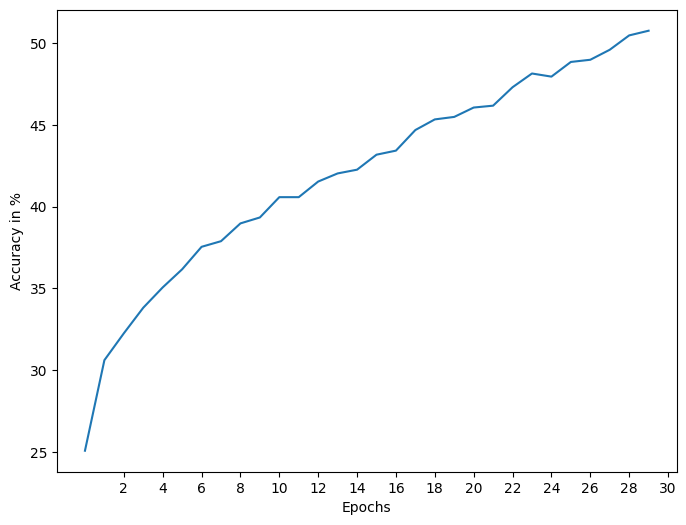

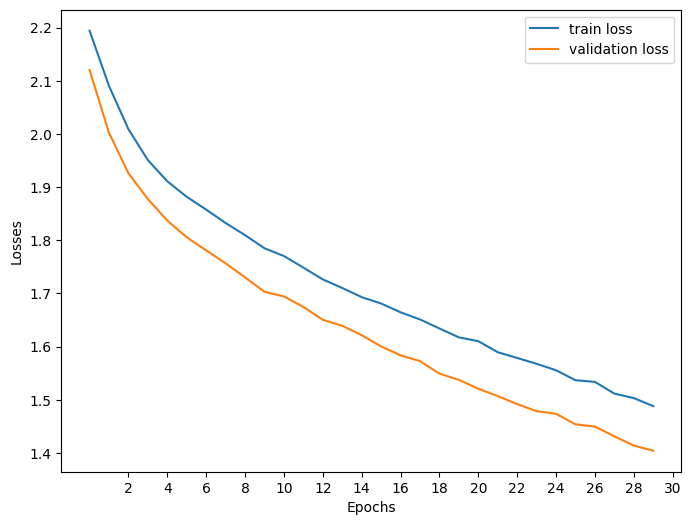

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [01:00<29:13, 60.47s/it]


epoch:   1, loss: 2.21071, valid loss: 2.13673, valid accruacy: 22.369%
Validation loss decreased (inf --> 2.136735). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [02:00<28:05, 60.18s/it]


epoch:   2, loss: 2.11082, valid loss: 2.01185, valid accruacy: 29.761%
Validation loss decreased (2.136735 --> 2.011848). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [03:00<27:03, 60.14s/it]


epoch:   3, loss: 2.01934, valid loss: 1.93711, valid accruacy: 32.569%
Validation loss decreased (2.011848 --> 1.937113). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [04:00<25:59, 60.00s/it]


epoch:   4, loss: 1.95745, valid loss: 1.88697, valid accruacy: 34.327%
Validation loss decreased (1.937113 --> 1.886969). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [05:00<25:01, 60.05s/it]


epoch:   5, loss: 1.90580, valid loss: 1.83719, valid accruacy: 35.664%
Validation loss decreased (1.886969 --> 1.837189). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [06:00<23:57, 59.91s/it]


epoch:   6, loss: 1.86334, valid loss: 1.79430, valid accruacy: 37.479%
Validation loss decreased (1.837189 --> 1.794299). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:59<22:56, 59.85s/it]


epoch:   7, loss: 1.83534, valid loss: 1.76357, valid accruacy: 37.612%
Validation loss decreased (1.794299 --> 1.763570). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:59<21:57, 59.88s/it]


epoch:   8, loss: 1.79948, valid loss: 1.74062, valid accruacy: 38.682%
Validation loss decreased (1.763570 --> 1.740619). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:59<20:57, 59.90s/it]


epoch:   9, loss: 1.78320, valid loss: 1.71533, valid accruacy: 39.236%
Validation loss decreased (1.740619 --> 1.715330). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:59<19:58, 59.93s/it]


epoch:  10, loss: 1.75211, valid loss: 1.69643, valid accruacy: 40.057%
Validation loss decreased (1.715330 --> 1.696432). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:59<18:58, 59.94s/it]


epoch:  11, loss: 1.73128, valid loss: 1.67635, valid accruacy: 41.280%
Validation loss decreased (1.696432 --> 1.676350). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:59<17:56, 59.83s/it]


epoch:  12, loss: 1.71605, valid loss: 1.66094, valid accruacy: 42.006%
Validation loss decreased (1.676350 --> 1.660938). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:59<16:57, 59.84s/it]


epoch:  13, loss: 1.70054, valid loss: 1.63920, valid accruacy: 42.330%
Validation loss decreased (1.660938 --> 1.639199). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [14:01<16:08, 60.50s/it]


epoch:  14, loss: 1.68426, valid loss: 1.61770, valid accruacy: 43.056%
Validation loss decreased (1.639199 --> 1.617696). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [15:01<15:07, 60.47s/it]


epoch:  15, loss: 1.66642, valid loss: 1.60184, valid accruacy: 44.374%
Validation loss decreased (1.617696 --> 1.601840). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [16:01<14:04, 60.31s/it]


epoch:  16, loss: 1.65231, valid loss: 1.58673, valid accruacy: 44.661%
Validation loss decreased (1.601840 --> 1.586729). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [17:00<12:59, 59.96s/it]


epoch:  17, loss: 1.63269, valid loss: 1.57850, valid accruacy: 44.928%
Validation loss decreased (1.586729 --> 1.578497). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [18:00<11:59, 59.98s/it]


epoch:  18, loss: 1.61739, valid loss: 1.55775, valid accruacy: 46.208%
Validation loss decreased (1.578497 --> 1.557754). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [19:00<10:58, 59.90s/it]


epoch:  19, loss: 1.60330, valid loss: 1.54778, valid accruacy: 46.686%
Validation loss decreased (1.557754 --> 1.547777). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [20:00<09:58, 59.90s/it]


epoch:  20, loss: 1.59113, valid loss: 1.53488, valid accruacy: 46.705%
Validation loss decreased (1.547777 --> 1.534876). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [21:00<08:59, 59.95s/it]


epoch:  21, loss: 1.57889, valid loss: 1.52108, valid accruacy: 47.393%
Validation loss decreased (1.534876 --> 1.521083). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [21:59<07:58, 59.81s/it]


epoch:  22, loss: 1.56779, valid loss: 1.50137, valid accruacy: 48.233%
Validation loss decreased (1.521083 --> 1.501367). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [22:59<06:58, 59.80s/it]


epoch:  23, loss: 1.55691, valid loss: 1.48935, valid accruacy: 48.730%
Validation loss decreased (1.501367 --> 1.489347). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [23:59<05:58, 59.78s/it]


epoch:  24, loss: 1.53367, valid loss: 1.47736, valid accruacy: 49.379%
Validation loss decreased (1.489347 --> 1.477359). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [24:59<04:59, 59.84s/it]


epoch:  25, loss: 1.52454, valid loss: 1.46606, valid accruacy: 49.666%
Validation loss decreased (1.477359 --> 1.466062). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [26:01<04:01, 60.49s/it]


epoch:  26, loss: 1.51317, valid loss: 1.45600, valid accruacy: 50.029%
Validation loss decreased (1.466062 --> 1.456000). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [27:00<03:00, 60.17s/it]


epoch:  27, loss: 1.50525, valid loss: 1.44321, valid accruacy: 50.697%
Validation loss decreased (1.456000 --> 1.443211). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [28:00<02:00, 60.10s/it]


epoch:  28, loss: 1.49462, valid loss: 1.43191, valid accruacy: 50.774%
Validation loss decreased (1.443211 --> 1.431915). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [29:00<00:59, 59.92s/it]


epoch:  29, loss: 1.47266, valid loss: 1.41274, valid accruacy: 51.461%
Validation loss decreased (1.431915 --> 1.412745). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [29:59<00:00, 59.99s/it]


epoch:  30, loss: 1.46540, valid loss: 1.40726, valid accruacy: 52.073%
Validation loss decreased (1.412745 --> 1.407257). Saving model...
Fit time: 1799.7176427841187 s


Test loss: 1.36841	Test accruacy: 53.876%
Saving model


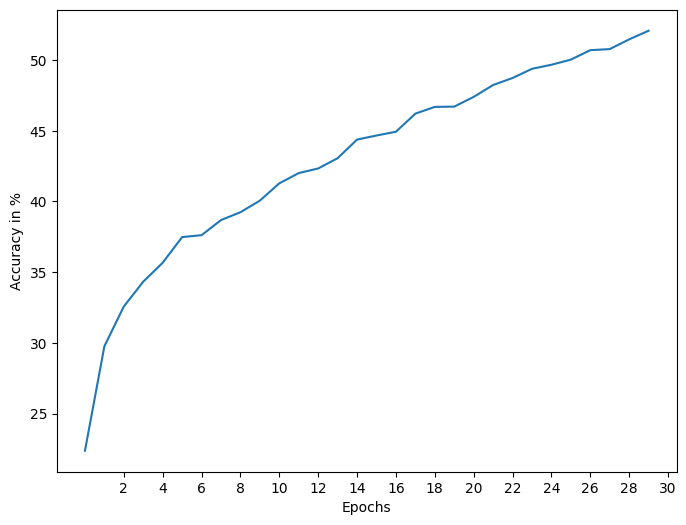

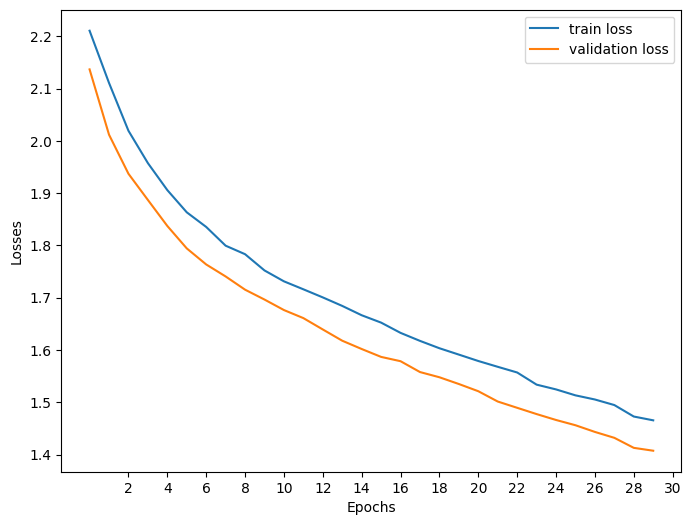

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [01:00<29:13, 60.47s/it]


epoch:   1, loss: 2.29720, valid loss: 2.28665, valid accruacy: 19.064%
Validation loss decreased (inf --> 2.286652). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [02:00<28:08, 60.31s/it]


epoch:   2, loss: 2.27789, valid loss: 2.26689, valid accruacy: 18.777%
Validation loss decreased (2.286652 --> 2.266886). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [03:00<27:03, 60.13s/it]


epoch:   3, loss: 2.25682, valid loss: 2.24563, valid accruacy: 19.274%
Validation loss decreased (2.266886 --> 2.245635). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [04:00<26:02, 60.11s/it]


epoch:   4, loss: 2.23609, valid loss: 2.22480, valid accruacy: 19.484%
Validation loss decreased (2.245635 --> 2.224797). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [05:12<26:50, 64.43s/it]


epoch:   5, loss: 2.22139, valid loss: 2.21137, valid accruacy: 19.924%
Validation loss decreased (2.224797 --> 2.211370). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [06:12<25:08, 62.87s/it]


epoch:   6, loss: 2.21194, valid loss: 2.20432, valid accruacy: 20.936%
Validation loss decreased (2.211370 --> 2.204317). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [07:12<23:42, 61.85s/it]


epoch:   7, loss: 2.20781, valid loss: 2.20047, valid accruacy: 22.350%
Validation loss decreased (2.204317 --> 2.200472). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [08:12<22:27, 61.26s/it]


epoch:   8, loss: 2.20251, valid loss: 2.19747, valid accruacy: 22.120%
Validation loss decreased (2.200472 --> 2.197465). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [09:12<21:21, 61.03s/it]


epoch:   9, loss: 2.20307, valid loss: 2.19556, valid accruacy: 21.490%
Validation loss decreased (2.197465 --> 2.195563). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [10:12<20:14, 60.72s/it]


epoch:  10, loss: 2.19964, valid loss: 2.19355, valid accruacy: 22.120%
Validation loss decreased (2.195563 --> 2.193550). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [11:13<19:14, 60.79s/it]


epoch:  11, loss: 2.19850, valid loss: 2.19185, valid accruacy: 22.426%
Validation loss decreased (2.193550 --> 2.191849). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [12:17<18:27, 61.54s/it]


epoch:  12, loss: 2.19644, valid loss: 2.18945, valid accruacy: 22.579%
Validation loss decreased (2.191849 --> 2.189449). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [13:17<17:20, 61.23s/it]


epoch:  13, loss: 2.19574, valid loss: 2.18733, valid accruacy: 21.719%
Validation loss decreased (2.189449 --> 2.187330). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [14:18<16:16, 61.04s/it]


epoch:  14, loss: 2.19194, valid loss: 2.18491, valid accruacy: 21.738%
Validation loss decreased (2.187330 --> 2.184909). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [15:18<15:13, 60.89s/it]


epoch:  15, loss: 2.18833, valid loss: 2.18209, valid accruacy: 22.025%
Validation loss decreased (2.184909 --> 2.182095). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [16:18<14:05, 60.41s/it]


epoch:  16, loss: 2.18662, valid loss: 2.17931, valid accruacy: 21.433%
Validation loss decreased (2.182095 --> 2.179310). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [17:17<12:59, 59.98s/it]


epoch:  17, loss: 2.18659, valid loss: 2.17640, valid accruacy: 21.051%
Validation loss decreased (2.179310 --> 2.176404). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [18:16<11:58, 59.88s/it]


epoch:  18, loss: 2.18215, valid loss: 2.17313, valid accruacy: 20.821%
Validation loss decreased (2.176404 --> 2.173134). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [19:15<10:56, 59.67s/it]


epoch:  19, loss: 2.17974, valid loss: 2.16968, valid accruacy: 20.821%
Validation loss decreased (2.173134 --> 2.169677). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [20:14<09:53, 59.40s/it]


epoch:  20, loss: 2.17703, valid loss: 2.16592, valid accruacy: 20.707%
Validation loss decreased (2.169677 --> 2.165920). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [21:14<08:56, 59.56s/it]


epoch:  21, loss: 2.17461, valid loss: 2.16235, valid accruacy: 20.821%
Validation loss decreased (2.165920 --> 2.162351). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [22:15<07:59, 59.93s/it]


epoch:  22, loss: 2.17254, valid loss: 2.15861, valid accruacy: 20.745%
Validation loss decreased (2.162351 --> 2.158614). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [23:14<06:57, 59.69s/it]


epoch:  23, loss: 2.16892, valid loss: 2.15437, valid accruacy: 20.974%
Validation loss decreased (2.158614 --> 2.154372). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [24:14<05:58, 59.68s/it]


epoch:  24, loss: 2.16590, valid loss: 2.15027, valid accruacy: 21.261%
Validation loss decreased (2.154372 --> 2.150267). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [25:13<04:58, 59.70s/it]


epoch:  25, loss: 2.16135, valid loss: 2.14608, valid accruacy: 21.509%
Validation loss decreased (2.150267 --> 2.146083). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [26:13<03:59, 59.78s/it]


epoch:  26, loss: 2.15930, valid loss: 2.14188, valid accruacy: 22.159%
Validation loss decreased (2.146083 --> 2.141877). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [27:13<02:59, 59.71s/it]


epoch:  27, loss: 2.15396, valid loss: 2.13673, valid accruacy: 22.273%
Validation loss decreased (2.141877 --> 2.136735). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [28:12<01:59, 59.55s/it]


epoch:  28, loss: 2.15450, valid loss: 2.13241, valid accruacy: 23.056%
Validation loss decreased (2.136735 --> 2.132412). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [29:11<00:59, 59.32s/it]


epoch:  29, loss: 2.14939, valid loss: 2.12722, valid accruacy: 23.457%
Validation loss decreased (2.132412 --> 2.127224). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [30:10<00:00, 60.36s/it]


epoch:  30, loss: 2.14510, valid loss: 2.12174, valid accruacy: 23.591%
Validation loss decreased (2.127224 --> 2.121745). Saving model...
Fit time: 1810.730984210968 s


Test loss: 2.13672	Test accruacy: 24.360%
Saving model


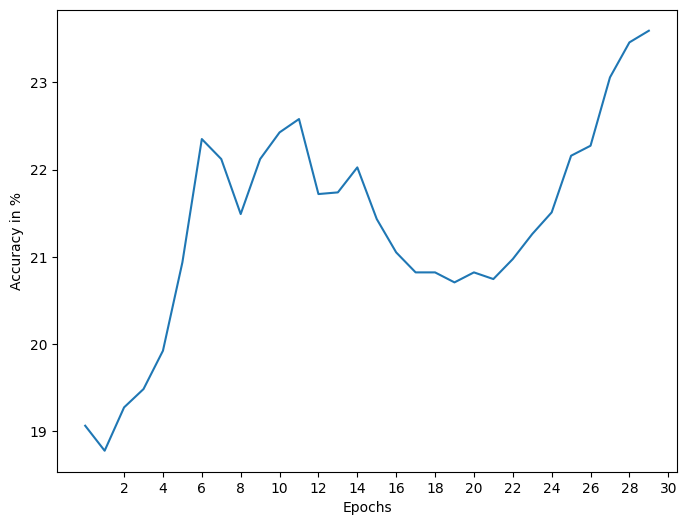

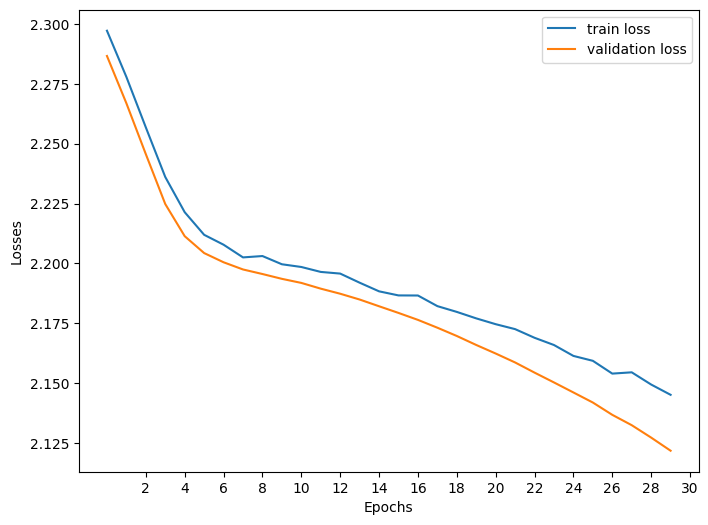

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:56<17:50, 56.36s/it]


epoch:   1, loss: 2.08211, valid loss: 1.85262, valid accruacy: 35.912%
Validation loss decreased (inf --> 1.852623). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:52<16:53, 56.31s/it]


epoch:   2, loss: 1.82324, valid loss: 1.64601, valid accruacy: 41.757%
Validation loss decreased (1.852623 --> 1.646007). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:49<15:59, 56.44s/it]


epoch:   3, loss: 1.69986, valid loss: 1.57930, valid accruacy: 43.897%
Validation loss decreased (1.646007 --> 1.579302). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:45<15:04, 56.55s/it]


epoch:   4, loss: 1.59624, valid loss: 1.48080, valid accruacy: 47.736%
Validation loss decreased (1.579302 --> 1.480799). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:42<14:10, 56.71s/it]


epoch:   5, loss: 1.53753, valid loss: 1.42263, valid accruacy: 51.098%
Validation loss decreased (1.480799 --> 1.422627). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:40<13:16, 56.89s/it]


epoch:   6, loss: 1.46787, valid loss: 1.38553, valid accruacy: 51.366%
Validation loss decreased (1.422627 --> 1.385534). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:37<12:23, 57.16s/it]


epoch:   7, loss: 1.41852, valid loss: 1.30719, valid accruacy: 55.263%
Validation loss decreased (1.385534 --> 1.307194). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:34<11:25, 57.08s/it]


epoch:   8, loss: 1.37312, valid loss: 1.27715, valid accruacy: 55.377%
Validation loss decreased (1.307194 --> 1.277149). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:31<10:27, 57.06s/it]


epoch:   9, loss: 1.32484, valid loss: 1.23405, valid accruacy: 57.268%
Validation loss decreased (1.277149 --> 1.234047). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:28<09:30, 57.07s/it]


epoch:  10, loss: 1.27176, valid loss: 1.19758, valid accruacy: 58.032%
Validation loss decreased (1.234047 --> 1.197584). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:26<08:34, 57.20s/it]


epoch:  11, loss: 1.24377, valid loss: 1.16354, valid accruacy: 60.840%
Validation loss decreased (1.197584 --> 1.163543). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:24<07:40, 57.55s/it]


epoch:  12, loss: 1.21407, valid loss: 1.15149, valid accruacy: 60.439%
Validation loss decreased (1.163543 --> 1.151488). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [12:22<06:43, 57.60s/it]


epoch:  13, loss: 1.17225, valid loss: 1.13954, valid accruacy: 61.203%
Validation loss decreased (1.151488 --> 1.139541). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [13:22<05:49, 58.20s/it]


epoch:  14, loss: 1.13629, valid loss: 1.06917, valid accruacy: 64.413%
Validation loss decreased (1.139541 --> 1.069167). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [14:19<04:50, 58.11s/it]


epoch:  15, loss: 1.09731, valid loss: 1.02688, valid accruacy: 65.712%
Validation loss decreased (1.069167 --> 1.026877). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [15:18<03:52, 58.10s/it]


epoch:  16, loss: 1.06334, valid loss: 1.01140, valid accruacy: 65.845%
Validation loss decreased (1.026877 --> 1.011399). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [16:15<02:53, 57.95s/it]


epoch:  17, loss: 1.02804, valid loss: 0.96985, valid accruacy: 67.870%
Validation loss decreased (1.011399 --> 0.969850). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [17:16<01:57, 58.77s/it]


epoch:  18, loss: 0.99868, valid loss: 0.94544, valid accruacy: 69.475%
Validation loss decreased (0.969850 --> 0.945438). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [18:15<00:58, 58.95s/it]


epoch:  19, loss: 0.97885, valid loss: 0.90676, valid accruacy: 70.086%
Validation loss decreased (0.945438 --> 0.906760). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:12<00:00, 57.64s/it]


epoch:  20, loss: 0.93784, valid loss: 0.89608, valid accruacy: 71.538%
Validation loss decreased (0.906760 --> 0.896081). Saving model...
Fit time: 1152.7903633117676 s


Test loss: 0.89874	Test accruacy: 71.592%
Saving model


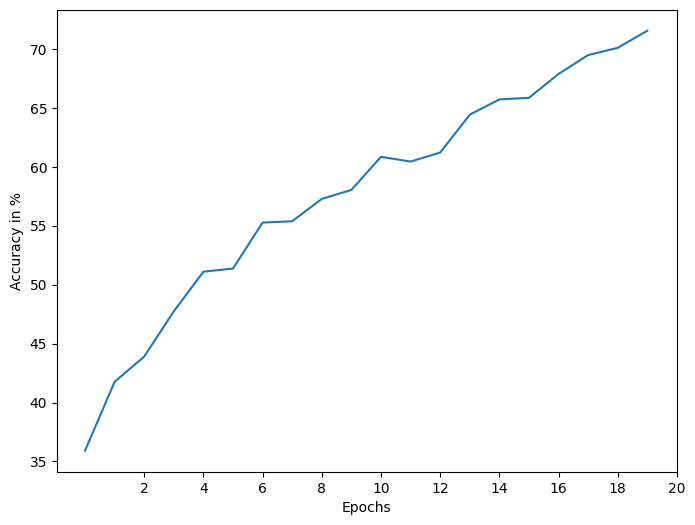

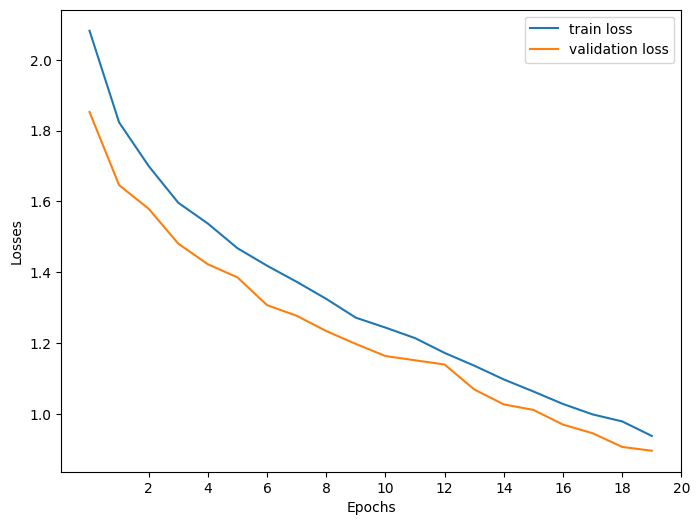

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:52<16:39, 52.63s/it]


epoch:   1, loss: 2.06476, valid loss: 1.85167, valid accruacy: 33.887%
Validation loss decreased (inf --> 1.851669). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:40<14:53, 49.65s/it]


epoch:   2, loss: 1.85640, valid loss: 1.73748, valid accruacy: 38.434%
Validation loss decreased (1.851669 --> 1.737476). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:28<13:53, 49.05s/it]


epoch:   3, loss: 1.74590, valid loss: 1.61372, valid accruacy: 42.732%
Validation loss decreased (1.737476 --> 1.613722). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:18<13:07, 49.22s/it]


epoch:   4, loss: 1.64840, valid loss: 1.50805, valid accruacy: 46.915%
Validation loss decreased (1.613722 --> 1.508046). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:08<12:23, 49.58s/it]


epoch:   5, loss: 1.57553, valid loss: 1.46487, valid accruacy: 49.704%
Validation loss decreased (1.508046 --> 1.464866). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [04:58<11:37, 49.82s/it]


epoch:   6, loss: 1.51257, valid loss: 1.39175, valid accruacy: 51.862%
Validation loss decreased (1.464866 --> 1.391746). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [05:49<10:53, 50.25s/it]


epoch:   7, loss: 1.46389, valid loss: 1.37675, valid accruacy: 53.391%
Validation loss decreased (1.391746 --> 1.376752). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [06:40<10:05, 50.44s/it]


epoch:   8, loss: 1.42150, valid loss: 1.29506, valid accruacy: 55.454%
Validation loss decreased (1.376752 --> 1.295058). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [07:31<09:16, 50.62s/it]


epoch:   9, loss: 1.37119, valid loss: 1.28491, valid accruacy: 56.313%
Validation loss decreased (1.295058 --> 1.284909). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [08:21<08:24, 50.47s/it]


epoch:  10, loss: 1.31994, valid loss: 1.20313, valid accruacy: 58.930%
Validation loss decreased (1.284909 --> 1.203130). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [09:12<07:33, 50.44s/it]


epoch:  11, loss: 1.27265, valid loss: 1.16587, valid accruacy: 60.611%
Validation loss decreased (1.203130 --> 1.165869). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [10:03<06:46, 50.85s/it]


epoch:  12, loss: 1.24056, valid loss: 1.12645, valid accruacy: 63.037%
Validation loss decreased (1.165869 --> 1.126454). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [10:55<05:56, 50.96s/it]


epoch:  13, loss: 1.20531, valid loss: 1.11255, valid accruacy: 62.464%
Validation loss decreased (1.126454 --> 1.112549). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [11:46<05:06, 51.04s/it]


epoch:  14, loss: 1.16420, valid loss: 1.06558, valid accruacy: 64.661%
Validation loss decreased (1.112549 --> 1.065578). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [12:36<04:14, 50.83s/it]


epoch:  15, loss: 1.12929, valid loss: 1.03511, valid accruacy: 66.266%
Validation loss decreased (1.065578 --> 1.035109). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [13:27<03:23, 50.82s/it]


epoch:  16, loss: 1.09219, valid loss: 1.03493, valid accruacy: 65.005%
Validation loss decreased (1.035109 --> 1.034928). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [14:17<02:31, 50.62s/it]


epoch:  17, loss: 1.05576, valid loss: 0.96509, valid accruacy: 69.169%
Validation loss decreased (1.034928 --> 0.965094). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [15:07<01:40, 50.45s/it]


epoch:  18, loss: 1.04344, valid loss: 0.94669, valid accruacy: 69.494%
Validation loss decreased (0.965094 --> 0.946689). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [15:59<00:50, 50.84s/it]


epoch:  19, loss: 1.00562, valid loss: 0.92142, valid accruacy: 70.277%
Validation loss decreased (0.946689 --> 0.921417). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [16:49<00:00, 50.49s/it]


epoch:  20, loss: 0.97403, valid loss: 0.89627, valid accruacy: 71.920%
Validation loss decreased (0.921417 --> 0.896268). Saving model...
Fit time: 1009.7777001857758 s


Test loss: 0.90870	Test accruacy: 71.134%
Saving model


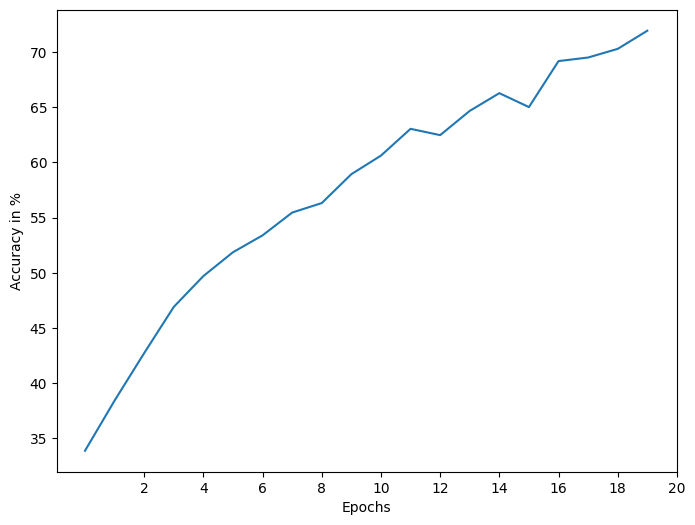

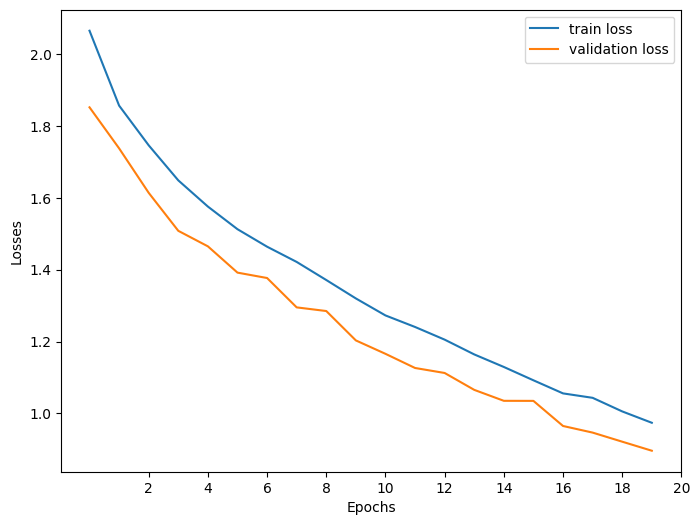

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:52<16:28, 52.01s/it]


epoch:   1, loss: 2.27441, valid loss: 2.23657, valid accruacy: 23.056%
Validation loss decreased (inf --> 2.236572). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:43<15:31, 51.76s/it]


epoch:   2, loss: 2.22391, valid loss: 2.20006, valid accruacy: 20.458%
Validation loss decreased (2.236572 --> 2.200058). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:33<14:28, 51.09s/it]


epoch:   3, loss: 2.20708, valid loss: 2.18556, valid accruacy: 22.350%
Validation loss decreased (2.200058 --> 2.185564). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:24<13:32, 50.80s/it]


epoch:   4, loss: 2.19750, valid loss: 2.17279, valid accruacy: 22.904%
Validation loss decreased (2.185564 --> 2.172793). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:15<12:42, 50.85s/it]


epoch:   5, loss: 2.18695, valid loss: 2.15289, valid accruacy: 24.050%
Validation loss decreased (2.172793 --> 2.152893). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:06<11:55, 51.11s/it]


epoch:   6, loss: 2.17040, valid loss: 2.13146, valid accruacy: 23.438%
Validation loss decreased (2.152893 --> 2.131464). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [05:57<11:04, 51.10s/it]


epoch:   7, loss: 2.15118, valid loss: 2.10194, valid accruacy: 26.476%
Validation loss decreased (2.131464 --> 2.101936). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [06:48<10:11, 50.99s/it]


epoch:   8, loss: 2.12808, valid loss: 2.06779, valid accruacy: 27.641%
Validation loss decreased (2.101936 --> 2.067791). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [07:40<09:23, 51.23s/it]


epoch:   9, loss: 2.10114, valid loss: 2.03430, valid accruacy: 28.940%
Validation loss decreased (2.067791 --> 2.034299). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [08:31<08:31, 51.11s/it]


epoch:  10, loss: 2.06954, valid loss: 1.99531, valid accruacy: 29.876%
Validation loss decreased (2.034299 --> 1.995311). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [09:21<07:38, 50.90s/it]


epoch:  11, loss: 2.03727, valid loss: 1.96179, valid accruacy: 30.506%
Validation loss decreased (1.995311 --> 1.961790). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [10:12<06:46, 50.82s/it]


epoch:  12, loss: 2.00931, valid loss: 1.93062, valid accruacy: 32.034%
Validation loss decreased (1.961790 --> 1.930620). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [11:03<05:56, 50.99s/it]


epoch:  13, loss: 1.98053, valid loss: 1.89235, valid accruacy: 33.066%
Validation loss decreased (1.930620 --> 1.892349). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [11:54<05:05, 50.99s/it]


epoch:  14, loss: 1.95523, valid loss: 1.87031, valid accruacy: 34.250%
Validation loss decreased (1.892349 --> 1.870309). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [12:45<04:14, 50.95s/it]


epoch:  15, loss: 1.93992, valid loss: 1.84720, valid accruacy: 35.224%
Validation loss decreased (1.870309 --> 1.847200). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [13:36<03:23, 50.98s/it]


epoch:  16, loss: 1.91692, valid loss: 1.82349, valid accruacy: 36.065%
Validation loss decreased (1.847200 --> 1.823490). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [14:27<02:32, 50.83s/it]


epoch:  17, loss: 1.89567, valid loss: 1.80641, valid accruacy: 36.371%
Validation loss decreased (1.823490 --> 1.806407). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [15:17<01:41, 50.65s/it]


epoch:  18, loss: 1.88463, valid loss: 1.80901, valid accruacy: 36.313%


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [16:08<00:50, 50.77s/it]


epoch:  19, loss: 1.87100, valid loss: 1.77935, valid accruacy: 37.364%
Validation loss decreased (1.806407 --> 1.779348). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [16:59<00:00, 50.96s/it]


epoch:  20, loss: 1.85310, valid loss: 1.76912, valid accruacy: 37.708%
Validation loss decreased (1.779348 --> 1.769116). Saving model...
Fit time: 1019.266619682312 s


Test loss: 1.81192	Test accruacy: 35.701%
Saving model


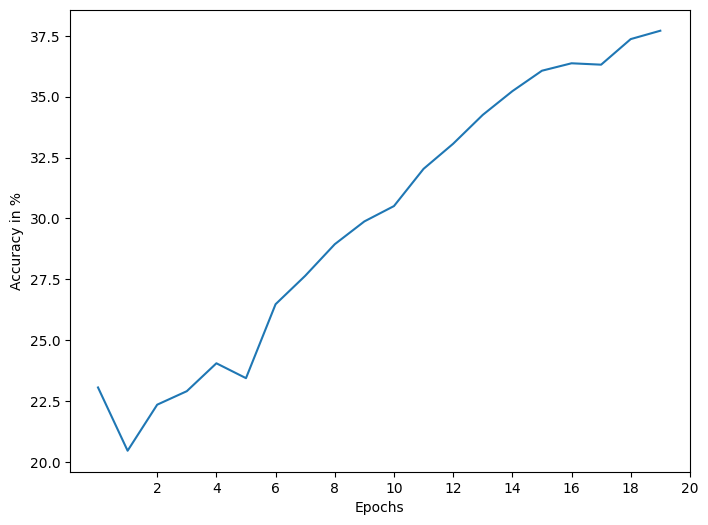

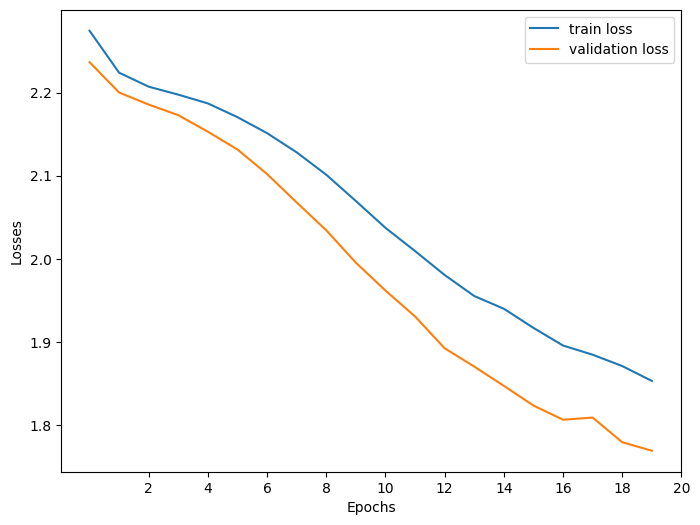

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:52<16:38, 52.57s/it]


epoch:   1, loss: 2.22013, valid loss: 2.16710, valid accruacy: 21.490%
Validation loss decreased (inf --> 2.167104). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:44<15:43, 52.40s/it]


epoch:   2, loss: 2.14709, valid loss: 2.06841, valid accruacy: 26.399%
Validation loss decreased (2.167104 --> 2.068405). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:36<14:44, 52.01s/it]


epoch:   3, loss: 2.06386, valid loss: 1.97467, valid accruacy: 30.372%
Validation loss decreased (2.068405 --> 1.974671). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:28<13:50, 51.88s/it]


epoch:   4, loss: 2.00370, valid loss: 1.92397, valid accruacy: 31.824%
Validation loss decreased (1.974671 --> 1.923965). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:19<12:55, 51.71s/it]


epoch:   5, loss: 1.96172, valid loss: 1.87720, valid accruacy: 33.964%
Validation loss decreased (1.923965 --> 1.877203). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:11<12:03, 51.67s/it]


epoch:   6, loss: 1.93317, valid loss: 1.84547, valid accruacy: 35.435%
Validation loss decreased (1.877203 --> 1.845467). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:04<11:18, 52.16s/it]


epoch:   7, loss: 1.89789, valid loss: 1.81473, valid accruacy: 36.867%
Validation loss decreased (1.845467 --> 1.814732). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [06:56<10:28, 52.34s/it]


epoch:   8, loss: 1.87457, valid loss: 1.78530, valid accruacy: 37.020%
Validation loss decreased (1.814732 --> 1.785299). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [07:49<09:36, 52.37s/it]


epoch:   9, loss: 1.85238, valid loss: 1.77129, valid accruacy: 37.918%
Validation loss decreased (1.785299 --> 1.771286). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [08:40<08:41, 52.11s/it]


epoch:  10, loss: 1.83544, valid loss: 1.74958, valid accruacy: 38.319%
Validation loss decreased (1.771286 --> 1.749579). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [09:32<07:47, 51.96s/it]


epoch:  11, loss: 1.81667, valid loss: 1.73590, valid accruacy: 38.701%
Validation loss decreased (1.749579 --> 1.735898). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [10:26<07:01, 52.65s/it]


epoch:  12, loss: 1.80489, valid loss: 1.71557, valid accruacy: 39.771%
Validation loss decreased (1.735898 --> 1.715571). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [11:25<06:20, 54.37s/it]


epoch:  13, loss: 1.78753, valid loss: 1.70542, valid accruacy: 39.503%
Validation loss decreased (1.715571 --> 1.705421). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [12:17<05:22, 53.76s/it]


epoch:  14, loss: 1.78105, valid loss: 1.69252, valid accruacy: 39.694%
Validation loss decreased (1.705421 --> 1.692515). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [13:09<04:26, 53.26s/it]


epoch:  15, loss: 1.75978, valid loss: 1.67628, valid accruacy: 41.566%
Validation loss decreased (1.692515 --> 1.676275). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [14:02<03:32, 53.09s/it]


epoch:  16, loss: 1.75171, valid loss: 1.66647, valid accruacy: 41.796%
Validation loss decreased (1.676275 --> 1.666471). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [14:56<02:40, 53.36s/it]


epoch:  17, loss: 1.73671, valid loss: 1.66080, valid accruacy: 42.178%
Validation loss decreased (1.666471 --> 1.660805). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [15:52<01:48, 54.15s/it]


epoch:  18, loss: 1.72171, valid loss: 1.63040, valid accruacy: 42.483%
Validation loss decreased (1.660805 --> 1.630400). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [16:47<00:54, 54.55s/it]


epoch:  19, loss: 1.71350, valid loss: 1.63043, valid accruacy: 43.056%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [17:45<00:00, 53.28s/it]


epoch:  20, loss: 1.70024, valid loss: 1.62175, valid accruacy: 43.725%
Validation loss decreased (1.630400 --> 1.621745). Saving model...
Fit time: 1065.532551765442 s


Test loss: 1.59979	Test accruacy: 44.177%
Saving model


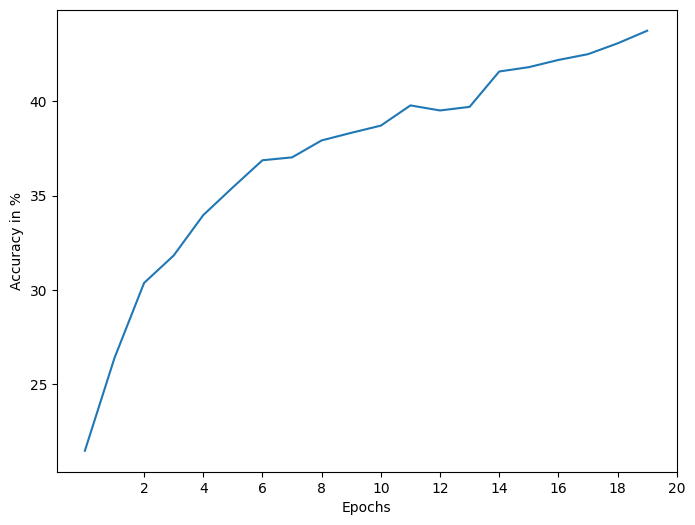

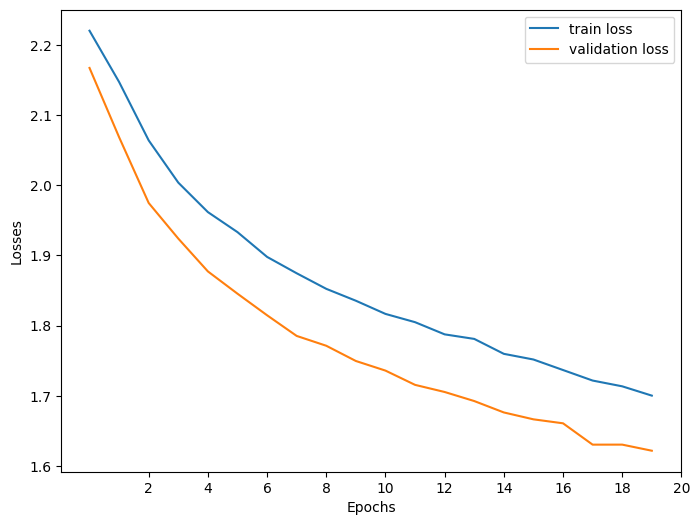

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:55<17:28, 55.17s/it]


epoch:   1, loss: 2.21982, valid loss: 2.16903, valid accruacy: 21.165%
Validation loss decreased (inf --> 2.169027). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:50<16:36, 55.37s/it]


epoch:   2, loss: 2.14994, valid loss: 2.06805, valid accruacy: 27.813%
Validation loss decreased (2.169027 --> 2.068054). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:50<16:12, 57.20s/it]


epoch:   3, loss: 2.07224, valid loss: 1.97571, valid accruacy: 32.531%
Validation loss decreased (2.068054 --> 1.975710). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:44<15:00, 56.27s/it]


epoch:   4, loss: 2.00308, valid loss: 1.91254, valid accruacy: 34.441%
Validation loss decreased (1.975710 --> 1.912539). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:47<14:37, 58.51s/it]


epoch:   5, loss: 1.95752, valid loss: 1.86971, valid accruacy: 35.587%
Validation loss decreased (1.912539 --> 1.869715). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:42<13:22, 57.32s/it]


epoch:   6, loss: 1.91797, valid loss: 1.82711, valid accruacy: 36.256%
Validation loss decreased (1.869715 --> 1.827109). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:39<12:23, 57.16s/it]


epoch:   7, loss: 1.88774, valid loss: 1.80520, valid accruacy: 37.001%
Validation loss decreased (1.827109 --> 1.805199). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:43<11:53, 59.46s/it]


epoch:   8, loss: 1.86181, valid loss: 1.77877, valid accruacy: 37.287%
Validation loss decreased (1.805199 --> 1.778773). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:46<11:04, 60.42s/it]


epoch:   9, loss: 1.84494, valid loss: 1.75985, valid accruacy: 38.185%
Validation loss decreased (1.778773 --> 1.759848). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:41<09:49, 58.92s/it]


epoch:  10, loss: 1.82393, valid loss: 1.73737, valid accruacy: 39.389%
Validation loss decreased (1.759848 --> 1.737371). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:38<08:43, 58.16s/it]


epoch:  11, loss: 1.80096, valid loss: 1.71267, valid accruacy: 40.172%
Validation loss decreased (1.737371 --> 1.712671). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:35<07:42, 57.87s/it]


epoch:  12, loss: 1.78262, valid loss: 1.70537, valid accruacy: 40.783%
Validation loss decreased (1.712671 --> 1.705374). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [12:25<06:28, 55.48s/it]


epoch:  13, loss: 1.76492, valid loss: 1.68199, valid accruacy: 41.223%
Validation loss decreased (1.705374 --> 1.681991). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [13:13<05:19, 53.21s/it]


epoch:  14, loss: 1.75737, valid loss: 1.66988, valid accruacy: 41.184%
Validation loss decreased (1.681991 --> 1.669881). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [14:09<04:31, 54.24s/it]


epoch:  15, loss: 1.74175, valid loss: 1.65085, valid accruacy: 41.719%
Validation loss decreased (1.669881 --> 1.650849). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [15:06<03:39, 54.96s/it]


epoch:  16, loss: 1.72631, valid loss: 1.63474, valid accruacy: 41.987%
Validation loss decreased (1.650849 --> 1.634741). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [16:02<02:46, 55.39s/it]


epoch:  17, loss: 1.71546, valid loss: 1.62754, valid accruacy: 42.483%
Validation loss decreased (1.634741 --> 1.627540). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [17:00<01:51, 55.91s/it]


epoch:  18, loss: 1.70463, valid loss: 1.61096, valid accruacy: 42.999%
Validation loss decreased (1.627540 --> 1.610960). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [17:56<00:56, 56.15s/it]


epoch:  19, loss: 1.68899, valid loss: 1.60181, valid accruacy: 43.591%
Validation loss decreased (1.610960 --> 1.601809). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [18:54<00:00, 56.72s/it]


epoch:  20, loss: 1.67980, valid loss: 1.58867, valid accruacy: 44.298%
Validation loss decreased (1.601809 --> 1.588672). Saving model...
Fit time: 1134.391120672226 s


Test loss: 1.62486	Test accruacy: 42.383%
Saving model


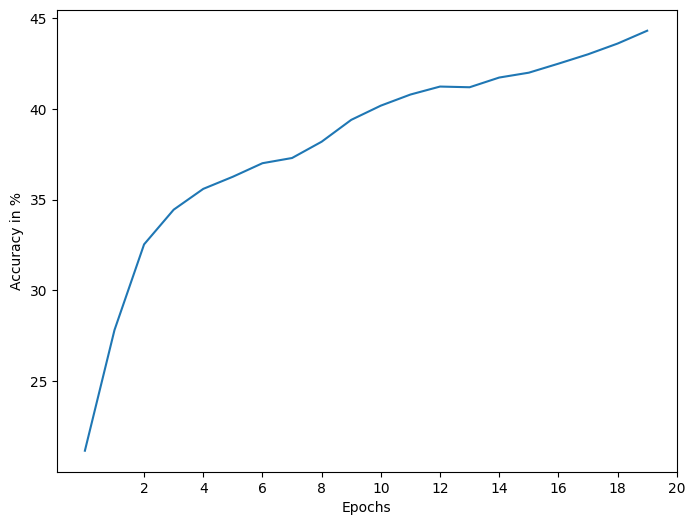

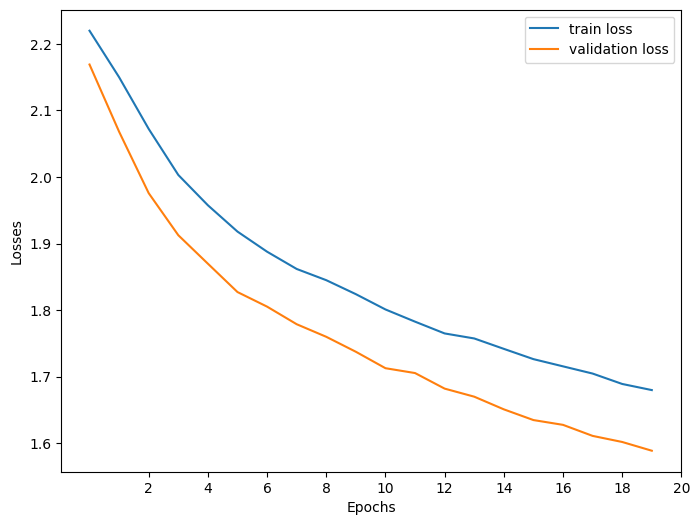

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:56<17:57, 56.70s/it]


epoch:   1, loss: 2.30316, valid loss: 2.29799, valid accruacy: 18.567%
Validation loss decreased (inf --> 2.297985). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:53<16:57, 56.50s/it]


epoch:   2, loss: 2.29452, valid loss: 2.28936, valid accruacy: 18.567%
Validation loss decreased (2.297985 --> 2.289362). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:50<16:09, 57.02s/it]


epoch:   3, loss: 2.28698, valid loss: 2.28144, valid accruacy: 18.567%
Validation loss decreased (2.289362 --> 2.281442). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:52<15:40, 58.80s/it]


epoch:   4, loss: 2.27968, valid loss: 2.27413, valid accruacy: 18.567%
Validation loss decreased (2.281442 --> 2.274130). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:54<14:58, 59.87s/it]


epoch:   5, loss: 2.27336, valid loss: 2.26728, valid accruacy: 18.567%
Validation loss decreased (2.274130 --> 2.267279). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:54<14:01, 60.09s/it]


epoch:   6, loss: 2.26709, valid loss: 2.26083, valid accruacy: 18.567%
Validation loss decreased (2.267279 --> 2.260831). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:50<12:43, 58.77s/it]


epoch:   7, loss: 2.26121, valid loss: 2.25477, valid accruacy: 18.567%
Validation loss decreased (2.260831 --> 2.254765). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:50<11:48, 59.01s/it]


epoch:   8, loss: 2.25591, valid loss: 2.24896, valid accruacy: 18.567%
Validation loss decreased (2.254765 --> 2.248957). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:45<10:36, 57.90s/it]


epoch:   9, loss: 2.25052, valid loss: 2.24325, valid accruacy: 18.567%
Validation loss decreased (2.248957 --> 2.243246). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:42<09:35, 57.59s/it]


epoch:  10, loss: 2.24545, valid loss: 2.23776, valid accruacy: 18.567%
Validation loss decreased (2.243246 --> 2.237755). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:41<08:41, 57.96s/it]


epoch:  11, loss: 2.24070, valid loss: 2.23222, valid accruacy: 18.567%
Validation loss decreased (2.237755 --> 2.232216). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:38<07:42, 57.86s/it]


epoch:  12, loss: 2.23556, valid loss: 2.22668, valid accruacy: 18.739%
Validation loss decreased (2.232216 --> 2.226677). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [12:35<06:42, 57.48s/it]


epoch:  13, loss: 2.23029, valid loss: 2.22102, valid accruacy: 19.293%
Validation loss decreased (2.226677 --> 2.221022). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [13:36<05:50, 58.48s/it]


epoch:  14, loss: 2.22655, valid loss: 2.21534, valid accruacy: 20.306%
Validation loss decreased (2.221022 --> 2.215339). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [14:35<04:53, 58.69s/it]


epoch:  15, loss: 2.22122, valid loss: 2.20954, valid accruacy: 21.452%
Validation loss decreased (2.215339 --> 2.209535). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [15:31<03:51, 57.97s/it]


epoch:  16, loss: 2.21636, valid loss: 2.20398, valid accruacy: 22.464%
Validation loss decreased (2.209535 --> 2.203977). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [16:28<02:52, 57.57s/it]


epoch:  17, loss: 2.21174, valid loss: 2.19877, valid accruacy: 22.884%
Validation loss decreased (2.203977 --> 2.198767). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [17:25<01:54, 57.47s/it]


epoch:  18, loss: 2.20938, valid loss: 2.19468, valid accruacy: 22.732%
Validation loss decreased (2.198767 --> 2.194677). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [18:22<00:57, 57.34s/it]


epoch:  19, loss: 2.20518, valid loss: 2.19113, valid accruacy: 22.789%
Validation loss decreased (2.194677 --> 2.191129). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:23<00:00, 58.18s/it]


epoch:  20, loss: 2.20364, valid loss: 2.18849, valid accruacy: 22.827%
Validation loss decreased (2.191129 --> 2.188491). Saving model...
Fit time: 1163.5222244262695 s


Test loss: 2.19807	Test accruacy: 22.337%
Saving model


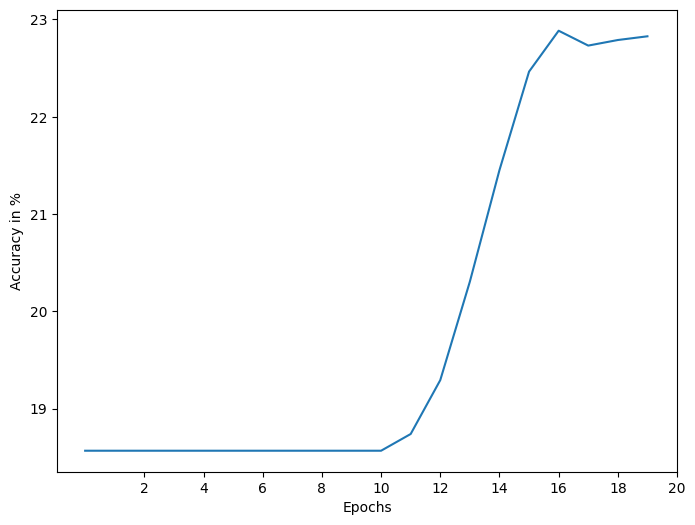

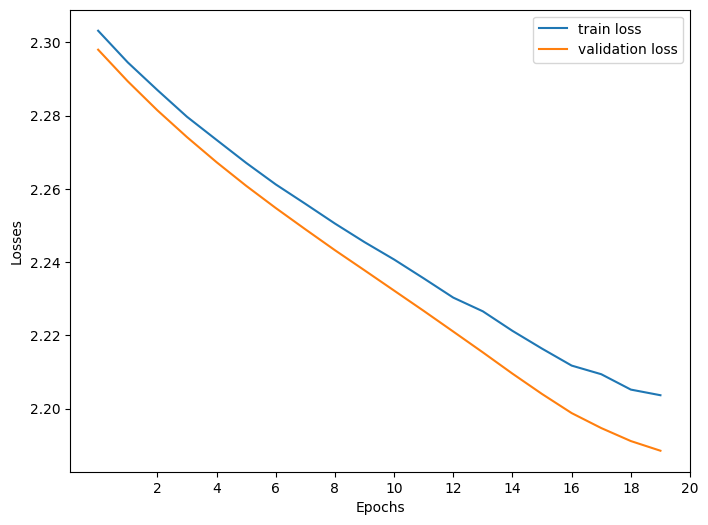

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [01:01<29:47, 61.65s/it]


epoch:   1, loss: 2.09100, valid loss: 1.89966, valid accruacy: 34.155%
Validation loss decreased (inf --> 1.899656). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [02:00<27:54, 59.82s/it]


epoch:   2, loss: 1.86451, valid loss: 1.71318, valid accruacy: 40.325%
Validation loss decreased (1.899656 --> 1.713184). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:58<26:33, 59.02s/it]


epoch:   3, loss: 1.73542, valid loss: 1.59598, valid accruacy: 44.947%
Validation loss decreased (1.713184 --> 1.595976). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:59<26:00, 60.04s/it]


epoch:   4, loss: 1.64032, valid loss: 1.51310, valid accruacy: 47.373%
Validation loss decreased (1.595976 --> 1.513103). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:58<24:45, 59.41s/it]


epoch:   5, loss: 1.56376, valid loss: 1.47765, valid accruacy: 48.711%
Validation loss decreased (1.513103 --> 1.477647). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [06:00<24:10, 60.44s/it]


epoch:   6, loss: 1.50504, valid loss: 1.40694, valid accruacy: 50.946%
Validation loss decreased (1.477647 --> 1.406944). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:59<23:00, 60.03s/it]


epoch:   7, loss: 1.45743, valid loss: 1.34030, valid accruacy: 53.601%
Validation loss decreased (1.406944 --> 1.340297). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:57<21:46, 59.37s/it]


epoch:   8, loss: 1.40136, valid loss: 1.28942, valid accruacy: 55.989%
Validation loss decreased (1.340297 --> 1.289418). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [09:04<21:38, 61.83s/it]


epoch:   9, loss: 1.36051, valid loss: 1.24428, valid accruacy: 57.268%
Validation loss decreased (1.289418 --> 1.244277). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [10:07<20:40, 62.03s/it]


epoch:  10, loss: 1.31514, valid loss: 1.20310, valid accruacy: 59.389%
Validation loss decreased (1.244277 --> 1.203104). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:51<17:54, 56.53s/it]


epoch:  11, loss: 1.27431, valid loss: 1.16031, valid accruacy: 61.337%
Validation loss decreased (1.203104 --> 1.160314). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:36<15:54, 53.02s/it]


epoch:  12, loss: 1.23793, valid loss: 1.17157, valid accruacy: 60.707%


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:21<14:21, 50.68s/it]


epoch:  13, loss: 1.21826, valid loss: 1.10276, valid accruacy: 63.954%
Validation loss decreased (1.160314 --> 1.102759). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:09<13:17, 49.87s/it]


epoch:  14, loss: 1.17251, valid loss: 1.05925, valid accruacy: 64.642%
Validation loss decreased (1.102759 --> 1.059249). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [13:55<12:10, 48.69s/it]


epoch:  15, loss: 1.13591, valid loss: 1.04016, valid accruacy: 65.310%
Validation loss decreased (1.059249 --> 1.040165). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [14:42<11:12, 48.03s/it]


epoch:  16, loss: 1.09556, valid loss: 0.99803, valid accruacy: 67.450%
Validation loss decreased (1.040165 --> 0.998029). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [15:38<10:56, 50.47s/it]


epoch:  17, loss: 1.06902, valid loss: 0.97593, valid accruacy: 68.080%
Validation loss decreased (0.998029 --> 0.975931). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [16:40<10:46, 53.90s/it]


epoch:  18, loss: 1.04053, valid loss: 0.94345, valid accruacy: 69.494%
Validation loss decreased (0.975931 --> 0.943455). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [17:30<09:41, 52.85s/it]


epoch:  19, loss: 1.01017, valid loss: 0.91582, valid accruacy: 70.946%
Validation loss decreased (0.943455 --> 0.915819). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [18:18<08:34, 51.48s/it]


epoch:  20, loss: 0.98763, valid loss: 0.90171, valid accruacy: 70.926%
Validation loss decreased (0.915819 --> 0.901711). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [19:03<07:24, 49.34s/it]


epoch:  21, loss: 0.95156, valid loss: 0.91972, valid accruacy: 70.678%


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [19:48<06:25, 48.21s/it]


epoch:  22, loss: 0.93589, valid loss: 0.85172, valid accruacy: 73.429%
Validation loss decreased (0.901711 --> 0.851722). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [20:36<05:36, 48.06s/it]


epoch:  23, loss: 0.89365, valid loss: 0.85161, valid accruacy: 73.467%
Validation loss decreased (0.851722 --> 0.851606). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [21:23<04:45, 47.56s/it]


epoch:  24, loss: 0.87247, valid loss: 0.84032, valid accruacy: 74.078%
Validation loss decreased (0.851606 --> 0.840321). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [22:09<03:55, 47.20s/it]


epoch:  25, loss: 0.85939, valid loss: 0.83323, valid accruacy: 74.002%
Validation loss decreased (0.840321 --> 0.833234). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [22:57<03:09, 47.41s/it]


epoch:  26, loss: 0.84152, valid loss: 0.80395, valid accruacy: 75.320%
Validation loss decreased (0.833234 --> 0.803945). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [23:45<02:23, 47.80s/it]


epoch:  27, loss: 0.82401, valid loss: 0.80486, valid accruacy: 75.931%


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [24:33<01:35, 47.83s/it]


epoch:  28, loss: 0.80376, valid loss: 0.77407, valid accruacy: 77.345%
Validation loss decreased (0.803945 --> 0.774068). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [25:21<00:47, 47.77s/it]


epoch:  29, loss: 0.78152, valid loss: 0.78440, valid accruacy: 76.772%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [26:08<00:00, 52.28s/it]


epoch:  30, loss: 0.75772, valid loss: 0.75328, valid accruacy: 78.395%
Validation loss decreased (0.774068 --> 0.753278). Saving model...
Fit time: 1568.4319877624512 s


Test loss: 0.81105	Test accruacy: 76.365%
Saving model


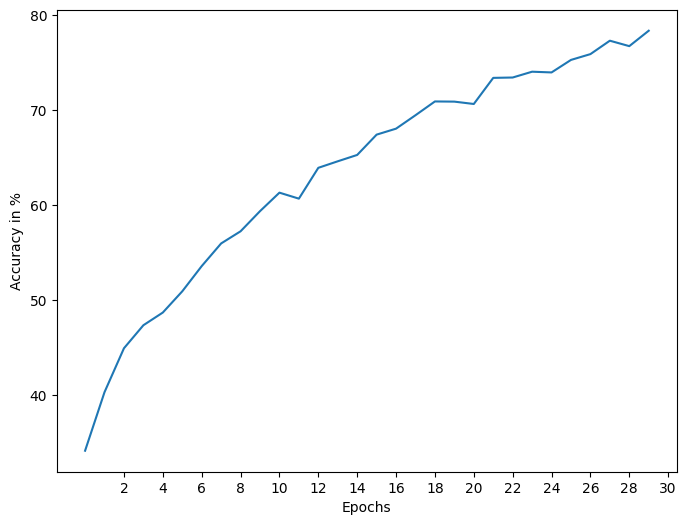

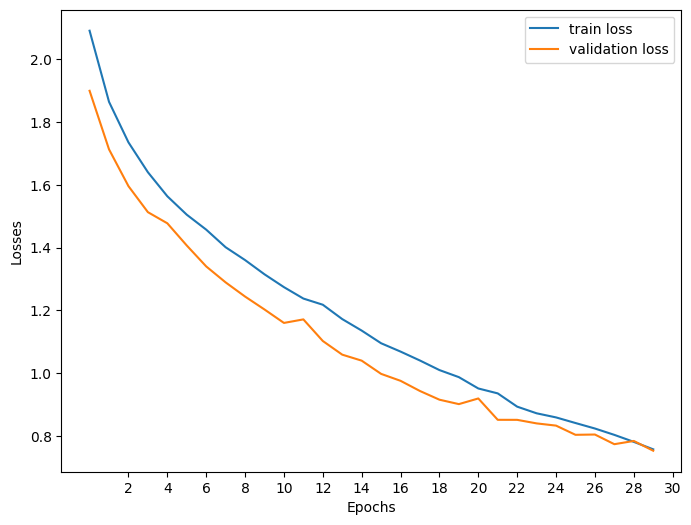

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [00:47<23:08, 47.89s/it]


epoch:   1, loss: 2.08360, valid loss: 1.86541, valid accruacy: 33.639%
Validation loss decreased (inf --> 1.865409). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [01:36<22:25, 48.07s/it]


epoch:   2, loss: 1.85165, valid loss: 1.74756, valid accruacy: 39.121%
Validation loss decreased (1.865409 --> 1.747557). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:23<21:33, 47.90s/it]


epoch:   3, loss: 1.73012, valid loss: 1.60790, valid accruacy: 43.362%
Validation loss decreased (1.747557 --> 1.607898). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:12<20:54, 48.24s/it]


epoch:   4, loss: 1.63608, valid loss: 1.50793, valid accruacy: 47.507%
Validation loss decreased (1.607898 --> 1.507928). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:00<20:06, 48.24s/it]


epoch:   5, loss: 1.57026, valid loss: 1.44232, valid accruacy: 50.048%
Validation loss decreased (1.507928 --> 1.442318). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [04:48<19:13, 48.05s/it]


epoch:   6, loss: 1.51675, valid loss: 1.39883, valid accruacy: 51.614%
Validation loss decreased (1.442318 --> 1.398833). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [05:36<18:23, 47.96s/it]


epoch:   7, loss: 1.45785, valid loss: 1.32989, valid accruacy: 54.231%
Validation loss decreased (1.398833 --> 1.329886). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [06:24<17:34, 47.92s/it]


epoch:   8, loss: 1.40927, valid loss: 1.28144, valid accruacy: 55.836%
Validation loss decreased (1.329886 --> 1.281440). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [07:12<16:49, 48.08s/it]


epoch:   9, loss: 1.37162, valid loss: 1.24228, valid accruacy: 56.944%
Validation loss decreased (1.281440 --> 1.242284). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [08:00<16:03, 48.16s/it]


epoch:  10, loss: 1.31747, valid loss: 1.21227, valid accruacy: 58.739%
Validation loss decreased (1.242284 --> 1.212270). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [08:48<15:12, 48.01s/it]


epoch:  11, loss: 1.28905, valid loss: 1.17853, valid accruacy: 59.962%
Validation loss decreased (1.212270 --> 1.178530). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [09:38<14:34, 48.60s/it]


epoch:  12, loss: 1.24472, valid loss: 1.12143, valid accruacy: 62.483%
Validation loss decreased (1.178530 --> 1.121426). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [10:26<13:44, 48.53s/it]


epoch:  13, loss: 1.21893, valid loss: 1.10916, valid accruacy: 62.789%
Validation loss decreased (1.121426 --> 1.109160). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [11:15<12:55, 48.45s/it]


epoch:  14, loss: 1.16528, valid loss: 1.06772, valid accruacy: 63.878%
Validation loss decreased (1.109160 --> 1.067719). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [12:03<12:08, 48.55s/it]


epoch:  15, loss: 1.13568, valid loss: 1.04083, valid accruacy: 65.845%
Validation loss decreased (1.067719 --> 1.040829). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [12:50<11:12, 48.04s/it]


epoch:  16, loss: 1.10007, valid loss: 0.99854, valid accruacy: 67.278%
Validation loss decreased (1.040829 --> 0.998543). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [13:38<10:21, 47.81s/it]


epoch:  17, loss: 1.06774, valid loss: 0.98020, valid accruacy: 68.367%
Validation loss decreased (0.998543 --> 0.980202). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [14:31<09:54, 49.54s/it]


epoch:  18, loss: 1.03961, valid loss: 0.95343, valid accruacy: 68.863%
Validation loss decreased (0.980202 --> 0.953425). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [15:33<09:45, 53.23s/it]


epoch:  19, loss: 0.99651, valid loss: 0.92888, valid accruacy: 69.704%
Validation loss decreased (0.953425 --> 0.928878). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [16:26<08:52, 53.23s/it]


epoch:  20, loss: 0.97250, valid loss: 0.89066, valid accruacy: 70.926%
Validation loss decreased (0.928878 --> 0.890663). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [17:20<08:00, 53.44s/it]


epoch:  21, loss: 0.93345, valid loss: 0.86949, valid accruacy: 72.092%
Validation loss decreased (0.890663 --> 0.869490). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [18:14<07:08, 53.50s/it]


epoch:  22, loss: 0.91811, valid loss: 0.85504, valid accruacy: 72.646%
Validation loss decreased (0.869490 --> 0.855041). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [19:04<06:06, 52.43s/it]


epoch:  23, loss: 0.88622, valid loss: 0.84005, valid accruacy: 73.811%
Validation loss decreased (0.855041 --> 0.840055). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [19:51<05:05, 50.84s/it]


epoch:  24, loss: 0.85918, valid loss: 0.81510, valid accruacy: 74.919%
Validation loss decreased (0.840055 --> 0.815095). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [20:47<04:22, 52.55s/it]


epoch:  25, loss: 0.83011, valid loss: 0.79306, valid accruacy: 75.606%
Validation loss decreased (0.815095 --> 0.793065). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [21:36<03:26, 51.51s/it]


epoch:  26, loss: 0.81441, valid loss: 0.83236, valid accruacy: 75.072%


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [22:25<02:31, 50.55s/it]


epoch:  27, loss: 0.79847, valid loss: 0.76000, valid accruacy: 77.307%
Validation loss decreased (0.793065 --> 0.760002). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [23:14<01:40, 50.17s/it]


epoch:  28, loss: 0.76431, valid loss: 0.75444, valid accruacy: 78.223%
Validation loss decreased (0.760002 --> 0.754439). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [24:04<00:50, 50.01s/it]


epoch:  29, loss: 0.75012, valid loss: 0.74871, valid accruacy: 78.567%
Validation loss decreased (0.754439 --> 0.748707). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [24:57<00:00, 49.92s/it]


epoch:  30, loss: 0.74144, valid loss: 0.73123, valid accruacy: 79.160%
Validation loss decreased (0.748707 --> 0.731226). Saving model...
Fit time: 1497.5560760498047 s


Test loss: 0.77441	Test accruacy: 78.236%
Saving model


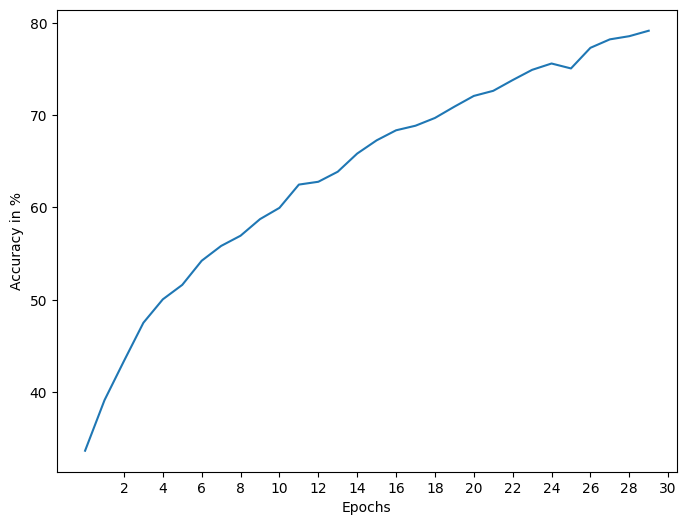

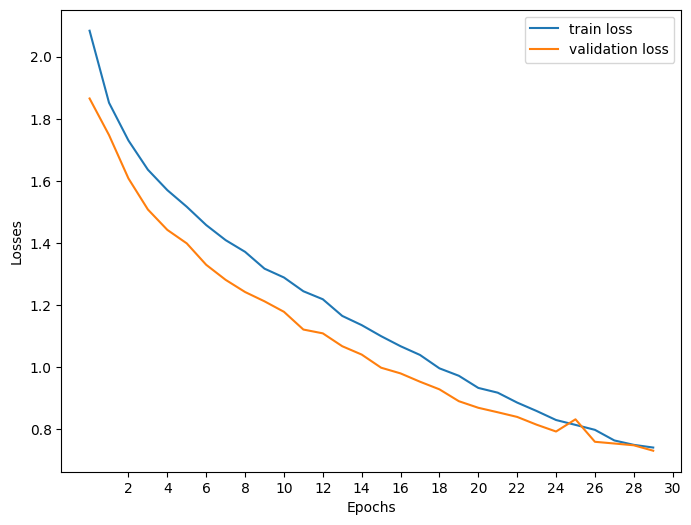

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [00:53<26:05, 53.98s/it]


epoch:   1, loss: 2.25573, valid loss: 2.22337, valid accruacy: 18.529%
Validation loss decreased (inf --> 2.223373). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [01:53<26:36, 57.03s/it]


epoch:   2, loss: 2.21474, valid loss: 2.19797, valid accruacy: 18.586%
Validation loss decreased (2.223373 --> 2.197971). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:50<25:48, 57.37s/it]


epoch:   3, loss: 2.20147, valid loss: 2.18614, valid accruacy: 23.687%
Validation loss decreased (2.197971 --> 2.186140). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:48<24:55, 57.53s/it]


epoch:   4, loss: 2.18805, valid loss: 2.17125, valid accruacy: 23.018%
Validation loss decreased (2.186140 --> 2.171254). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:46<23:56, 57.47s/it]


epoch:   5, loss: 2.17232, valid loss: 2.15185, valid accruacy: 23.362%
Validation loss decreased (2.171254 --> 2.151855). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [05:44<23:05, 57.75s/it]


epoch:   6, loss: 2.15589, valid loss: 2.12957, valid accruacy: 24.164%
Validation loss decreased (2.151855 --> 2.129571). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:42<22:10, 57.87s/it]


epoch:   7, loss: 2.13307, valid loss: 2.10643, valid accruacy: 24.890%
Validation loss decreased (2.129571 --> 2.106428). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:39<21:10, 57.76s/it]


epoch:   8, loss: 2.11391, valid loss: 2.08474, valid accruacy: 25.444%
Validation loss decreased (2.106428 --> 2.084742). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:37<20:11, 57.69s/it]


epoch:   9, loss: 2.09825, valid loss: 2.06230, valid accruacy: 26.781%
Validation loss decreased (2.084742 --> 2.062300). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:35<19:17, 57.89s/it]


epoch:  10, loss: 2.07845, valid loss: 2.04013, valid accruacy: 27.927%
Validation loss decreased (2.062300 --> 2.040133). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:40<18:59, 59.99s/it]


epoch:  11, loss: 2.05587, valid loss: 2.01210, valid accruacy: 28.749%
Validation loss decreased (2.040133 --> 2.012100). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:39<17:56, 59.80s/it]


epoch:  12, loss: 2.03256, valid loss: 1.98261, valid accruacy: 30.525%
Validation loss decreased (2.012100 --> 1.982607). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:38<16:47, 59.26s/it]


epoch:  13, loss: 2.00521, valid loss: 1.94572, valid accruacy: 31.251%
Validation loss decreased (1.982607 --> 1.945725). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:35<15:42, 58.88s/it]


epoch:  14, loss: 1.98837, valid loss: 1.92911, valid accruacy: 31.232%
Validation loss decreased (1.945725 --> 1.929106). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [14:34<14:39, 58.65s/it]


epoch:  15, loss: 1.96333, valid loss: 1.90667, valid accruacy: 33.161%
Validation loss decreased (1.929106 --> 1.906668). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [15:32<13:39, 58.51s/it]


epoch:  16, loss: 1.95212, valid loss: 1.89147, valid accruacy: 33.926%
Validation loss decreased (1.906668 --> 1.891466). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [16:29<12:36, 58.22s/it]


epoch:  17, loss: 1.93436, valid loss: 1.87364, valid accruacy: 33.926%
Validation loss decreased (1.891466 --> 1.873643). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [17:27<11:36, 58.04s/it]


epoch:  18, loss: 1.91455, valid loss: 1.85586, valid accruacy: 34.594%
Validation loss decreased (1.873643 --> 1.855864). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [18:25<10:38, 58.05s/it]


epoch:  19, loss: 1.89974, valid loss: 1.84172, valid accruacy: 34.308%
Validation loss decreased (1.855864 --> 1.841717). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [19:23<09:41, 58.17s/it]


epoch:  20, loss: 1.88725, valid loss: 1.83887, valid accruacy: 34.518%
Validation loss decreased (1.841717 --> 1.838874). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [20:22<08:43, 58.20s/it]


epoch:  21, loss: 1.87386, valid loss: 1.81388, valid accruacy: 35.549%
Validation loss decreased (1.838874 --> 1.813884). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [21:20<07:45, 58.24s/it]


epoch:  22, loss: 1.86024, valid loss: 1.79736, valid accruacy: 36.065%
Validation loss decreased (1.813884 --> 1.797363). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [22:18<06:47, 58.25s/it]


epoch:  23, loss: 1.84489, valid loss: 1.78441, valid accruacy: 36.810%
Validation loss decreased (1.797363 --> 1.784407). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [23:17<05:50, 58.43s/it]


epoch:  24, loss: 1.83366, valid loss: 1.76743, valid accruacy: 37.880%
Validation loss decreased (1.784407 --> 1.767425). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [24:16<04:53, 58.63s/it]


epoch:  25, loss: 1.82124, valid loss: 1.75522, valid accruacy: 38.013%
Validation loss decreased (1.767425 --> 1.755218). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [25:15<03:54, 58.71s/it]


epoch:  26, loss: 1.81128, valid loss: 1.74736, valid accruacy: 38.090%
Validation loss decreased (1.755218 --> 1.747356). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [26:14<02:56, 58.67s/it]


epoch:  27, loss: 1.79712, valid loss: 1.73348, valid accruacy: 38.816%
Validation loss decreased (1.747356 --> 1.733479). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [27:12<01:57, 58.56s/it]


epoch:  28, loss: 1.78696, valid loss: 1.72065, valid accruacy: 39.694%
Validation loss decreased (1.733479 --> 1.720654). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [28:11<00:58, 58.57s/it]


epoch:  29, loss: 1.77427, valid loss: 1.71400, valid accruacy: 39.484%
Validation loss decreased (1.720654 --> 1.714001). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [29:10<00:00, 58.35s/it]


epoch:  30, loss: 1.75931, valid loss: 1.69334, valid accruacy: 40.344%
Validation loss decreased (1.714001 --> 1.693342). Saving model...
Fit time: 1750.3588485717773 s


Test loss: 1.65810	Test accruacy: 41.466%
Saving model


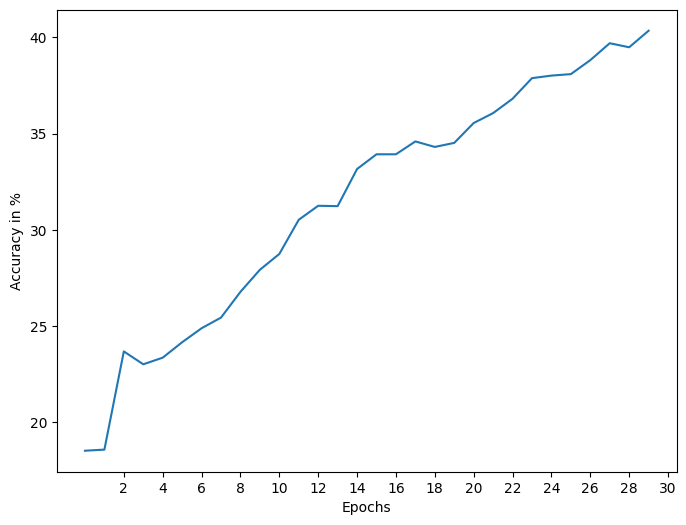

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [00:59<28:35, 59.15s/it]


epoch:   1, loss: 2.22254, valid loss: 2.17162, valid accruacy: 22.770%
Validation loss decreased (inf --> 2.171621). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [01:57<27:25, 58.76s/it]


epoch:   2, loss: 2.14292, valid loss: 2.06696, valid accruacy: 28.118%
Validation loss decreased (2.171621 --> 2.066960). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:57<26:40, 59.27s/it]


epoch:   3, loss: 2.06080, valid loss: 2.00505, valid accruacy: 29.532%
Validation loss decreased (2.066960 --> 2.005054). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:57<25:46, 59.47s/it]


epoch:   4, loss: 2.00026, valid loss: 1.93173, valid accruacy: 32.512%
Validation loss decreased (2.005054 --> 1.931734). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:56<24:40, 59.22s/it]


epoch:   5, loss: 1.96018, valid loss: 1.88200, valid accruacy: 34.308%
Validation loss decreased (1.931734 --> 1.881996). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [05:54<23:36, 59.00s/it]


epoch:   6, loss: 1.91982, valid loss: 1.84195, valid accruacy: 35.339%
Validation loss decreased (1.881996 --> 1.841947). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:53<22:33, 58.86s/it]


epoch:   7, loss: 1.89040, valid loss: 1.80882, valid accruacy: 36.829%
Validation loss decreased (1.841947 --> 1.808818). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:52<21:36, 58.93s/it]


epoch:   8, loss: 1.85655, valid loss: 1.78403, valid accruacy: 37.116%
Validation loss decreased (1.808818 --> 1.784031). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:50<20:35, 58.82s/it]


epoch:   9, loss: 1.83458, valid loss: 1.75697, valid accruacy: 38.090%
Validation loss decreased (1.784031 --> 1.756967). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:49<19:33, 58.70s/it]


epoch:  10, loss: 1.81098, valid loss: 1.73599, valid accruacy: 39.312%
Validation loss decreased (1.756967 --> 1.735986). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:47<18:32, 58.56s/it]


epoch:  11, loss: 1.79384, valid loss: 1.71683, valid accruacy: 39.236%
Validation loss decreased (1.735986 --> 1.716827). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:45<17:29, 58.33s/it]


epoch:  12, loss: 1.78235, valid loss: 1.70899, valid accruacy: 40.478%
Validation loss decreased (1.716827 --> 1.708986). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:43<16:30, 58.25s/it]


epoch:  13, loss: 1.76425, valid loss: 1.68964, valid accruacy: 40.611%
Validation loss decreased (1.708986 --> 1.689641). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:41<15:30, 58.16s/it]


epoch:  14, loss: 1.74901, valid loss: 1.67647, valid accruacy: 40.974%
Validation loss decreased (1.689641 --> 1.676468). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [14:39<14:33, 58.25s/it]


epoch:  15, loss: 1.73433, valid loss: 1.66692, valid accruacy: 41.032%
Validation loss decreased (1.676468 --> 1.666921). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [15:39<13:40, 58.61s/it]


epoch:  16, loss: 1.72208, valid loss: 1.65116, valid accruacy: 41.490%
Validation loss decreased (1.666921 --> 1.651163). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [16:36<12:37, 58.25s/it]


epoch:  17, loss: 1.71571, valid loss: 1.64085, valid accruacy: 42.025%
Validation loss decreased (1.651163 --> 1.640845). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [17:34<11:36, 58.08s/it]


epoch:  18, loss: 1.70369, valid loss: 1.63556, valid accruacy: 42.827%
Validation loss decreased (1.640845 --> 1.635561). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [18:31<10:37, 57.94s/it]


epoch:  19, loss: 1.69087, valid loss: 1.62363, valid accruacy: 42.904%
Validation loss decreased (1.635561 --> 1.623633). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [19:29<09:38, 57.86s/it]


epoch:  20, loss: 1.67815, valid loss: 1.60914, valid accruacy: 43.477%
Validation loss decreased (1.623633 --> 1.609145). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [20:26<08:38, 57.63s/it]


epoch:  21, loss: 1.67141, valid loss: 1.59767, valid accruacy: 43.935%
Validation loss decreased (1.609145 --> 1.597672). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [21:25<07:43, 57.98s/it]


epoch:  22, loss: 1.65631, valid loss: 1.59318, valid accruacy: 43.973%
Validation loss decreased (1.597672 --> 1.593181). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [22:22<06:44, 57.81s/it]


epoch:  23, loss: 1.65509, valid loss: 1.57938, valid accruacy: 44.279%
Validation loss decreased (1.593181 --> 1.579376). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [23:20<05:46, 57.70s/it]


epoch:  24, loss: 1.63733, valid loss: 1.57349, valid accruacy: 44.546%
Validation loss decreased (1.579376 --> 1.573488). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [24:18<04:48, 57.80s/it]


epoch:  25, loss: 1.63082, valid loss: 1.56205, valid accruacy: 44.967%
Validation loss decreased (1.573488 --> 1.562046). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [25:16<03:51, 57.83s/it]


epoch:  26, loss: 1.61975, valid loss: 1.54852, valid accruacy: 45.788%
Validation loss decreased (1.562046 --> 1.548516). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [26:14<02:53, 57.98s/it]


epoch:  27, loss: 1.60815, valid loss: 1.54226, valid accruacy: 45.807%
Validation loss decreased (1.548516 --> 1.542257). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [27:12<01:56, 58.06s/it]


epoch:  28, loss: 1.60596, valid loss: 1.52585, valid accruacy: 46.533%
Validation loss decreased (1.542257 --> 1.525849). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [28:10<00:58, 58.06s/it]


epoch:  29, loss: 1.59144, valid loss: 1.51867, valid accruacy: 46.571%
Validation loss decreased (1.525849 --> 1.518672). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [29:09<00:00, 58.31s/it]


epoch:  30, loss: 1.58117, valid loss: 1.50469, valid accruacy: 46.972%
Validation loss decreased (1.518672 --> 1.504690). Saving model...
Fit time: 1749.3430655002594 s


Test loss: 1.51751	Test accruacy: 47.117%
Saving model


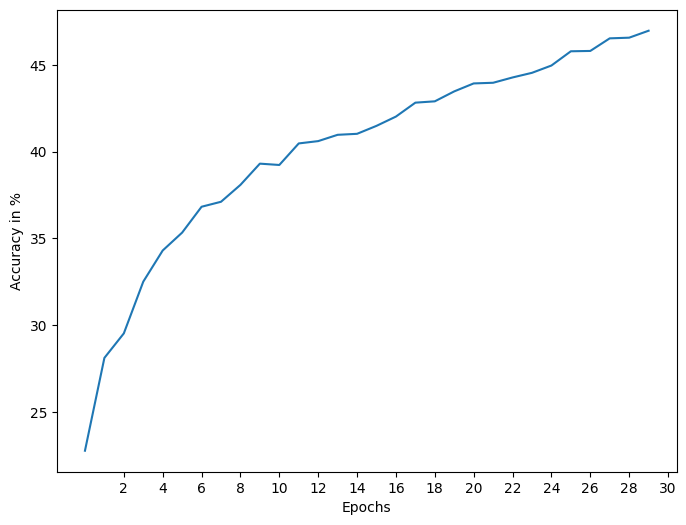

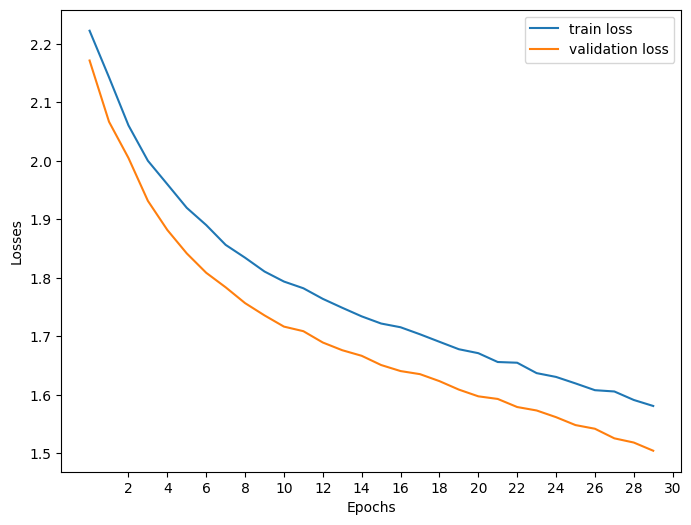

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [00:58<28:20, 58.62s/it]


epoch:   1, loss: 2.22068, valid loss: 2.16990, valid accruacy: 22.674%
Validation loss decreased (inf --> 2.169900). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [01:56<27:14, 58.36s/it]


epoch:   2, loss: 2.13217, valid loss: 2.05989, valid accruacy: 27.373%
Validation loss decreased (2.169900 --> 2.059893). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:55<26:23, 58.63s/it]


epoch:   3, loss: 2.04894, valid loss: 1.97945, valid accruacy: 31.003%
Validation loss decreased (2.059893 --> 1.979448). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:54<25:20, 58.48s/it]


epoch:   4, loss: 1.98950, valid loss: 1.92779, valid accruacy: 32.359%
Validation loss decreased (1.979448 --> 1.927792). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:52<24:25, 58.61s/it]


epoch:   5, loss: 1.94660, valid loss: 1.88424, valid accruacy: 33.391%
Validation loss decreased (1.927792 --> 1.884237). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [05:51<23:26, 58.62s/it]


epoch:   6, loss: 1.90938, valid loss: 1.84754, valid accruacy: 34.919%
Validation loss decreased (1.884237 --> 1.847540). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:49<22:27, 58.58s/it]


epoch:   7, loss: 1.88046, valid loss: 1.81949, valid accruacy: 36.218%
Validation loss decreased (1.847540 --> 1.819492). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:48<21:30, 58.67s/it]


epoch:   8, loss: 1.86024, valid loss: 1.79537, valid accruacy: 37.268%
Validation loss decreased (1.819492 --> 1.795365). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:47<20:30, 58.60s/it]


epoch:   9, loss: 1.83714, valid loss: 1.77322, valid accruacy: 37.689%
Validation loss decreased (1.795365 --> 1.773220). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:46<19:35, 58.79s/it]


epoch:  10, loss: 1.81706, valid loss: 1.75039, valid accruacy: 38.758%
Validation loss decreased (1.773220 --> 1.750395). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:45<18:41, 59.01s/it]


epoch:  11, loss: 1.79952, valid loss: 1.73656, valid accruacy: 39.179%
Validation loss decreased (1.750395 --> 1.736562). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:44<17:41, 58.99s/it]


epoch:  12, loss: 1.78433, valid loss: 1.72337, valid accruacy: 39.599%
Validation loss decreased (1.736562 --> 1.723374). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:43<16:42, 58.96s/it]


epoch:  13, loss: 1.76796, valid loss: 1.70509, valid accruacy: 40.439%
Validation loss decreased (1.723374 --> 1.705094). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:42<15:42, 58.93s/it]


epoch:  14, loss: 1.75663, valid loss: 1.68443, valid accruacy: 41.280%
Validation loss decreased (1.705094 --> 1.684428). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [14:42<14:46, 59.13s/it]


epoch:  15, loss: 1.73754, valid loss: 1.66790, valid accruacy: 41.681%
Validation loss decreased (1.684428 --> 1.667895). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [15:41<13:48, 59.19s/it]


epoch:  16, loss: 1.72605, valid loss: 1.66378, valid accruacy: 42.197%
Validation loss decreased (1.667895 --> 1.663785). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [16:40<12:47, 59.02s/it]


epoch:  17, loss: 1.71406, valid loss: 1.64087, valid accruacy: 42.751%
Validation loss decreased (1.663785 --> 1.640874). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [17:38<11:45, 58.80s/it]


epoch:  18, loss: 1.70007, valid loss: 1.63464, valid accruacy: 43.496%
Validation loss decreased (1.640874 --> 1.634637). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [18:37<10:46, 58.74s/it]


epoch:  19, loss: 1.68550, valid loss: 1.61962, valid accruacy: 44.126%
Validation loss decreased (1.634637 --> 1.619622). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [19:35<09:45, 58.54s/it]


epoch:  20, loss: 1.67287, valid loss: 1.61196, valid accruacy: 44.031%
Validation loss decreased (1.619622 --> 1.611958). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [20:33<08:46, 58.50s/it]


epoch:  21, loss: 1.66728, valid loss: 1.59833, valid accruacy: 44.795%
Validation loss decreased (1.611958 --> 1.598333). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [21:31<07:47, 58.44s/it]


epoch:  22, loss: 1.64467, valid loss: 1.58632, valid accruacy: 44.909%
Validation loss decreased (1.598333 --> 1.586315). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [22:29<06:48, 58.29s/it]


epoch:  23, loss: 1.63629, valid loss: 1.57564, valid accruacy: 45.559%
Validation loss decreased (1.586315 --> 1.575641). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [23:27<05:48, 58.12s/it]


epoch:  24, loss: 1.62950, valid loss: 1.56394, valid accruacy: 46.189%
Validation loss decreased (1.575641 --> 1.563936). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [24:25<04:50, 58.20s/it]


epoch:  25, loss: 1.62339, valid loss: 1.55244, valid accruacy: 46.151%
Validation loss decreased (1.563936 --> 1.552437). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [25:25<03:54, 58.64s/it]


epoch:  26, loss: 1.60973, valid loss: 1.54351, valid accruacy: 46.590%
Validation loss decreased (1.552437 --> 1.543505). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [26:24<02:55, 58.61s/it]


epoch:  27, loss: 1.60098, valid loss: 1.53509, valid accruacy: 46.915%
Validation loss decreased (1.543505 --> 1.535088). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [27:22<01:56, 58.42s/it]


epoch:  28, loss: 1.58696, valid loss: 1.53540, valid accruacy: 46.705%


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [28:20<00:58, 58.27s/it]


epoch:  29, loss: 1.57693, valid loss: 1.51586, valid accruacy: 47.202%
Validation loss decreased (1.535088 --> 1.515865). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [29:18<00:00, 58.62s/it]


epoch:  30, loss: 1.56663, valid loss: 1.50365, valid accruacy: 47.889%
Validation loss decreased (1.515865 --> 1.503649). Saving model...
Fit time: 1758.513611316681 s


Test loss: 1.49478	Test accruacy: 48.415%
Saving model


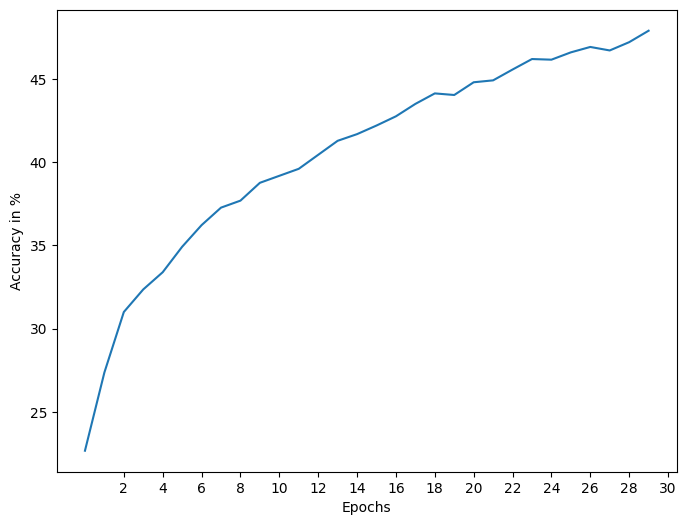

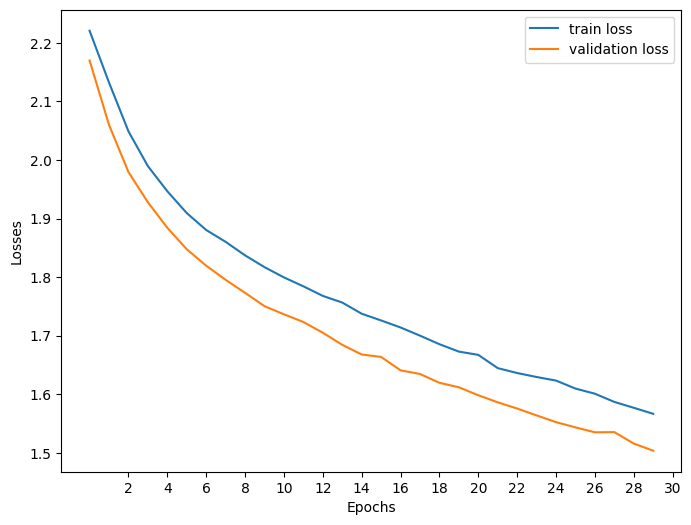

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [00:57<27:53, 57.70s/it]


epoch:   1, loss: 2.29130, valid loss: 2.28571, valid accruacy: 20.057%
Validation loss decreased (inf --> 2.285711). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [01:54<26:46, 57.37s/it]


epoch:   2, loss: 2.28140, valid loss: 2.27597, valid accruacy: 19.962%
Validation loss decreased (2.285711 --> 2.275975). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:52<25:47, 57.32s/it]


epoch:   3, loss: 2.27261, valid loss: 2.26644, valid accruacy: 20.669%
Validation loss decreased (2.275975 --> 2.266443). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:49<24:51, 57.36s/it]


epoch:   4, loss: 2.26276, valid loss: 2.25678, valid accruacy: 21.471%
Validation loss decreased (2.266443 --> 2.256783). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:48<24:06, 57.87s/it]


epoch:   5, loss: 2.25464, valid loss: 2.24714, valid accruacy: 22.216%
Validation loss decreased (2.256783 --> 2.247135). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [05:45<23:00, 57.52s/it]


epoch:   6, loss: 2.24720, valid loss: 2.23806, valid accruacy: 22.502%
Validation loss decreased (2.247135 --> 2.238057). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:41<21:54, 57.13s/it]


epoch:   7, loss: 2.23888, valid loss: 2.22994, valid accruacy: 22.541%
Validation loss decreased (2.238057 --> 2.229944). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:37<20:52, 56.93s/it]


epoch:   8, loss: 2.23210, valid loss: 2.22351, valid accruacy: 22.178%
Validation loss decreased (2.229944 --> 2.223509). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:34<19:52, 56.81s/it]


epoch:   9, loss: 2.22834, valid loss: 2.21876, valid accruacy: 21.471%
Validation loss decreased (2.223509 --> 2.218760). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:31<18:59, 56.98s/it]


epoch:  10, loss: 2.22569, valid loss: 2.21528, valid accruacy: 21.223%
Validation loss decreased (2.218760 --> 2.215281). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:29<18:05, 57.11s/it]


epoch:  11, loss: 2.22164, valid loss: 2.21221, valid accruacy: 20.821%
Validation loss decreased (2.215281 --> 2.212208). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:26<17:10, 57.25s/it]


epoch:  12, loss: 2.22134, valid loss: 2.21000, valid accruacy: 21.318%
Validation loss decreased (2.212208 --> 2.209997). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:26<16:25, 57.98s/it]


epoch:  13, loss: 2.21853, valid loss: 2.20794, valid accruacy: 21.375%
Validation loss decreased (2.209997 --> 2.207945). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:24<15:26, 57.93s/it]


epoch:  14, loss: 2.21546, valid loss: 2.20588, valid accruacy: 21.318%
Validation loss decreased (2.207945 --> 2.205877). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [14:22<14:28, 57.91s/it]


epoch:  15, loss: 2.21349, valid loss: 2.20400, valid accruacy: 21.127%
Validation loss decreased (2.205877 --> 2.204001). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [15:20<13:33, 58.08s/it]


epoch:  16, loss: 2.21322, valid loss: 2.20252, valid accruacy: 21.070%
Validation loss decreased (2.204001 --> 2.202524). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [16:20<12:41, 58.56s/it]


epoch:  17, loss: 2.21055, valid loss: 2.20115, valid accruacy: 21.318%
Validation loss decreased (2.202524 --> 2.201154). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [17:18<11:41, 58.43s/it]


epoch:  18, loss: 2.20964, valid loss: 2.19994, valid accruacy: 21.261%
Validation loss decreased (2.201154 --> 2.199939). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [18:16<10:41, 58.31s/it]


epoch:  19, loss: 2.20871, valid loss: 2.19885, valid accruacy: 21.662%
Validation loss decreased (2.199939 --> 2.198850). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [19:14<09:41, 58.12s/it]


epoch:  20, loss: 2.20816, valid loss: 2.19785, valid accruacy: 22.159%
Validation loss decreased (2.198850 --> 2.197852). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [20:12<08:42, 58.07s/it]


epoch:  21, loss: 2.20548, valid loss: 2.19679, valid accruacy: 22.273%
Validation loss decreased (2.197852 --> 2.196792). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [21:09<07:43, 57.91s/it]


epoch:  22, loss: 2.20585, valid loss: 2.19592, valid accruacy: 22.426%
Validation loss decreased (2.196792 --> 2.195917). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [22:06<06:43, 57.67s/it]


epoch:  23, loss: 2.20319, valid loss: 2.19477, valid accruacy: 22.521%
Validation loss decreased (2.195917 --> 2.194768). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [23:05<05:47, 57.87s/it]


epoch:  24, loss: 2.20156, valid loss: 2.19379, valid accruacy: 22.541%
Validation loss decreased (2.194768 --> 2.193792). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [24:02<04:48, 57.66s/it]


epoch:  25, loss: 2.20265, valid loss: 2.19295, valid accruacy: 22.693%
Validation loss decreased (2.193792 --> 2.192952). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [24:59<03:49, 57.46s/it]


epoch:  26, loss: 2.20260, valid loss: 2.19218, valid accruacy: 22.732%
Validation loss decreased (2.192952 --> 2.192184). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [25:57<02:52, 57.63s/it]


epoch:  27, loss: 2.20179, valid loss: 2.19128, valid accruacy: 22.865%
Validation loss decreased (2.192184 --> 2.191280). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [26:54<01:54, 57.49s/it]


epoch:  28, loss: 2.19984, valid loss: 2.19024, valid accruacy: 23.075%
Validation loss decreased (2.191280 --> 2.190237). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [27:52<00:57, 57.59s/it]


epoch:  29, loss: 2.19859, valid loss: 2.18900, valid accruacy: 23.477%
Validation loss decreased (2.190237 --> 2.189004). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [28:49<00:00, 57.64s/it]


epoch:  30, loss: 2.19800, valid loss: 2.18788, valid accruacy: 23.687%
Validation loss decreased (2.189004 --> 2.187882). Saving model...
Fit time: 1729.2645637989044 s


Test loss: 2.19012	Test accruacy: 23.024%
Saving model


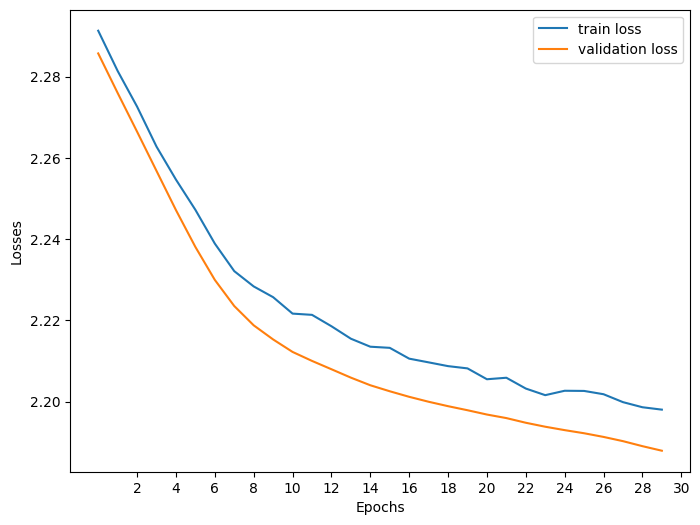

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:00<19:04, 60.23s/it]


epoch:   1, loss: 1.99099, valid loss: 1.76562, valid accruacy: 38.166%
Validation loss decreased (inf --> 1.765624). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:59<17:54, 59.70s/it]


epoch:   2, loss: 1.74039, valid loss: 1.55951, valid accruacy: 46.476%
Validation loss decreased (1.765624 --> 1.559514). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:59<16:57, 59.85s/it]


epoch:   3, loss: 1.58879, valid loss: 1.45566, valid accruacy: 50.315%
Validation loss decreased (1.559514 --> 1.455663). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:57<15:46, 59.14s/it]


epoch:   4, loss: 1.48747, valid loss: 1.33012, valid accruacy: 54.594%
Validation loss decreased (1.455663 --> 1.330120). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:55<14:38, 58.59s/it]


epoch:   5, loss: 1.40548, valid loss: 1.27877, valid accruacy: 57.918%
Validation loss decreased (1.330120 --> 1.278768). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:53<13:37, 58.39s/it]


epoch:   6, loss: 1.32804, valid loss: 1.19265, valid accruacy: 59.981%
Validation loss decreased (1.278768 --> 1.192650). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:51<12:38, 58.35s/it]


epoch:   7, loss: 1.26324, valid loss: 1.13465, valid accruacy: 62.369%
Validation loss decreased (1.192650 --> 1.134652). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:49<11:40, 58.34s/it]


epoch:   8, loss: 1.20960, valid loss: 1.08726, valid accruacy: 64.508%
Validation loss decreased (1.134652 --> 1.087262). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:47<10:40, 58.20s/it]


epoch:   9, loss: 1.15035, valid loss: 1.04926, valid accruacy: 66.074%
Validation loss decreased (1.087262 --> 1.049259). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:45<09:42, 58.21s/it]


epoch:  10, loss: 1.10102, valid loss: 1.01530, valid accruacy: 66.361%
Validation loss decreased (1.049259 --> 1.015300). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:44<08:44, 58.33s/it]


epoch:  11, loss: 1.03939, valid loss: 0.97031, valid accruacy: 68.424%
Validation loss decreased (1.015300 --> 0.970308). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:43<07:48, 58.60s/it]


epoch:  12, loss: 0.99240, valid loss: 0.91170, valid accruacy: 70.812%
Validation loss decreased (0.970308 --> 0.911698). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [12:43<06:52, 58.92s/it]


epoch:  13, loss: 0.95302, valid loss: 0.87703, valid accruacy: 72.932%
Validation loss decreased (0.911698 --> 0.877029). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [13:43<05:54, 59.13s/it]


epoch:  14, loss: 0.91237, valid loss: 0.83318, valid accruacy: 74.632%
Validation loss decreased (0.877029 --> 0.833181). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [14:42<04:56, 59.26s/it]


epoch:  15, loss: 0.88336, valid loss: 0.83662, valid accruacy: 74.613%


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [15:41<03:56, 59.22s/it]


epoch:  16, loss: 0.84193, valid loss: 0.79836, valid accruacy: 76.466%
Validation loss decreased (0.833181 --> 0.798359). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [16:41<02:58, 59.38s/it]


epoch:  17, loss: 0.80580, valid loss: 0.78937, valid accruacy: 76.734%
Validation loss decreased (0.798359 --> 0.789371). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [17:41<01:59, 59.55s/it]


epoch:  18, loss: 0.77306, valid loss: 0.75510, valid accruacy: 78.491%
Validation loss decreased (0.789371 --> 0.755095). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [18:40<00:59, 59.39s/it]


epoch:  19, loss: 0.75235, valid loss: 0.73676, valid accruacy: 78.682%
Validation loss decreased (0.755095 --> 0.736763). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:39<00:00, 59.00s/it]


epoch:  20, loss: 0.72714, valid loss: 0.72294, valid accruacy: 79.713%
Validation loss decreased (0.736763 --> 0.722944). Saving model...
Fit time: 1179.9050376415253 s


Test loss: 0.73070	Test accruacy: 78.961%
Saving model


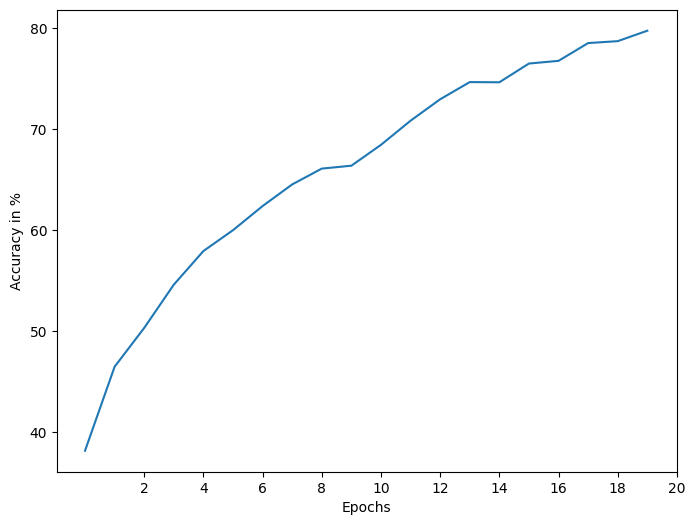

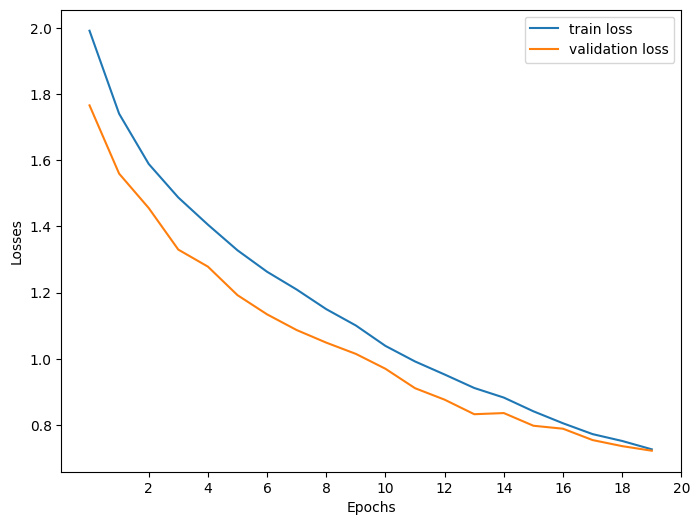

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:59<18:57, 59.88s/it]


epoch:   1, loss: 1.96348, valid loss: 1.71612, valid accruacy: 39.885%
Validation loss decreased (inf --> 1.716119). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:00<18:10, 60.61s/it]


epoch:   2, loss: 1.69298, valid loss: 1.51091, valid accruacy: 48.157%
Validation loss decreased (1.716119 --> 1.510908). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [03:00<16:58, 59.90s/it]


epoch:   3, loss: 1.56207, valid loss: 1.40502, valid accruacy: 51.270%
Validation loss decreased (1.510908 --> 1.405024). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [04:00<15:58, 59.93s/it]


epoch:   4, loss: 1.46334, valid loss: 1.33040, valid accruacy: 53.754%
Validation loss decreased (1.405024 --> 1.330402). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:59<14:54, 59.64s/it]


epoch:   5, loss: 1.38356, valid loss: 1.24705, valid accruacy: 57.555%
Validation loss decreased (1.330402 --> 1.247048). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:59<13:56, 59.72s/it]


epoch:   6, loss: 1.31353, valid loss: 1.19496, valid accruacy: 59.599%
Validation loss decreased (1.247048 --> 1.194958). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:58<12:56, 59.70s/it]


epoch:   7, loss: 1.25485, valid loss: 1.11804, valid accruacy: 61.509%
Validation loss decreased (1.194958 --> 1.118038). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:58<11:58, 59.85s/it]


epoch:   8, loss: 1.20000, valid loss: 1.05837, valid accruacy: 64.699%
Validation loss decreased (1.118038 --> 1.058373). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:58<10:57, 59.79s/it]


epoch:   9, loss: 1.14741, valid loss: 1.02805, valid accruacy: 65.864%
Validation loss decreased (1.058373 --> 1.028051). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:58<09:57, 59.73s/it]


epoch:  10, loss: 1.09526, valid loss: 0.96962, valid accruacy: 67.966%
Validation loss decreased (1.028051 --> 0.969623). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:57<08:57, 59.77s/it]


epoch:  11, loss: 1.05327, valid loss: 0.92512, valid accruacy: 69.971%
Validation loss decreased (0.969623 --> 0.925123). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:57<07:57, 59.72s/it]


epoch:  12, loss: 0.99905, valid loss: 0.87367, valid accruacy: 72.206%
Validation loss decreased (0.925123 --> 0.873666). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [12:57<06:58, 59.81s/it]


epoch:  13, loss: 0.96643, valid loss: 0.85437, valid accruacy: 72.932%
Validation loss decreased (0.873666 --> 0.854366). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [13:57<05:59, 59.84s/it]


epoch:  14, loss: 0.92594, valid loss: 0.80665, valid accruacy: 74.651%
Validation loss decreased (0.854366 --> 0.806650). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [14:57<04:58, 59.74s/it]


epoch:  15, loss: 0.88985, valid loss: 0.80714, valid accruacy: 75.282%


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [15:59<04:02, 60.64s/it]


epoch:  16, loss: 0.85424, valid loss: 0.74902, valid accruacy: 77.135%
Validation loss decreased (0.806650 --> 0.749015). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [17:00<03:01, 60.65s/it]


epoch:  17, loss: 0.81921, valid loss: 0.73226, valid accruacy: 77.937%
Validation loss decreased (0.749015 --> 0.732258). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [17:59<02:00, 60.32s/it]


epoch:  18, loss: 0.79803, valid loss: 0.71018, valid accruacy: 78.949%
Validation loss decreased (0.732258 --> 0.710184). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [18:58<00:59, 59.92s/it]


epoch:  19, loss: 0.77120, valid loss: 0.71257, valid accruacy: 78.625%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:58<00:00, 59.91s/it]


epoch:  20, loss: 0.73701, valid loss: 0.69051, valid accruacy: 79.866%
Validation loss decreased (0.710184 --> 0.690514). Saving model...
Fit time: 1198.2534608840942 s


Test loss: 0.71630	Test accruacy: 79.343%
Saving model


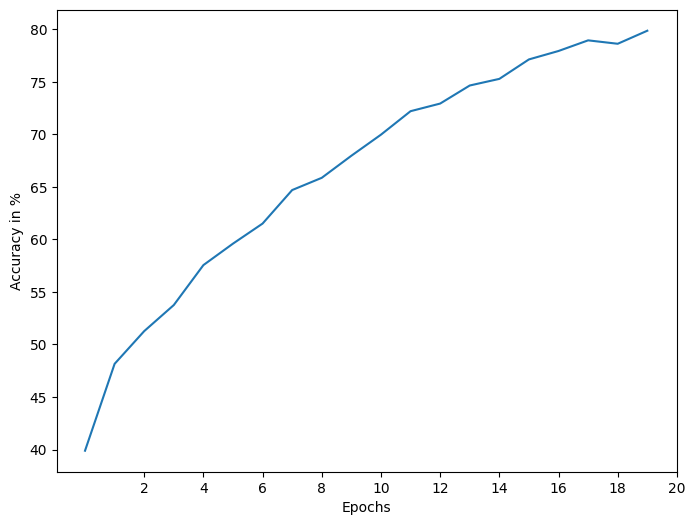

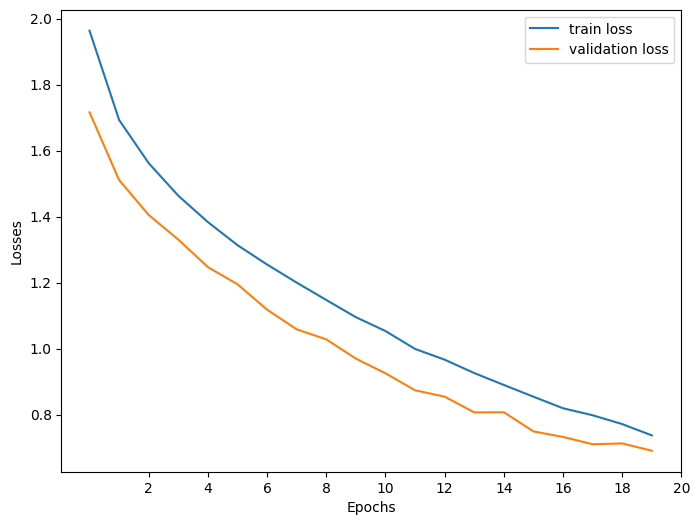

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:58<18:40, 59.00s/it]


epoch:   1, loss: 2.25618, valid loss: 2.22337, valid accruacy: 18.930%
Validation loss decreased (inf --> 2.223369). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:57<17:35, 58.65s/it]


epoch:   2, loss: 2.21837, valid loss: 2.20569, valid accruacy: 21.757%
Validation loss decreased (2.223369 --> 2.205690). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:56<16:36, 58.64s/it]


epoch:   3, loss: 2.21028, valid loss: 2.20159, valid accruacy: 19.102%
Validation loss decreased (2.205690 --> 2.201594). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:54<15:37, 58.57s/it]


epoch:   4, loss: 2.20879, valid loss: 2.20031, valid accruacy: 19.102%
Validation loss decreased (2.201594 --> 2.200306). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:53<14:38, 58.55s/it]


epoch:   5, loss: 2.20807, valid loss: 2.19964, valid accruacy: 19.102%
Validation loss decreased (2.200306 --> 2.199638). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:51<13:40, 58.59s/it]


epoch:   6, loss: 2.20725, valid loss: 2.19860, valid accruacy: 19.102%
Validation loss decreased (2.199638 --> 2.198597). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:50<12:41, 58.61s/it]


epoch:   7, loss: 2.20519, valid loss: 2.19578, valid accruacy: 19.140%
Validation loss decreased (2.198597 --> 2.195785). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:51<11:52, 59.35s/it]


epoch:   8, loss: 2.19872, valid loss: 2.18265, valid accruacy: 22.751%
Validation loss decreased (2.195785 --> 2.182652). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:49<10:50, 59.14s/it]


epoch:   9, loss: 2.17974, valid loss: 2.15328, valid accruacy: 24.107%
Validation loss decreased (2.182652 --> 2.153285). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:48<09:49, 58.91s/it]


epoch:  10, loss: 2.14664, valid loss: 2.09721, valid accruacy: 26.055%
Validation loss decreased (2.153285 --> 2.097212). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:47<08:50, 58.90s/it]


epoch:  11, loss: 2.09023, valid loss: 2.02447, valid accruacy: 29.226%
Validation loss decreased (2.097212 --> 2.024472). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:46<07:51, 58.98s/it]


epoch:  12, loss: 2.03417, valid loss: 1.97840, valid accruacy: 30.277%
Validation loss decreased (2.024472 --> 1.978396). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [12:45<06:53, 59.07s/it]


epoch:  13, loss: 1.99271, valid loss: 1.93053, valid accruacy: 31.882%
Validation loss decreased (1.978396 --> 1.930526). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [13:46<05:58, 59.73s/it]


epoch:  14, loss: 1.95352, valid loss: 1.88750, valid accruacy: 33.734%
Validation loss decreased (1.930526 --> 1.887499). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [14:45<04:57, 59.48s/it]


epoch:  15, loss: 1.91376, valid loss: 1.85909, valid accruacy: 33.696%
Validation loss decreased (1.887499 --> 1.859091). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [15:44<03:57, 59.32s/it]


epoch:  16, loss: 1.87960, valid loss: 1.82238, valid accruacy: 35.263%
Validation loss decreased (1.859091 --> 1.822384). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [16:44<02:58, 59.33s/it]


epoch:  17, loss: 1.85343, valid loss: 1.78725, valid accruacy: 36.504%
Validation loss decreased (1.822384 --> 1.787254). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [17:43<01:58, 59.47s/it]


epoch:  18, loss: 1.82439, valid loss: 1.76272, valid accruacy: 38.300%
Validation loss decreased (1.787254 --> 1.762718). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [18:43<00:59, 59.52s/it]


epoch:  19, loss: 1.80147, valid loss: 1.72949, valid accruacy: 39.599%
Validation loss decreased (1.762718 --> 1.729493). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:43<00:00, 59.16s/it]


epoch:  20, loss: 1.78136, valid loss: 1.71005, valid accruacy: 39.943%
Validation loss decreased (1.729493 --> 1.710048). Saving model...
Fit time: 1183.1791450977325 s


Test loss: 1.72511	Test accruacy: 38.259%
Saving model


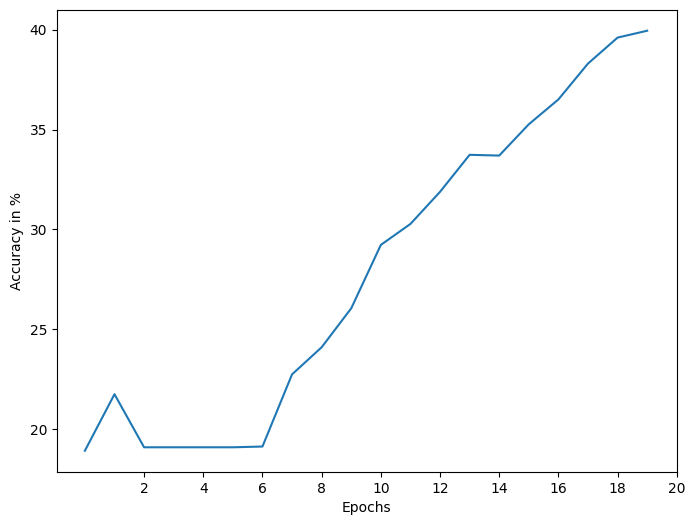

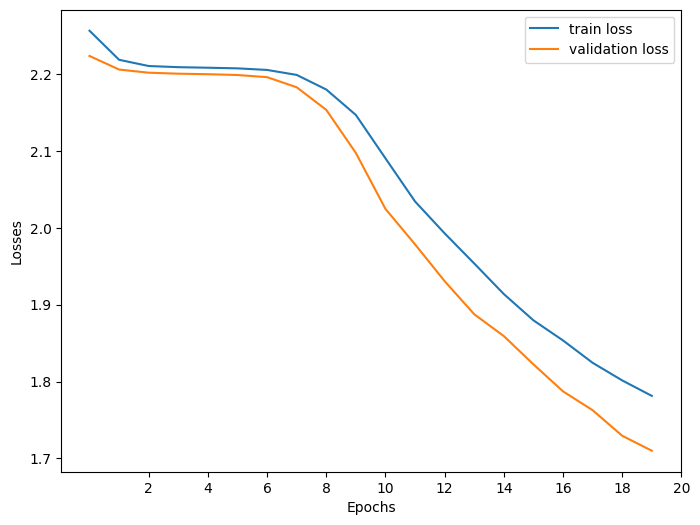

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:01<19:27, 61.44s/it]


epoch:   1, loss: 2.17338, valid loss: 2.05180, valid accruacy: 29.112%
Validation loss decreased (inf --> 2.051804). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:01<18:13, 60.73s/it]


epoch:   2, loss: 2.03108, valid loss: 1.94239, valid accruacy: 32.932%
Validation loss decreased (2.051804 --> 1.942390). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [03:02<17:09, 60.56s/it]


epoch:   3, loss: 1.94809, valid loss: 1.87409, valid accruacy: 35.167%
Validation loss decreased (1.942390 --> 1.874087). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [04:01<16:01, 60.08s/it]


epoch:   4, loss: 1.89390, valid loss: 1.82435, valid accruacy: 36.371%
Validation loss decreased (1.874087 --> 1.824355). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [05:01<15:02, 60.17s/it]


epoch:   5, loss: 1.85107, valid loss: 1.78885, valid accruacy: 37.058%
Validation loss decreased (1.824355 --> 1.788851). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [06:01<14:00, 60.05s/it]


epoch:   6, loss: 1.81502, valid loss: 1.75775, valid accruacy: 38.491%
Validation loss decreased (1.788851 --> 1.757745). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [07:01<12:59, 59.93s/it]


epoch:   7, loss: 1.78791, valid loss: 1.72754, valid accruacy: 39.580%
Validation loss decreased (1.757745 --> 1.727545). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [08:01<11:58, 59.91s/it]


epoch:   8, loss: 1.75641, valid loss: 1.70314, valid accruacy: 40.936%
Validation loss decreased (1.727545 --> 1.703138). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [09:00<10:58, 59.90s/it]


epoch:   9, loss: 1.73324, valid loss: 1.68091, valid accruacy: 41.547%
Validation loss decreased (1.703138 --> 1.680905). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [10:00<09:58, 59.89s/it]


epoch:  10, loss: 1.71847, valid loss: 1.65730, valid accruacy: 42.197%
Validation loss decreased (1.680905 --> 1.657300). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [11:00<08:59, 59.90s/it]


epoch:  11, loss: 1.69713, valid loss: 1.64097, valid accruacy: 42.159%
Validation loss decreased (1.657300 --> 1.640972). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [12:00<07:59, 59.90s/it]


epoch:  12, loss: 1.67939, valid loss: 1.61502, valid accruacy: 43.247%
Validation loss decreased (1.640972 --> 1.615016). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [13:01<07:00, 60.06s/it]


epoch:  13, loss: 1.65307, valid loss: 1.60697, valid accruacy: 44.317%
Validation loss decreased (1.615016 --> 1.606971). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [14:00<05:59, 59.92s/it]


epoch:  14, loss: 1.63770, valid loss: 1.57821, valid accruacy: 45.215%
Validation loss decreased (1.606971 --> 1.578213). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [15:00<04:58, 59.77s/it]


epoch:  15, loss: 1.61899, valid loss: 1.55757, valid accruacy: 46.246%
Validation loss decreased (1.578213 --> 1.557573). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [16:00<03:59, 59.90s/it]


epoch:  16, loss: 1.60329, valid loss: 1.53987, valid accruacy: 46.648%
Validation loss decreased (1.557573 --> 1.539874). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [17:00<03:00, 60.09s/it]


epoch:  17, loss: 1.58723, valid loss: 1.52292, valid accruacy: 47.488%
Validation loss decreased (1.539874 --> 1.522920). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [18:01<02:00, 60.18s/it]


epoch:  18, loss: 1.57034, valid loss: 1.50342, valid accruacy: 47.870%
Validation loss decreased (1.522920 --> 1.503423). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [19:01<01:00, 60.11s/it]


epoch:  19, loss: 1.55467, valid loss: 1.50262, valid accruacy: 48.539%
Validation loss decreased (1.503423 --> 1.502616). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [20:00<00:00, 60.03s/it]


epoch:  20, loss: 1.53233, valid loss: 1.47622, valid accruacy: 49.169%
Validation loss decreased (1.502616 --> 1.476218). Saving model...
Fit time: 1200.592916727066 s


Test loss: 1.48839	Test accruacy: 48.301%
Saving model


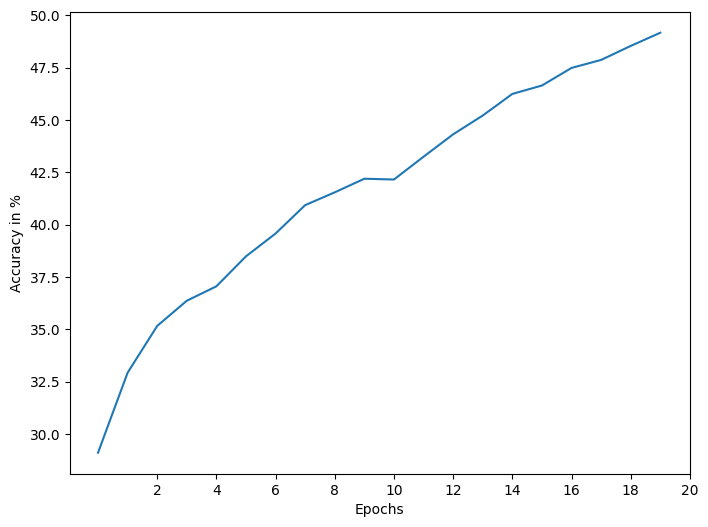

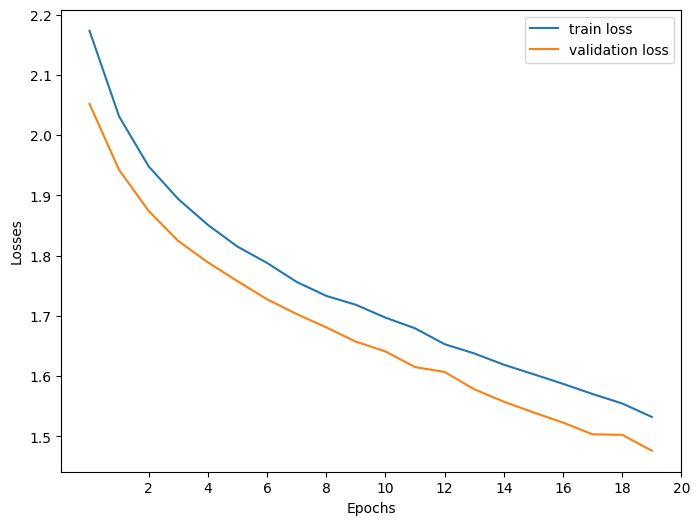

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:59<18:48, 59.39s/it]


epoch:   1, loss: 2.18920, valid loss: 2.09338, valid accruacy: 25.387%
Validation loss decreased (inf --> 2.093381). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:58<17:42, 59.04s/it]


epoch:   2, loss: 2.07221, valid loss: 1.98300, valid accruacy: 31.843%
Validation loss decreased (2.093381 --> 1.982997). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:55<16:33, 58.45s/it]


epoch:   3, loss: 1.99488, valid loss: 1.91356, valid accruacy: 35.358%
Validation loss decreased (1.982997 --> 1.913559). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:53<15:29, 58.08s/it]


epoch:   4, loss: 1.93079, valid loss: 1.85073, valid accruacy: 36.543%
Validation loss decreased (1.913559 --> 1.850733). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:51<14:31, 58.12s/it]


epoch:   5, loss: 1.88573, valid loss: 1.80502, valid accruacy: 38.415%
Validation loss decreased (1.850733 --> 1.805019). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:50<13:37, 58.40s/it]


epoch:   6, loss: 1.84866, valid loss: 1.76923, valid accruacy: 39.885%
Validation loss decreased (1.805019 --> 1.769226). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:49<12:40, 58.51s/it]


epoch:   7, loss: 1.81366, valid loss: 1.74140, valid accruacy: 40.783%
Validation loss decreased (1.769226 --> 1.741398). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:49<11:46, 58.91s/it]


epoch:   8, loss: 1.78577, valid loss: 1.71113, valid accruacy: 41.146%
Validation loss decreased (1.741398 --> 1.711126). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:51<10:59, 59.96s/it]


epoch:   9, loss: 1.76076, valid loss: 1.69031, valid accruacy: 42.063%
Validation loss decreased (1.711126 --> 1.690305). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:50<09:57, 59.73s/it]


epoch:  10, loss: 1.73644, valid loss: 1.67053, valid accruacy: 42.942%
Validation loss decreased (1.690305 --> 1.670533). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:49<08:54, 59.34s/it]


epoch:  11, loss: 1.70679, valid loss: 1.63505, valid accruacy: 44.527%
Validation loss decreased (1.670533 --> 1.635046). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:48<07:55, 59.46s/it]


epoch:  12, loss: 1.68611, valid loss: 1.61097, valid accruacy: 45.119%
Validation loss decreased (1.635046 --> 1.610969). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [12:48<06:56, 59.57s/it]


epoch:  13, loss: 1.66595, valid loss: 1.59439, valid accruacy: 45.482%
Validation loss decreased (1.610969 --> 1.594395). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [13:48<05:57, 59.53s/it]


epoch:  14, loss: 1.64599, valid loss: 1.57840, valid accruacy: 46.055%
Validation loss decreased (1.594395 --> 1.578403). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [14:47<04:58, 59.60s/it]


epoch:  15, loss: 1.62570, valid loss: 1.54960, valid accruacy: 47.011%
Validation loss decreased (1.578403 --> 1.549595). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [15:48<03:59, 59.95s/it]


epoch:  16, loss: 1.60839, valid loss: 1.52971, valid accruacy: 47.966%
Validation loss decreased (1.549595 --> 1.529713). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [16:48<02:59, 59.86s/it]


epoch:  17, loss: 1.59174, valid loss: 1.51535, valid accruacy: 47.985%
Validation loss decreased (1.529713 --> 1.515352). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [17:47<01:59, 59.83s/it]


epoch:  18, loss: 1.57149, valid loss: 1.49911, valid accruacy: 48.749%
Validation loss decreased (1.515352 --> 1.499113). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [18:47<00:59, 59.71s/it]


epoch:  19, loss: 1.55168, valid loss: 1.48170, valid accruacy: 49.360%
Validation loss decreased (1.499113 --> 1.481698). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:46<00:00, 59.32s/it]


epoch:  20, loss: 1.53607, valid loss: 1.46364, valid accruacy: 50.564%
Validation loss decreased (1.481698 --> 1.463641). Saving model...
Fit time: 1186.4408686161041 s


Test loss: 1.46684	Test accruacy: 49.637%
Saving model


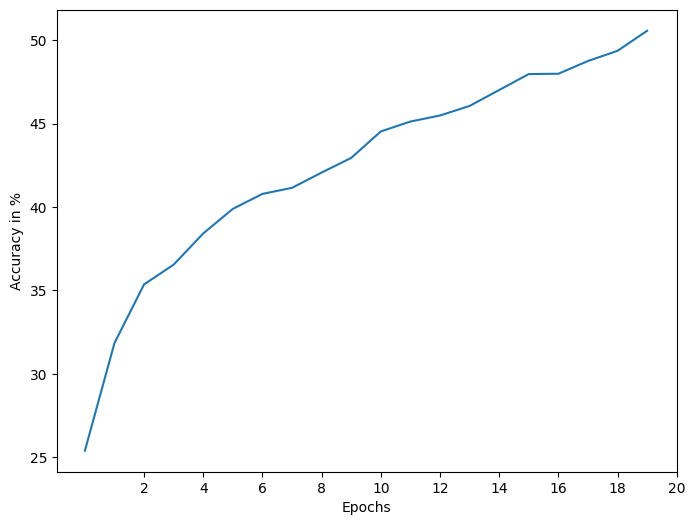

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:59<18:44, 59.17s/it]


epoch:   1, loss: 2.30700, valid loss: 2.30013, valid accruacy: 6.227%
Validation loss decreased (inf --> 2.300129). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:58<17:47, 59.28s/it]


epoch:   2, loss: 2.29312, valid loss: 2.28681, valid accruacy: 19.236%
Validation loss decreased (2.300129 --> 2.286811). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:57<16:48, 59.32s/it]


epoch:   3, loss: 2.28105, valid loss: 2.27511, valid accruacy: 19.236%
Validation loss decreased (2.286811 --> 2.275111). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:56<15:41, 58.84s/it]


epoch:   4, loss: 2.27043, valid loss: 2.26492, valid accruacy: 19.236%
Validation loss decreased (2.275111 --> 2.264923). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:54<14:41, 58.76s/it]


epoch:   5, loss: 2.26126, valid loss: 2.25602, valid accruacy: 19.236%
Validation loss decreased (2.264923 --> 2.256025). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:53<13:42, 58.76s/it]


epoch:   6, loss: 2.25310, valid loss: 2.24833, valid accruacy: 19.236%
Validation loss decreased (2.256025 --> 2.248329). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:52<12:44, 58.82s/it]


epoch:   7, loss: 2.24618, valid loss: 2.24158, valid accruacy: 19.236%
Validation loss decreased (2.248329 --> 2.241584). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:53<11:55, 59.65s/it]


epoch:   8, loss: 2.24019, valid loss: 2.23581, valid accruacy: 19.236%
Validation loss decreased (2.241584 --> 2.235811). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:52<10:53, 59.37s/it]


epoch:   9, loss: 2.23501, valid loss: 2.23079, valid accruacy: 19.236%
Validation loss decreased (2.235811 --> 2.230791). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:51<09:52, 59.26s/it]


epoch:  10, loss: 2.23078, valid loss: 2.22651, valid accruacy: 19.236%
Validation loss decreased (2.230791 --> 2.226507). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:50<08:52, 59.15s/it]


epoch:  11, loss: 2.22698, valid loss: 2.22284, valid accruacy: 19.236%
Validation loss decreased (2.226507 --> 2.222842). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:49<07:53, 59.23s/it]


epoch:  12, loss: 2.22374, valid loss: 2.21965, valid accruacy: 19.236%
Validation loss decreased (2.222842 --> 2.219646). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [12:49<06:54, 59.25s/it]


epoch:  13, loss: 2.22101, valid loss: 2.21695, valid accruacy: 19.236%
Validation loss decreased (2.219646 --> 2.216951). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [13:48<05:55, 59.30s/it]


epoch:  14, loss: 2.21853, valid loss: 2.21462, valid accruacy: 19.236%
Validation loss decreased (2.216951 --> 2.214616). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [14:48<04:57, 59.43s/it]


epoch:  15, loss: 2.21673, valid loss: 2.21265, valid accruacy: 19.236%
Validation loss decreased (2.214616 --> 2.212645). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [15:47<03:57, 59.44s/it]


epoch:  16, loss: 2.21498, valid loss: 2.21095, valid accruacy: 19.236%
Validation loss decreased (2.212645 --> 2.210948). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [16:47<02:58, 59.41s/it]


epoch:  17, loss: 2.21342, valid loss: 2.20948, valid accruacy: 19.236%
Validation loss decreased (2.210948 --> 2.209481). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [17:46<01:59, 59.50s/it]


epoch:  18, loss: 2.21228, valid loss: 2.20823, valid accruacy: 19.236%
Validation loss decreased (2.209481 --> 2.208235). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [18:46<00:59, 59.51s/it]


epoch:  19, loss: 2.21087, valid loss: 2.20713, valid accruacy: 19.236%
Validation loss decreased (2.208235 --> 2.207133). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:45<00:00, 59.30s/it]


epoch:  20, loss: 2.20999, valid loss: 2.20622, valid accruacy: 19.236%
Validation loss decreased (2.207133 --> 2.206217). Saving model...
Fit time: 1185.9386186599731 s


Test loss: 2.20603	Test accruacy: 19.244%
Saving model


results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [01:01<29:34, 61.20s/it]


epoch:   1, loss: 1.99903, valid loss: 1.74439, valid accruacy: 40.019%
Validation loss decreased (inf --> 1.744387). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [02:02<28:33, 61.19s/it]


epoch:   2, loss: 1.70179, valid loss: 1.52377, valid accruacy: 47.087%
Validation loss decreased (1.744387 --> 1.523768). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [03:03<27:31, 61.16s/it]


epoch:   3, loss: 1.54564, valid loss: 1.38348, valid accruacy: 52.837%
Validation loss decreased (1.523768 --> 1.383483). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [04:04<26:28, 61.11s/it]


epoch:   4, loss: 1.44985, valid loss: 1.31159, valid accruacy: 54.537%
Validation loss decreased (1.383483 --> 1.311587). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [05:05<25:24, 60.98s/it]


epoch:   5, loss: 1.36946, valid loss: 1.21602, valid accruacy: 57.994%
Validation loss decreased (1.311587 --> 1.216022). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [06:06<24:25, 61.05s/it]


epoch:   6, loss: 1.29998, valid loss: 1.21201, valid accruacy: 58.300%
Validation loss decreased (1.216022 --> 1.212011). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [07:07<23:23, 61.04s/it]


epoch:   7, loss: 1.22923, valid loss: 1.08900, valid accruacy: 62.770%
Validation loss decreased (1.212011 --> 1.089004). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [08:08<22:19, 60.87s/it]


epoch:   8, loss: 1.18545, valid loss: 1.05722, valid accruacy: 64.642%
Validation loss decreased (1.089004 --> 1.057215). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [09:08<21:16, 60.79s/it]


epoch:   9, loss: 1.12348, valid loss: 1.00360, valid accruacy: 66.743%
Validation loss decreased (1.057215 --> 1.003597). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [10:08<20:10, 60.52s/it]


epoch:  10, loss: 1.07633, valid loss: 0.95643, valid accruacy: 68.730%
Validation loss decreased (1.003597 --> 0.956426). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [11:08<19:05, 60.28s/it]


epoch:  11, loss: 1.03097, valid loss: 0.94398, valid accruacy: 69.265%
Validation loss decreased (0.956426 --> 0.943983). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [12:08<18:05, 60.29s/it]


epoch:  12, loss: 0.99283, valid loss: 0.89077, valid accruacy: 72.321%
Validation loss decreased (0.943983 --> 0.890769). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [13:08<17:03, 60.21s/it]


epoch:  13, loss: 0.95457, valid loss: 0.86429, valid accruacy: 72.531%
Validation loss decreased (0.890769 --> 0.864289). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [14:08<16:03, 60.25s/it]


epoch:  14, loss: 0.90364, valid loss: 0.83367, valid accruacy: 73.429%
Validation loss decreased (0.864289 --> 0.833674). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [15:08<15:00, 60.06s/it]


epoch:  15, loss: 0.85978, valid loss: 0.80351, valid accruacy: 75.320%
Validation loss decreased (0.833674 --> 0.803508). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [16:08<13:59, 59.96s/it]


epoch:  16, loss: 0.83351, valid loss: 0.77657, valid accruacy: 76.772%
Validation loss decreased (0.803508 --> 0.776573). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [17:09<13:04, 60.32s/it]


epoch:  17, loss: 0.80801, valid loss: 0.74484, valid accruacy: 78.090%
Validation loss decreased (0.776573 --> 0.744843). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [18:09<12:02, 60.20s/it]


epoch:  18, loss: 0.78182, valid loss: 0.74286, valid accruacy: 78.013%
Validation loss decreased (0.744843 --> 0.742856). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [19:09<11:01, 60.11s/it]


epoch:  19, loss: 0.75300, valid loss: 0.71580, valid accruacy: 79.904%
Validation loss decreased (0.742856 --> 0.715797). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [20:09<10:00, 60.06s/it]


epoch:  20, loss: 0.72357, valid loss: 0.70122, valid accruacy: 80.573%
Validation loss decreased (0.715797 --> 0.701216). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [21:08<08:59, 59.98s/it]


epoch:  21, loss: 0.70433, valid loss: 0.67554, valid accruacy: 81.242%
Validation loss decreased (0.701216 --> 0.675536). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [22:10<08:03, 60.38s/it]


epoch:  22, loss: 0.68371, valid loss: 0.69362, valid accruacy: 81.433%


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [23:10<07:01, 60.22s/it]


epoch:  23, loss: 0.65189, valid loss: 0.68568, valid accruacy: 81.528%


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [24:09<06:00, 60.08s/it]


epoch:  24, loss: 0.64557, valid loss: 0.66716, valid accruacy: 82.254%
Validation loss decreased (0.675536 --> 0.667157). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [25:09<04:59, 59.99s/it]


epoch:  25, loss: 0.62504, valid loss: 0.66494, valid accruacy: 83.018%
Validation loss decreased (0.667157 --> 0.664943). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [26:10<04:00, 60.13s/it]


epoch:  26, loss: 0.61865, valid loss: 0.68242, valid accruacy: 82.082%


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [27:10<03:00, 60.07s/it]


epoch:  27, loss: 0.61173, valid loss: 0.65543, valid accruacy: 83.018%
Validation loss decreased (0.664943 --> 0.655431). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [28:10<02:00, 60.07s/it]


epoch:  28, loss: 0.58795, valid loss: 0.64688, valid accruacy: 83.572%
Validation loss decreased (0.655431 --> 0.646885). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [29:10<01:00, 60.08s/it]


epoch:  29, loss: 0.56448, valid loss: 0.65474, valid accruacy: 83.305%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [30:09<00:00, 60.32s/it]


epoch:  30, loss: 0.54752, valid loss: 0.66483, valid accruacy: 83.801%
Fit time: 1809.6681637763977 s


Test loss: 0.65575	Test accruacy: 83.314%
Saving model


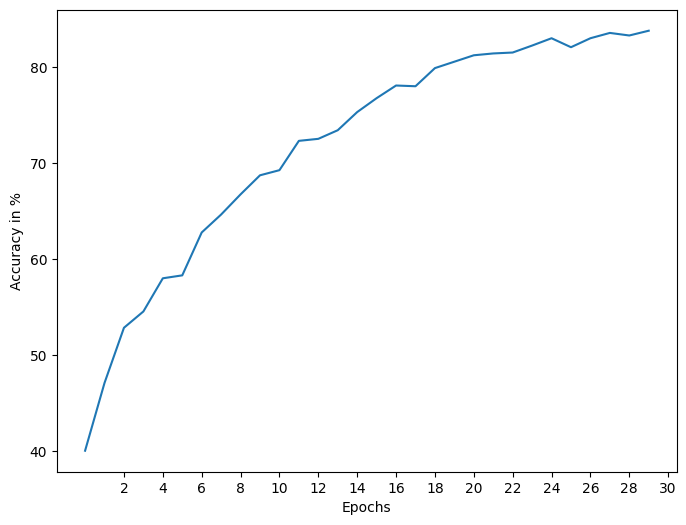

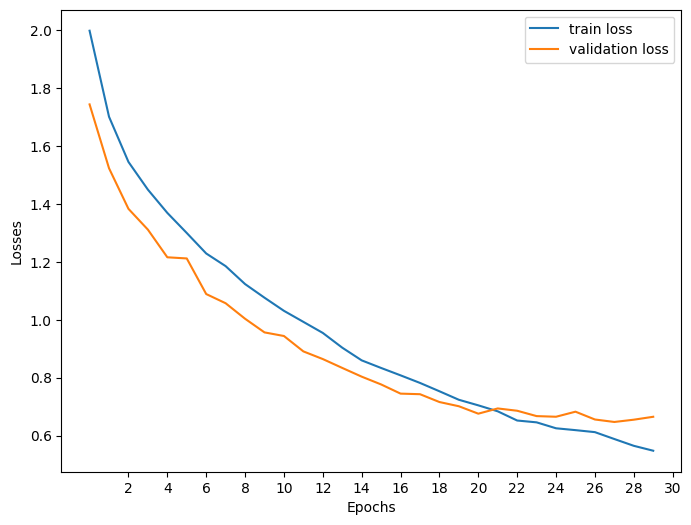

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [00:58<28:10, 58.29s/it]


epoch:   1, loss: 1.96879, valid loss: 1.73626, valid accruacy: 39.217%
Validation loss decreased (inf --> 1.736259). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [01:58<27:42, 59.37s/it]


epoch:   2, loss: 1.70051, valid loss: 1.57695, valid accruacy: 45.463%
Validation loss decreased (1.736259 --> 1.576954). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:56<26:28, 58.82s/it]


epoch:   3, loss: 1.55859, valid loss: 1.41450, valid accruacy: 51.079%
Validation loss decreased (1.576954 --> 1.414499). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:54<25:22, 58.54s/it]


epoch:   4, loss: 1.45636, valid loss: 1.35605, valid accruacy: 53.792%
Validation loss decreased (1.414499 --> 1.356046). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:52<24:20, 58.42s/it]


epoch:   5, loss: 1.38660, valid loss: 1.24742, valid accruacy: 57.536%
Validation loss decreased (1.356046 --> 1.247417). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [05:53<23:38, 59.12s/it]


epoch:   6, loss: 1.32312, valid loss: 1.20131, valid accruacy: 60.134%
Validation loss decreased (1.247417 --> 1.201312). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:52<22:36, 58.98s/it]


epoch:   7, loss: 1.24639, valid loss: 1.11466, valid accruacy: 62.197%
Validation loss decreased (1.201312 --> 1.114661). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:50<21:33, 58.81s/it]


epoch:   8, loss: 1.19226, valid loss: 1.09456, valid accruacy: 63.438%
Validation loss decreased (1.114661 --> 1.094555). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:49<20:33, 58.76s/it]


epoch:   9, loss: 1.14643, valid loss: 1.01725, valid accruacy: 66.495%
Validation loss decreased (1.094555 --> 1.017254). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:48<19:37, 58.85s/it]


epoch:  10, loss: 1.08870, valid loss: 0.99317, valid accruacy: 68.195%
Validation loss decreased (1.017254 --> 0.993166). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:47<18:39, 58.93s/it]


epoch:  11, loss: 1.04511, valid loss: 0.95312, valid accruacy: 68.978%
Validation loss decreased (0.993166 --> 0.953122). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:46<17:43, 59.08s/it]


epoch:  12, loss: 0.99960, valid loss: 0.89900, valid accruacy: 71.576%
Validation loss decreased (0.953122 --> 0.898999). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:46<16:47, 59.25s/it]


epoch:  13, loss: 0.95505, valid loss: 0.91209, valid accruacy: 71.843%


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:45<15:49, 59.33s/it]


epoch:  14, loss: 0.90524, valid loss: 0.83076, valid accruacy: 74.460%
Validation loss decreased (0.898999 --> 0.830760). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [14:45<14:51, 59.44s/it]


epoch:  15, loss: 0.88249, valid loss: 0.80456, valid accruacy: 75.817%
Validation loss decreased (0.830760 --> 0.804560). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [15:45<13:52, 59.46s/it]


epoch:  16, loss: 0.84095, valid loss: 0.79841, valid accruacy: 75.778%
Validation loss decreased (0.804560 --> 0.798412). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [16:44<12:53, 59.49s/it]


epoch:  17, loss: 0.80567, valid loss: 0.75173, valid accruacy: 77.670%
Validation loss decreased (0.798412 --> 0.751732). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [17:46<12:03, 60.29s/it]


epoch:  18, loss: 0.76900, valid loss: 0.75526, valid accruacy: 77.841%


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [18:45<10:59, 59.94s/it]


epoch:  19, loss: 0.73999, valid loss: 0.72993, valid accruacy: 78.682%
Validation loss decreased (0.751732 --> 0.729934). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [19:45<09:58, 59.83s/it]


epoch:  20, loss: 0.70967, valid loss: 0.72227, valid accruacy: 79.465%
Validation loss decreased (0.729934 --> 0.722267). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [20:45<08:57, 59.76s/it]


epoch:  21, loss: 0.69702, valid loss: 0.70895, valid accruacy: 80.401%
Validation loss decreased (0.722267 --> 0.708949). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [21:44<07:57, 59.71s/it]


epoch:  22, loss: 0.68363, valid loss: 0.72147, valid accruacy: 79.809%


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [22:44<06:58, 59.77s/it]


epoch:  23, loss: 0.66289, valid loss: 0.67015, valid accruacy: 81.643%
Validation loss decreased (0.708949 --> 0.670151). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [23:45<06:01, 60.20s/it]


epoch:  24, loss: 0.64248, valid loss: 0.70557, valid accruacy: 80.535%


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [24:45<04:59, 59.95s/it]


epoch:  25, loss: 0.62287, valid loss: 0.67308, valid accruacy: 82.254%


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [25:44<03:59, 59.78s/it]


epoch:  26, loss: 0.60159, valid loss: 0.64809, valid accruacy: 82.865%
Validation loss decreased (0.670151 --> 0.648094). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [26:44<02:59, 59.74s/it]


epoch:  27, loss: 0.59062, valid loss: 0.64576, valid accruacy: 82.942%
Validation loss decreased (0.648094 --> 0.645758). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [27:44<01:59, 59.92s/it]


epoch:  28, loss: 0.57064, valid loss: 0.65322, valid accruacy: 83.553%


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [28:44<01:00, 60.07s/it]


epoch:  29, loss: 0.55591, valid loss: 0.65117, valid accruacy: 82.942%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [29:44<00:00, 59.49s/it]


epoch:  30, loss: 0.55425, valid loss: 0.66701, valid accruacy: 83.075%
Fit time: 1784.621505022049 s


Test loss: 0.58363	Test accruacy: 84.880%
Saving model


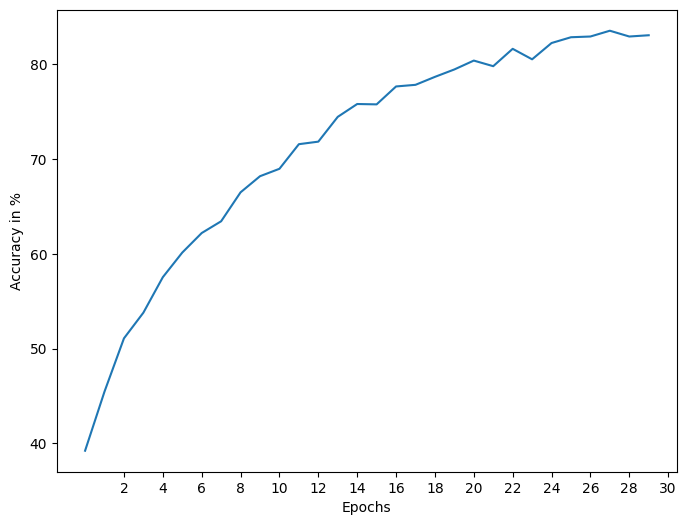

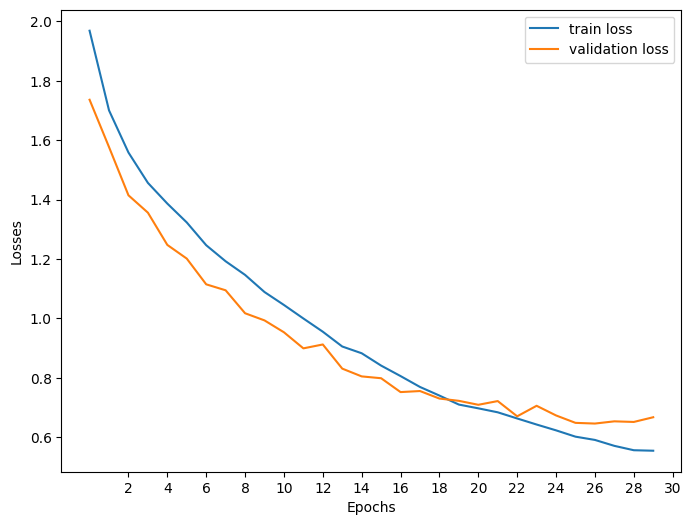

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [01:00<29:12, 60.42s/it]


epoch:   1, loss: 2.25065, valid loss: 2.22699, valid accruacy: 18.606%
Validation loss decreased (inf --> 2.226994). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [02:01<28:25, 60.91s/it]


epoch:   2, loss: 2.21654, valid loss: 2.21379, valid accruacy: 18.357%
Validation loss decreased (2.226994 --> 2.213793). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [03:00<27:04, 60.17s/it]


epoch:   3, loss: 2.20912, valid loss: 2.21089, valid accruacy: 20.936%
Validation loss decreased (2.213793 --> 2.210891). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [04:00<25:59, 59.99s/it]


epoch:   4, loss: 2.20722, valid loss: 2.20978, valid accruacy: 21.777%
Validation loss decreased (2.210891 --> 2.209777). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [05:00<24:56, 59.86s/it]


epoch:   5, loss: 2.20583, valid loss: 2.20794, valid accruacy: 19.866%
Validation loss decreased (2.209777 --> 2.207942). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [06:00<24:02, 60.10s/it]


epoch:   6, loss: 2.20133, valid loss: 2.19844, valid accruacy: 21.375%
Validation loss decreased (2.207942 --> 2.198436). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [07:01<23:07, 60.33s/it]


epoch:   7, loss: 2.18585, valid loss: 2.17429, valid accruacy: 23.286%
Validation loss decreased (2.198436 --> 2.174285). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [08:01<22:05, 60.27s/it]


epoch:   8, loss: 2.15884, valid loss: 2.12953, valid accruacy: 24.986%
Validation loss decreased (2.174285 --> 2.129534). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [09:01<21:02, 60.13s/it]


epoch:   9, loss: 2.12665, valid loss: 2.08921, valid accruacy: 26.800%
Validation loss decreased (2.129534 --> 2.089208). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [10:01<20:01, 60.09s/it]


epoch:  10, loss: 2.08844, valid loss: 2.03906, valid accruacy: 28.577%
Validation loss decreased (2.089208 --> 2.039063). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [11:01<19:02, 60.16s/it]


epoch:  11, loss: 2.04216, valid loss: 1.99390, valid accruacy: 30.181%
Validation loss decreased (2.039063 --> 1.993905). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [12:01<18:01, 60.09s/it]


epoch:  12, loss: 1.99585, valid loss: 1.94836, valid accruacy: 31.232%
Validation loss decreased (1.993905 --> 1.948355). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [13:02<17:01, 60.10s/it]


epoch:  13, loss: 1.95833, valid loss: 1.90540, valid accruacy: 32.970%
Validation loss decreased (1.948355 --> 1.905399). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [14:01<16:00, 60.04s/it]


epoch:  14, loss: 1.91692, valid loss: 1.86847, valid accruacy: 33.467%
Validation loss decreased (1.905399 --> 1.868468). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [15:01<14:59, 59.99s/it]


epoch:  15, loss: 1.88873, valid loss: 1.84217, valid accruacy: 35.377%
Validation loss decreased (1.868468 --> 1.842165). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [16:02<14:01, 60.11s/it]


epoch:  16, loss: 1.85510, valid loss: 1.81809, valid accruacy: 34.842%
Validation loss decreased (1.842165 --> 1.818091). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [17:02<13:03, 60.26s/it]


epoch:  17, loss: 1.83029, valid loss: 1.78185, valid accruacy: 36.982%
Validation loss decreased (1.818091 --> 1.781851). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [18:02<12:02, 60.20s/it]


epoch:  18, loss: 1.81377, valid loss: 1.75961, valid accruacy: 37.975%
Validation loss decreased (1.781851 --> 1.759611). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [19:02<11:01, 60.09s/it]


epoch:  19, loss: 1.78344, valid loss: 1.73280, valid accruacy: 39.217%
Validation loss decreased (1.759611 --> 1.732805). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [20:02<10:00, 60.07s/it]


epoch:  20, loss: 1.76476, valid loss: 1.70849, valid accruacy: 39.675%
Validation loss decreased (1.732805 --> 1.708494). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [21:02<09:00, 60.05s/it]


epoch:  21, loss: 1.73904, valid loss: 1.68863, valid accruacy: 40.096%
Validation loss decreased (1.708494 --> 1.688625). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [22:03<08:02, 60.28s/it]


epoch:  22, loss: 1.71056, valid loss: 1.65515, valid accruacy: 41.184%
Validation loss decreased (1.688625 --> 1.655155). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [23:04<07:02, 60.37s/it]


epoch:  23, loss: 1.68674, valid loss: 1.62856, valid accruacy: 42.159%
Validation loss decreased (1.655155 --> 1.628557). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [24:03<06:01, 60.22s/it]


epoch:  24, loss: 1.66300, valid loss: 1.60480, valid accruacy: 43.381%
Validation loss decreased (1.628557 --> 1.604802). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [25:04<05:01, 60.21s/it]


epoch:  25, loss: 1.64041, valid loss: 1.58077, valid accruacy: 43.897%
Validation loss decreased (1.604802 --> 1.580768). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [26:03<04:00, 60.09s/it]


epoch:  26, loss: 1.61279, valid loss: 1.55038, valid accruacy: 45.521%
Validation loss decreased (1.580768 --> 1.550376). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [27:05<03:01, 60.42s/it]


epoch:  27, loss: 1.59103, valid loss: 1.54117, valid accruacy: 45.692%
Validation loss decreased (1.550376 --> 1.541170). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [28:05<02:00, 60.38s/it]


epoch:  28, loss: 1.57547, valid loss: 1.50234, valid accruacy: 47.278%
Validation loss decreased (1.541170 --> 1.502337). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [29:05<01:00, 60.29s/it]


epoch:  29, loss: 1.55143, valid loss: 1.48741, valid accruacy: 48.023%
Validation loss decreased (1.502337 --> 1.487410). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [30:05<00:00, 60.19s/it]


epoch:  30, loss: 1.52909, valid loss: 1.45921, valid accruacy: 49.093%
Validation loss decreased (1.487410 --> 1.459212). Saving model...
Fit time: 1805.5741546154022 s


Test loss: 1.44465	Test accruacy: 51.203%
Saving model


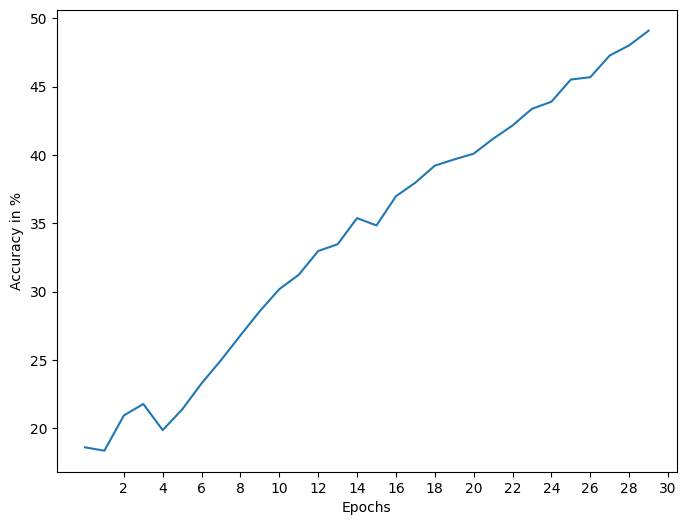

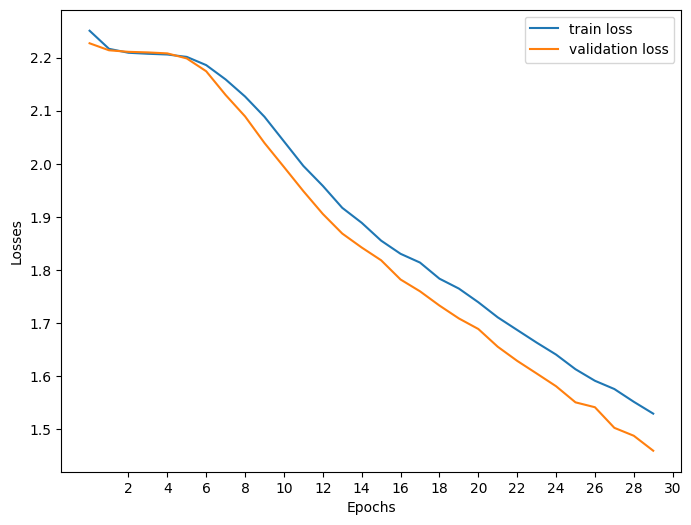

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [00:59<28:58, 59.94s/it]


epoch:   1, loss: 2.19686, valid loss: 2.12833, valid accruacy: 21.203%
Validation loss decreased (inf --> 2.128329). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [01:59<27:50, 59.67s/it]


epoch:   2, loss: 2.08298, valid loss: 1.97800, valid accruacy: 30.181%
Validation loss decreased (2.128329 --> 1.977999). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:57<26:37, 59.16s/it]


epoch:   3, loss: 1.97579, valid loss: 1.88701, valid accruacy: 33.983%
Validation loss decreased (1.977999 --> 1.887007). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:55<25:26, 58.71s/it]


epoch:   4, loss: 1.90758, valid loss: 1.83412, valid accruacy: 35.606%
Validation loss decreased (1.887007 --> 1.834118). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:53<24:17, 58.29s/it]


epoch:   5, loss: 1.85770, valid loss: 1.78456, valid accruacy: 37.326%
Validation loss decreased (1.834118 --> 1.784557). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [05:53<23:33, 58.90s/it]


epoch:   6, loss: 1.82127, valid loss: 1.75391, valid accruacy: 38.357%
Validation loss decreased (1.784557 --> 1.753912). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:52<22:31, 58.74s/it]


epoch:   7, loss: 1.79167, valid loss: 1.71840, valid accruacy: 39.771%
Validation loss decreased (1.753912 --> 1.718399). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:50<21:29, 58.63s/it]


epoch:   8, loss: 1.76513, valid loss: 1.70197, valid accruacy: 40.535%
Validation loss decreased (1.718399 --> 1.701973). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:48<20:28, 58.48s/it]


epoch:   9, loss: 1.73940, valid loss: 1.67098, valid accruacy: 41.471%
Validation loss decreased (1.701973 --> 1.670977). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:47<19:30, 58.54s/it]


epoch:  10, loss: 1.71862, valid loss: 1.65142, valid accruacy: 42.235%
Validation loss decreased (1.670977 --> 1.651418). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:45<18:32, 58.57s/it]


epoch:  11, loss: 1.69810, valid loss: 1.63333, valid accruacy: 42.904%
Validation loss decreased (1.651418 --> 1.633333). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:45<17:37, 58.76s/it]


epoch:  12, loss: 1.67603, valid loss: 1.60678, valid accruacy: 43.859%
Validation loss decreased (1.633333 --> 1.606785). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:44<16:42, 58.99s/it]


epoch:  13, loss: 1.65119, valid loss: 1.58650, valid accruacy: 45.005%
Validation loss decreased (1.606785 --> 1.586495). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:43<15:44, 59.02s/it]


epoch:  14, loss: 1.63518, valid loss: 1.56507, valid accruacy: 45.673%
Validation loss decreased (1.586495 --> 1.565072). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [14:43<14:47, 59.19s/it]


epoch:  15, loss: 1.61752, valid loss: 1.54295, valid accruacy: 46.896%
Validation loss decreased (1.565072 --> 1.542952). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [15:42<13:50, 59.32s/it]


epoch:  16, loss: 1.60218, valid loss: 1.53148, valid accruacy: 46.819%
Validation loss decreased (1.542952 --> 1.531476). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [16:42<12:52, 59.39s/it]


epoch:  17, loss: 1.57825, valid loss: 1.51425, valid accruacy: 47.775%
Validation loss decreased (1.531476 --> 1.514253). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [17:44<12:02, 60.19s/it]


epoch:  18, loss: 1.56707, valid loss: 1.50448, valid accruacy: 48.080%
Validation loss decreased (1.514253 --> 1.504479). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [18:43<10:59, 59.98s/it]


epoch:  19, loss: 1.54774, valid loss: 1.47847, valid accruacy: 48.902%
Validation loss decreased (1.504479 --> 1.478471). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [19:43<09:58, 59.87s/it]


epoch:  20, loss: 1.53077, valid loss: 1.46554, valid accruacy: 49.647%
Validation loss decreased (1.478471 --> 1.465542). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [20:43<08:57, 59.78s/it]


epoch:  21, loss: 1.51611, valid loss: 1.45327, valid accruacy: 49.799%
Validation loss decreased (1.465542 --> 1.453269). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [21:42<07:58, 59.78s/it]


epoch:  22, loss: 1.49800, valid loss: 1.42889, valid accruacy: 51.098%
Validation loss decreased (1.453269 --> 1.428892). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [22:42<06:58, 59.79s/it]


epoch:  23, loss: 1.48127, valid loss: 1.42566, valid accruacy: 51.366%
Validation loss decreased (1.428892 --> 1.425656). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [23:43<06:01, 60.18s/it]


epoch:  24, loss: 1.47115, valid loss: 1.40426, valid accruacy: 51.691%
Validation loss decreased (1.425656 --> 1.404261). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [24:44<05:00, 60.19s/it]


epoch:  25, loss: 1.45613, valid loss: 1.38737, valid accruacy: 52.894%
Validation loss decreased (1.404261 --> 1.387375). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [25:43<03:59, 59.96s/it]


epoch:  26, loss: 1.44156, valid loss: 1.37461, valid accruacy: 53.104%
Validation loss decreased (1.387375 --> 1.374610). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [26:43<02:59, 59.85s/it]


epoch:  27, loss: 1.42722, valid loss: 1.36404, valid accruacy: 53.467%
Validation loss decreased (1.374610 --> 1.364036). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [27:43<01:59, 59.95s/it]


epoch:  28, loss: 1.41441, valid loss: 1.35301, valid accruacy: 54.575%
Validation loss decreased (1.364036 --> 1.353008). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [28:43<00:59, 59.97s/it]


epoch:  29, loss: 1.40328, valid loss: 1.33782, valid accruacy: 53.887%
Validation loss decreased (1.353008 --> 1.337815). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [29:43<00:00, 59.44s/it]


epoch:  30, loss: 1.38781, valid loss: 1.32838, valid accruacy: 55.110%
Validation loss decreased (1.337815 --> 1.328382). Saving model...
Fit time: 1783.1303613185883 s


Test loss: 1.34379	Test accruacy: 53.303%
Saving model


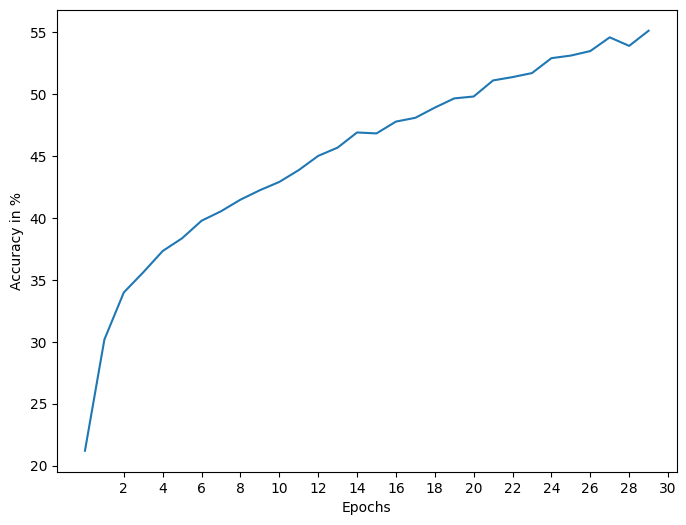

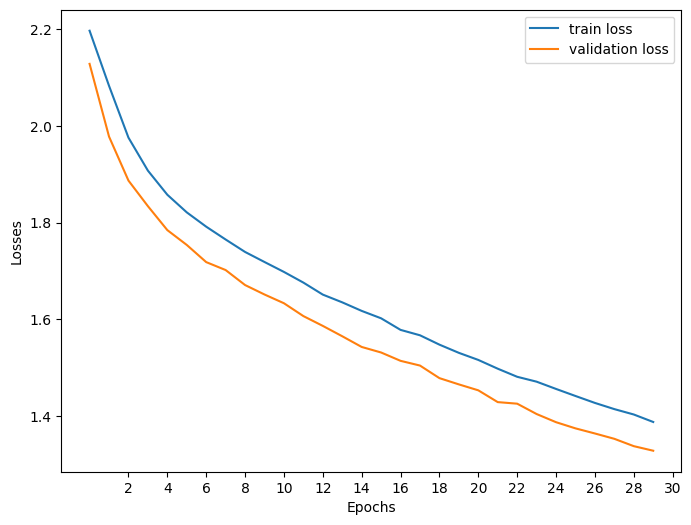

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [00:59<28:51, 59.71s/it]


epoch:   1, loss: 2.19793, valid loss: 2.11638, valid accruacy: 24.298%
Validation loss decreased (inf --> 2.116383). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [01:59<27:57, 59.92s/it]


epoch:   2, loss: 2.06965, valid loss: 1.95988, valid accruacy: 32.034%
Validation loss decreased (2.116383 --> 1.959876). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:58<26:46, 59.50s/it]


epoch:   3, loss: 1.96032, valid loss: 1.88265, valid accruacy: 33.964%
Validation loss decreased (1.959876 --> 1.882649). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:58<25:52, 59.73s/it]


epoch:   4, loss: 1.89453, valid loss: 1.81446, valid accruacy: 36.695%
Validation loss decreased (1.882649 --> 1.814458). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:58<24:52, 59.71s/it]


epoch:   5, loss: 1.85400, valid loss: 1.78733, valid accruacy: 38.166%
Validation loss decreased (1.814458 --> 1.787327). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [05:58<23:53, 59.71s/it]


epoch:   6, loss: 1.81815, valid loss: 1.74701, valid accruacy: 38.376%
Validation loss decreased (1.787327 --> 1.747006). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:57<22:49, 59.53s/it]


epoch:   7, loss: 1.79240, valid loss: 1.71625, valid accruacy: 39.179%
Validation loss decreased (1.747006 --> 1.716248). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:57<21:53, 59.71s/it]


epoch:   8, loss: 1.77059, valid loss: 1.68470, valid accruacy: 40.439%
Validation loss decreased (1.716248 --> 1.684703). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:56<20:50, 59.54s/it]


epoch:   9, loss: 1.74485, valid loss: 1.67299, valid accruacy: 41.146%
Validation loss decreased (1.684703 --> 1.672992). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:55<19:47, 59.40s/it]


epoch:  10, loss: 1.72020, valid loss: 1.65708, valid accruacy: 42.178%
Validation loss decreased (1.672992 --> 1.657076). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:54<18:47, 59.32s/it]


epoch:  11, loss: 1.70334, valid loss: 1.62652, valid accruacy: 43.305%
Validation loss decreased (1.657076 --> 1.626517). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:54<17:50, 59.49s/it]


epoch:  12, loss: 1.68715, valid loss: 1.61534, valid accruacy: 43.534%
Validation loss decreased (1.626517 --> 1.615338). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:54<16:51, 59.52s/it]


epoch:  13, loss: 1.66156, valid loss: 1.58254, valid accruacy: 44.413%
Validation loss decreased (1.615338 --> 1.582536). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:54<15:53, 59.57s/it]


epoch:  14, loss: 1.64391, valid loss: 1.57184, valid accruacy: 45.903%
Validation loss decreased (1.582536 --> 1.571844). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [14:53<14:53, 59.56s/it]


epoch:  15, loss: 1.62476, valid loss: 1.55126, valid accruacy: 46.571%
Validation loss decreased (1.571844 --> 1.551257). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [15:53<13:56, 59.76s/it]


epoch:  16, loss: 1.60952, valid loss: 1.53398, valid accruacy: 46.514%
Validation loss decreased (1.551257 --> 1.533976). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [16:53<12:57, 59.77s/it]


epoch:  17, loss: 1.59035, valid loss: 1.51301, valid accruacy: 47.775%
Validation loss decreased (1.533976 --> 1.513009). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [17:54<12:00, 60.06s/it]


epoch:  18, loss: 1.57210, valid loss: 1.49372, valid accruacy: 48.348%
Validation loss decreased (1.513009 --> 1.493715). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [18:54<11:00, 60.04s/it]


epoch:  19, loss: 1.55229, valid loss: 1.47752, valid accruacy: 49.188%
Validation loss decreased (1.493715 --> 1.477515). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [19:53<09:58, 59.83s/it]


epoch:  20, loss: 1.53505, valid loss: 1.45626, valid accruacy: 50.258%
Validation loss decreased (1.477515 --> 1.456264). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [20:53<08:57, 59.70s/it]


epoch:  21, loss: 1.52307, valid loss: 1.43954, valid accruacy: 51.461%
Validation loss decreased (1.456264 --> 1.439542). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [21:53<07:58, 59.87s/it]


epoch:  22, loss: 1.50861, valid loss: 1.42697, valid accruacy: 51.977%
Validation loss decreased (1.439542 --> 1.426967). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [22:53<06:59, 59.94s/it]


epoch:  23, loss: 1.48587, valid loss: 1.40801, valid accruacy: 52.034%
Validation loss decreased (1.426967 --> 1.408010). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [23:52<05:58, 59.80s/it]


epoch:  24, loss: 1.47429, valid loss: 1.38990, valid accruacy: 52.970%
Validation loss decreased (1.408010 --> 1.389902). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [24:52<04:58, 59.67s/it]


epoch:  25, loss: 1.45616, valid loss: 1.36942, valid accruacy: 53.773%
Validation loss decreased (1.389902 --> 1.369424). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [25:51<03:58, 59.68s/it]


epoch:  26, loss: 1.44385, valid loss: 1.36025, valid accruacy: 54.078%
Validation loss decreased (1.369424 --> 1.360253). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [26:52<02:59, 59.83s/it]


epoch:  27, loss: 1.42450, valid loss: 1.34791, valid accruacy: 54.193%
Validation loss decreased (1.360253 --> 1.347906). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [27:52<02:00, 60.07s/it]


epoch:  28, loss: 1.41669, valid loss: 1.32965, valid accruacy: 54.537%
Validation loss decreased (1.347906 --> 1.329646). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [28:52<01:00, 60.03s/it]


epoch:  29, loss: 1.40428, valid loss: 1.31430, valid accruacy: 56.027%
Validation loss decreased (1.329646 --> 1.314301). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [29:53<00:00, 59.78s/it]


epoch:  30, loss: 1.38317, valid loss: 1.30390, valid accruacy: 55.989%
Validation loss decreased (1.314301 --> 1.303898). Saving model...
Fit time: 1793.3076632022858 s


Test loss: 1.33390	Test accruacy: 54.792%
Saving model


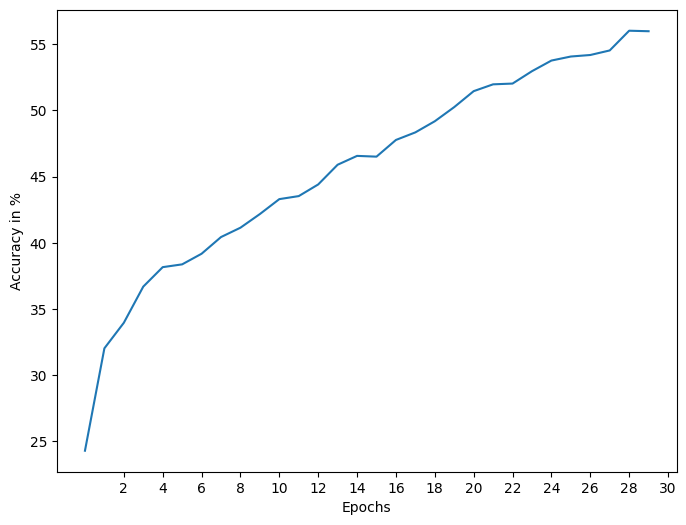

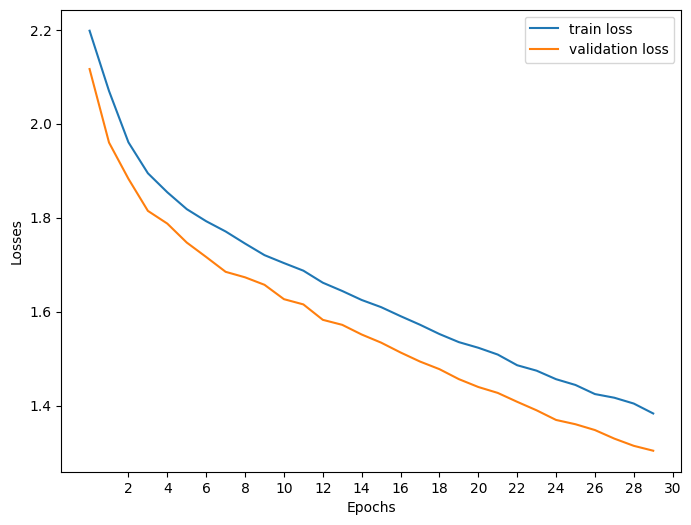

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [01:00<29:20, 60.71s/it]


epoch:   1, loss: 2.28280, valid loss: 2.27578, valid accruacy: 18.586%
Validation loss decreased (inf --> 2.275777). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [02:04<29:13, 62.62s/it]


epoch:   2, loss: 2.27280, valid loss: 2.26565, valid accruacy: 18.586%
Validation loss decreased (2.275777 --> 2.265649). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [03:03<27:29, 61.08s/it]


epoch:   3, loss: 2.26390, valid loss: 2.25679, valid accruacy: 18.586%
Validation loss decreased (2.265649 --> 2.256789). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [04:02<26:06, 60.26s/it]


epoch:   4, loss: 2.25623, valid loss: 2.24909, valid accruacy: 18.586%
Validation loss decreased (2.256789 --> 2.249091). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [05:02<25:01, 60.07s/it]


epoch:   5, loss: 2.24986, valid loss: 2.24238, valid accruacy: 18.586%
Validation loss decreased (2.249091 --> 2.242382). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [06:04<24:13, 60.56s/it]


epoch:   6, loss: 2.24419, valid loss: 2.23655, valid accruacy: 18.586%
Validation loss decreased (2.242382 --> 2.236546). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [07:05<23:15, 60.67s/it]


epoch:   7, loss: 2.23913, valid loss: 2.23148, valid accruacy: 18.586%
Validation loss decreased (2.236546 --> 2.231475). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [08:04<22:03, 60.17s/it]


epoch:   8, loss: 2.23491, valid loss: 2.22707, valid accruacy: 18.586%
Validation loss decreased (2.231475 --> 2.227074). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [09:03<20:56, 59.83s/it]


epoch:   9, loss: 2.23145, valid loss: 2.22324, valid accruacy: 18.586%
Validation loss decreased (2.227074 --> 2.223241). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [10:02<19:52, 59.65s/it]


epoch:  10, loss: 2.22834, valid loss: 2.21996, valid accruacy: 18.586%
Validation loss decreased (2.223241 --> 2.219960). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [11:00<18:46, 59.29s/it]


epoch:  11, loss: 2.22558, valid loss: 2.21708, valid accruacy: 18.586%
Validation loss decreased (2.219960 --> 2.217078). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [12:00<17:46, 59.25s/it]


epoch:  12, loss: 2.22314, valid loss: 2.21462, valid accruacy: 18.586%
Validation loss decreased (2.217078 --> 2.214620). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [13:01<16:57, 59.86s/it]


epoch:  13, loss: 2.22135, valid loss: 2.21244, valid accruacy: 18.663%
Validation loss decreased (2.214620 --> 2.212443). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:59<15:50, 59.42s/it]


epoch:  14, loss: 2.21979, valid loss: 2.21060, valid accruacy: 18.758%
Validation loss decreased (2.212443 --> 2.210605). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [14:58<14:47, 59.19s/it]


epoch:  15, loss: 2.21820, valid loss: 2.20900, valid accruacy: 18.816%
Validation loss decreased (2.210605 --> 2.209004). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [15:57<13:49, 59.26s/it]


epoch:  16, loss: 2.21691, valid loss: 2.20759, valid accruacy: 18.930%
Validation loss decreased (2.209004 --> 2.207589). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [17:00<13:03, 60.30s/it]


epoch:  17, loss: 2.21585, valid loss: 2.20636, valid accruacy: 18.949%
Validation loss decreased (2.207589 --> 2.206356). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [18:08<12:29, 62.48s/it]


epoch:  18, loss: 2.21501, valid loss: 2.20531, valid accruacy: 19.484%
Validation loss decreased (2.206356 --> 2.205306). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [19:07<11:17, 61.57s/it]


epoch:  19, loss: 2.21418, valid loss: 2.20437, valid accruacy: 19.752%
Validation loss decreased (2.205306 --> 2.204374). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [20:07<10:11, 61.10s/it]


epoch:  20, loss: 2.21346, valid loss: 2.20355, valid accruacy: 20.458%
Validation loss decreased (2.204374 --> 2.203552). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [21:06<09:05, 60.59s/it]


epoch:  21, loss: 2.21318, valid loss: 2.20284, valid accruacy: 21.032%
Validation loss decreased (2.203552 --> 2.202845). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [22:07<08:03, 60.42s/it]


epoch:  22, loss: 2.21236, valid loss: 2.20222, valid accruacy: 20.974%
Validation loss decreased (2.202845 --> 2.202222). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [23:06<07:01, 60.16s/it]


epoch:  23, loss: 2.21189, valid loss: 2.20167, valid accruacy: 21.032%
Validation loss decreased (2.202222 --> 2.201665). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [24:07<06:02, 60.34s/it]


epoch:  24, loss: 2.21168, valid loss: 2.20117, valid accruacy: 21.146%
Validation loss decreased (2.201665 --> 2.201173). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [25:07<05:00, 60.15s/it]


epoch:  25, loss: 2.21110, valid loss: 2.20073, valid accruacy: 21.547%
Validation loss decreased (2.201173 --> 2.200727). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [26:06<04:00, 60.02s/it]


epoch:  26, loss: 2.21078, valid loss: 2.20033, valid accruacy: 21.624%
Validation loss decreased (2.200727 --> 2.200326). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [27:06<02:59, 59.85s/it]


epoch:  27, loss: 2.21070, valid loss: 2.19997, valid accruacy: 21.624%
Validation loss decreased (2.200326 --> 2.199967). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [28:04<01:59, 59.52s/it]


epoch:  28, loss: 2.21056, valid loss: 2.19964, valid accruacy: 21.662%
Validation loss decreased (2.199967 --> 2.199643). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [29:03<00:59, 59.33s/it]


epoch:  29, loss: 2.21020, valid loss: 2.19935, valid accruacy: 21.777%
Validation loss decreased (2.199643 --> 2.199347). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [30:02<00:00, 60.07s/it]


epoch:  30, loss: 2.20999, valid loss: 2.19907, valid accruacy: 21.719%
Validation loss decreased (2.199347 --> 2.199070). Saving model...
Fit time: 1802.2398674488068 s


Test loss: 2.21861	Test accruacy: 20.924%
Saving model


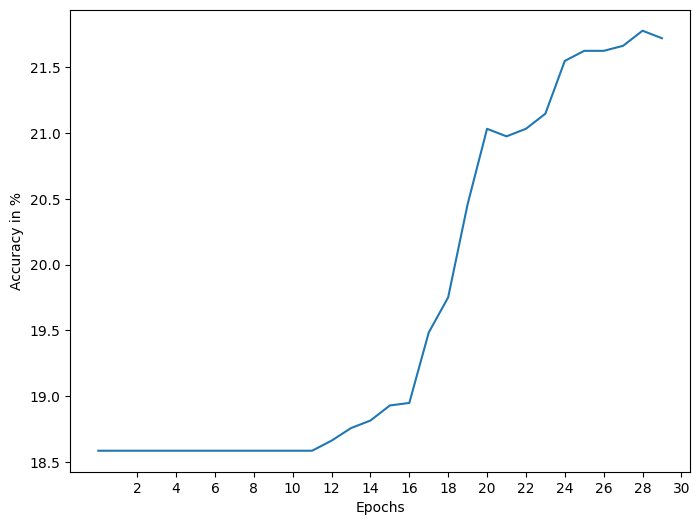

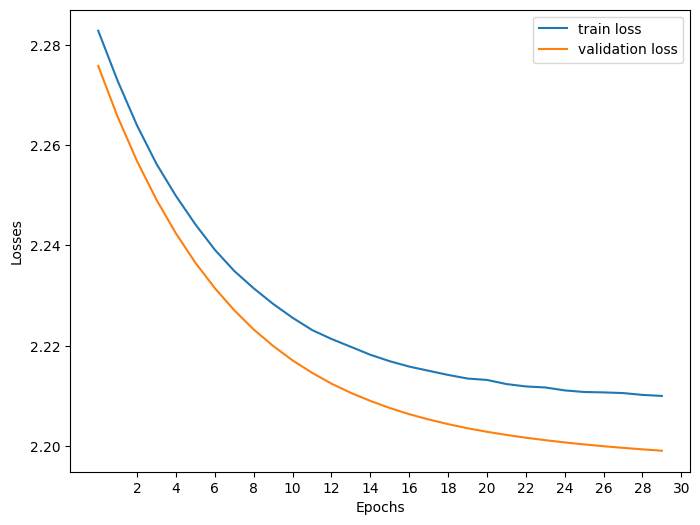

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:57<18:14, 57.63s/it]


epoch:   1, loss: 2.01085, valid loss: 1.78162, valid accruacy: 38.338%
Validation loss decreased (inf --> 1.781625). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:54<17:10, 57.24s/it]


epoch:   2, loss: 1.77304, valid loss: 1.63572, valid accruacy: 42.770%
Validation loss decreased (1.781625 --> 1.635721). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:51<16:07, 56.92s/it]


epoch:   3, loss: 1.65306, valid loss: 1.52540, valid accruacy: 46.915%
Validation loss decreased (1.635721 --> 1.525400). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:47<15:08, 56.75s/it]


epoch:   4, loss: 1.55976, valid loss: 1.43477, valid accruacy: 50.793%
Validation loss decreased (1.525400 --> 1.434768). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:44<14:10, 56.72s/it]


epoch:   5, loss: 1.47524, valid loss: 1.39342, valid accruacy: 52.684%
Validation loss decreased (1.434768 --> 1.393416). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:41<13:17, 56.94s/it]


epoch:   6, loss: 1.41691, valid loss: 1.30294, valid accruacy: 56.237%
Validation loss decreased (1.393416 --> 1.302937). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:39<12:23, 57.22s/it]


epoch:   7, loss: 1.35493, valid loss: 1.22983, valid accruacy: 58.415%
Validation loss decreased (1.302937 --> 1.229827). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:36<11:27, 57.27s/it]


epoch:   8, loss: 1.29679, valid loss: 1.19778, valid accruacy: 59.331%
Validation loss decreased (1.229827 --> 1.197783). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:33<10:29, 57.20s/it]


epoch:   9, loss: 1.24436, valid loss: 1.12623, valid accruacy: 63.400%
Validation loss decreased (1.197783 --> 1.126227). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:30<09:31, 57.14s/it]


epoch:  10, loss: 1.19070, valid loss: 1.08583, valid accruacy: 64.565%
Validation loss decreased (1.126227 --> 1.085831). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:28<08:36, 57.34s/it]


epoch:  11, loss: 1.14410, valid loss: 1.03989, valid accruacy: 65.463%
Validation loss decreased (1.085831 --> 1.039887). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:26<07:40, 57.54s/it]


epoch:  12, loss: 1.09103, valid loss: 0.98295, valid accruacy: 67.985%
Validation loss decreased (1.039887 --> 0.982948). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [12:24<06:44, 57.74s/it]


epoch:  13, loss: 1.04428, valid loss: 0.95891, valid accruacy: 69.551%
Validation loss decreased (0.982948 --> 0.958911). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [13:22<05:46, 57.80s/it]


epoch:  14, loss: 1.00784, valid loss: 0.91689, valid accruacy: 71.003%
Validation loss decreased (0.958911 --> 0.916887). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [14:20<04:48, 57.79s/it]


epoch:  15, loss: 0.97065, valid loss: 0.88938, valid accruacy: 72.397%
Validation loss decreased (0.916887 --> 0.889385). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [15:18<03:51, 57.84s/it]


epoch:  16, loss: 0.92427, valid loss: 0.85343, valid accruacy: 73.849%
Validation loss decreased (0.889385 --> 0.853431). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [16:17<02:54, 58.03s/it]


epoch:  17, loss: 0.87797, valid loss: 0.82182, valid accruacy: 74.441%
Validation loss decreased (0.853431 --> 0.821821). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [17:14<01:55, 57.94s/it]


epoch:  18, loss: 0.85368, valid loss: 0.81671, valid accruacy: 75.606%
Validation loss decreased (0.821821 --> 0.816715). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [18:12<00:57, 57.85s/it]


epoch:  19, loss: 0.82459, valid loss: 0.79255, valid accruacy: 76.199%
Validation loss decreased (0.816715 --> 0.792548). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:09<00:00, 57.47s/it]


epoch:  20, loss: 0.79654, valid loss: 0.78104, valid accruacy: 76.944%
Validation loss decreased (0.792548 --> 0.781045). Saving model...
Fit time: 1149.4805176258087 s


Test loss: 0.74618	Test accruacy: 78.580%
Saving model


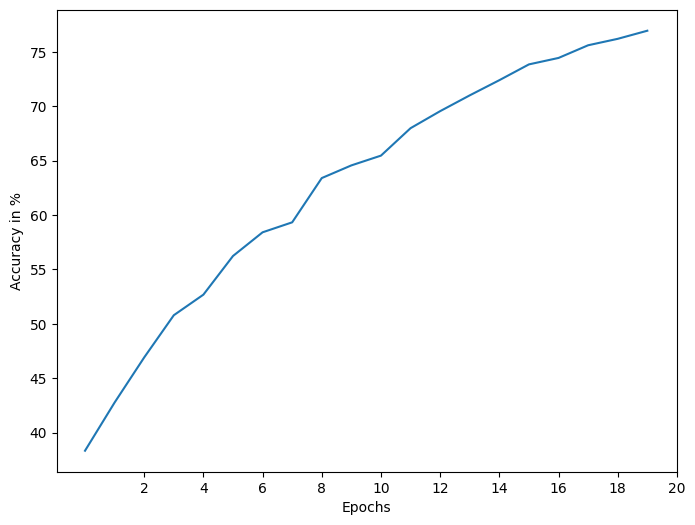

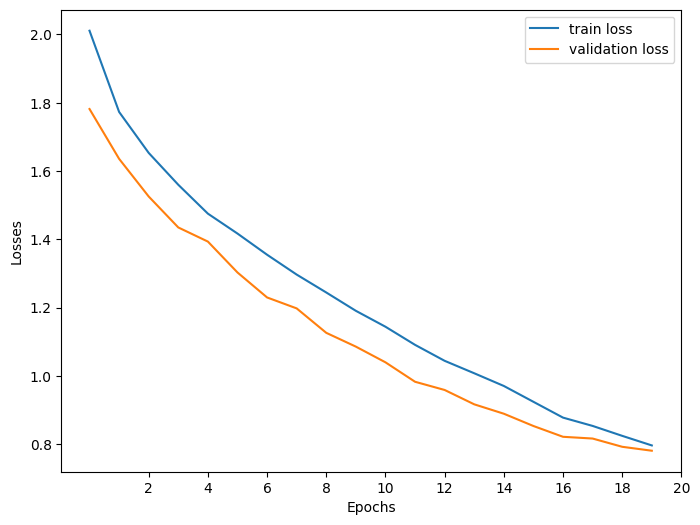

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:58<18:28, 58.34s/it]


epoch:   1, loss: 2.02186, valid loss: 1.82520, valid accruacy: 35.836%
Validation loss decreased (inf --> 1.825202). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:55<17:15, 57.55s/it]


epoch:   2, loss: 1.77044, valid loss: 1.62178, valid accruacy: 43.916%
Validation loss decreased (1.825202 --> 1.621784). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:53<16:22, 57.78s/it]


epoch:   3, loss: 1.62727, valid loss: 1.50586, valid accruacy: 47.889%
Validation loss decreased (1.621784 --> 1.505863). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:50<15:21, 57.59s/it]


epoch:   4, loss: 1.53046, valid loss: 1.40564, valid accruacy: 51.977%
Validation loss decreased (1.505863 --> 1.405643). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:47<14:20, 57.38s/it]


epoch:   5, loss: 1.44183, valid loss: 1.34572, valid accruacy: 53.104%
Validation loss decreased (1.405643 --> 1.345720). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:44<13:20, 57.21s/it]


epoch:   6, loss: 1.37271, valid loss: 1.26993, valid accruacy: 56.428%
Validation loss decreased (1.345720 --> 1.269934). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:42<12:26, 57.45s/it]


epoch:   7, loss: 1.30362, valid loss: 1.18524, valid accruacy: 59.828%
Validation loss decreased (1.269934 --> 1.185240). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:40<11:31, 57.61s/it]


epoch:   8, loss: 1.24449, valid loss: 1.13555, valid accruacy: 62.273%
Validation loss decreased (1.185240 --> 1.135551). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:38<10:33, 57.62s/it]


epoch:   9, loss: 1.19205, valid loss: 1.10115, valid accruacy: 63.228%
Validation loss decreased (1.135551 --> 1.101155). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:38<09:44, 58.43s/it]


epoch:  10, loss: 1.14069, valid loss: 1.01461, valid accruacy: 65.922%
Validation loss decreased (1.101155 --> 1.014606). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:35<08:42, 58.10s/it]


epoch:  11, loss: 1.08573, valid loss: 0.97090, valid accruacy: 68.118%
Validation loss decreased (1.014606 --> 0.970900). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:33<07:42, 57.86s/it]


epoch:  12, loss: 1.05188, valid loss: 0.97514, valid accruacy: 67.927%


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [12:30<06:43, 57.68s/it]


epoch:  13, loss: 0.99863, valid loss: 0.89350, valid accruacy: 70.735%
Validation loss decreased (0.970900 --> 0.893498). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [13:27<05:45, 57.60s/it]


epoch:  14, loss: 0.95879, valid loss: 0.85507, valid accruacy: 72.818%
Validation loss decreased (0.893498 --> 0.855070). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [14:24<04:46, 57.34s/it]


epoch:  15, loss: 0.92430, valid loss: 0.81947, valid accruacy: 73.715%
Validation loss decreased (0.855070 --> 0.819471). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [15:21<03:48, 57.25s/it]


epoch:  16, loss: 0.86819, valid loss: 0.82275, valid accruacy: 74.288%


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [16:19<02:52, 57.47s/it]


epoch:  17, loss: 0.85713, valid loss: 0.78452, valid accruacy: 75.759%
Validation loss decreased (0.819471 --> 0.784521). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [17:18<01:56, 58.00s/it]


epoch:  18, loss: 0.81922, valid loss: 0.76935, valid accruacy: 75.664%
Validation loss decreased (0.784521 --> 0.769350). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [18:16<00:58, 58.04s/it]


epoch:  19, loss: 0.78478, valid loss: 0.74340, valid accruacy: 77.230%
Validation loss decreased (0.769350 --> 0.743402). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:14<00:00, 57.72s/it]


epoch:  20, loss: 0.75978, valid loss: 0.71137, valid accruacy: 78.911%
Validation loss decreased (0.743402 --> 0.711371). Saving model...
Fit time: 1154.4951586723328 s


Test loss: 0.65876	Test accruacy: 80.565%
Saving model


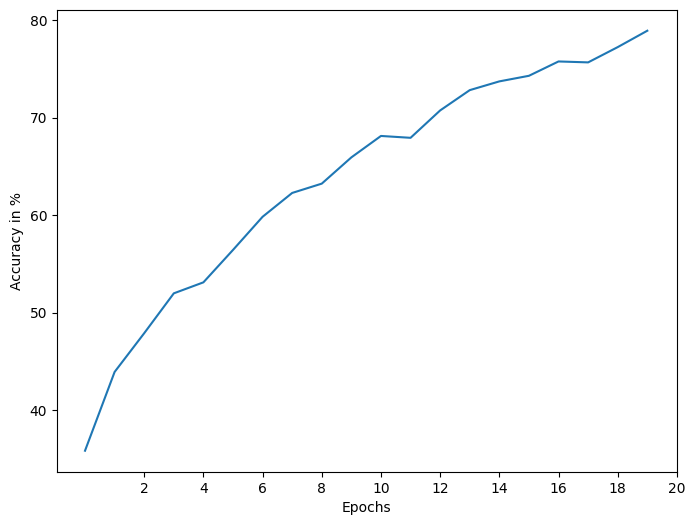

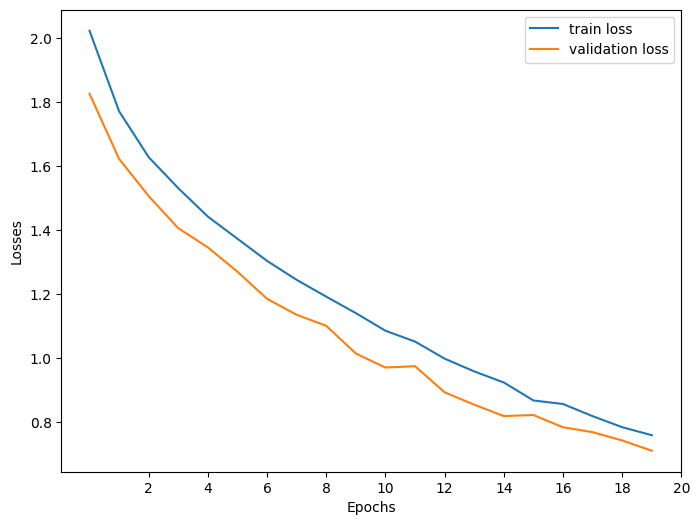

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:57<18:19, 57.88s/it]


epoch:   1, loss: 2.27498, valid loss: 2.25254, valid accruacy: 17.994%
Validation loss decreased (inf --> 2.252541). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:55<17:21, 57.86s/it]


epoch:   2, loss: 2.23805, valid loss: 2.22809, valid accruacy: 18.682%
Validation loss decreased (2.252541 --> 2.228094). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:53<16:24, 57.93s/it]


epoch:   3, loss: 2.22082, valid loss: 2.21696, valid accruacy: 18.472%
Validation loss decreased (2.228094 --> 2.216960). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:52<15:31, 58.24s/it]


epoch:   4, loss: 2.21273, valid loss: 2.21199, valid accruacy: 18.777%
Validation loss decreased (2.216960 --> 2.211993). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:50<14:31, 58.10s/it]


epoch:   5, loss: 2.20915, valid loss: 2.20968, valid accruacy: 18.777%
Validation loss decreased (2.211993 --> 2.209681). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:48<13:35, 58.22s/it]


epoch:   6, loss: 2.20757, valid loss: 2.20857, valid accruacy: 18.777%
Validation loss decreased (2.209681 --> 2.208568). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:47<12:37, 58.28s/it]


epoch:   7, loss: 2.20654, valid loss: 2.20791, valid accruacy: 18.777%
Validation loss decreased (2.208568 --> 2.207907). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:45<11:40, 58.38s/it]


epoch:   8, loss: 2.20619, valid loss: 2.20745, valid accruacy: 18.777%
Validation loss decreased (2.207907 --> 2.207453). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:45<10:45, 58.70s/it]


epoch:   9, loss: 2.20573, valid loss: 2.20707, valid accruacy: 18.777%
Validation loss decreased (2.207453 --> 2.207069). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:44<09:49, 58.96s/it]


epoch:  10, loss: 2.20544, valid loss: 2.20657, valid accruacy: 18.949%
Validation loss decreased (2.207069 --> 2.206573). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:42<08:48, 58.69s/it]


epoch:  11, loss: 2.20479, valid loss: 2.20572, valid accruacy: 18.816%
Validation loss decreased (2.206573 --> 2.205719). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:40<07:48, 58.53s/it]


epoch:  12, loss: 2.20342, valid loss: 2.20381, valid accruacy: 20.210%
Validation loss decreased (2.205719 --> 2.203811). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [12:39<06:50, 58.67s/it]


epoch:  13, loss: 2.19980, valid loss: 2.19768, valid accruacy: 20.802%
Validation loss decreased (2.203811 --> 2.197683). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [13:38<05:51, 58.54s/it]


epoch:  14, loss: 2.19085, valid loss: 2.18377, valid accruacy: 22.292%
Validation loss decreased (2.197683 --> 2.183768). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [14:36<04:52, 58.40s/it]


epoch:  15, loss: 2.17889, valid loss: 2.16814, valid accruacy: 21.872%
Validation loss decreased (2.183768 --> 2.168139). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [15:35<03:54, 58.75s/it]


epoch:  16, loss: 2.16579, valid loss: 2.14822, valid accruacy: 22.789%
Validation loss decreased (2.168139 --> 2.148219). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [16:33<02:55, 58.46s/it]


epoch:  17, loss: 2.14822, valid loss: 2.12738, valid accruacy: 24.374%
Validation loss decreased (2.148219 --> 2.127384). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [17:31<01:56, 58.30s/it]


epoch:  18, loss: 2.12977, valid loss: 2.10992, valid accruacy: 24.699%
Validation loss decreased (2.127384 --> 2.109924). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [18:29<00:58, 58.30s/it]


epoch:  19, loss: 2.11478, valid loss: 2.09219, valid accruacy: 25.501%
Validation loss decreased (2.109924 --> 2.092194). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:27<00:00, 58.38s/it]


epoch:  20, loss: 2.10061, valid loss: 2.07790, valid accruacy: 26.418%
Validation loss decreased (2.092194 --> 2.077898). Saving model...
Fit time: 1167.6683139801025 s


Test loss: 2.06450	Test accruacy: 27.644%
Saving model


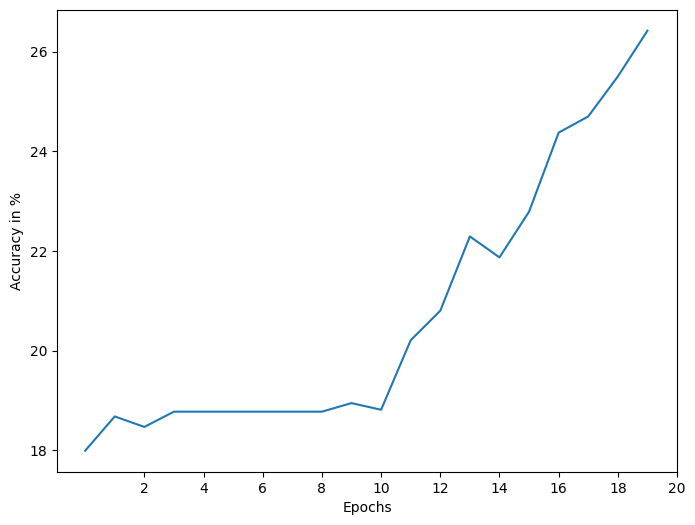

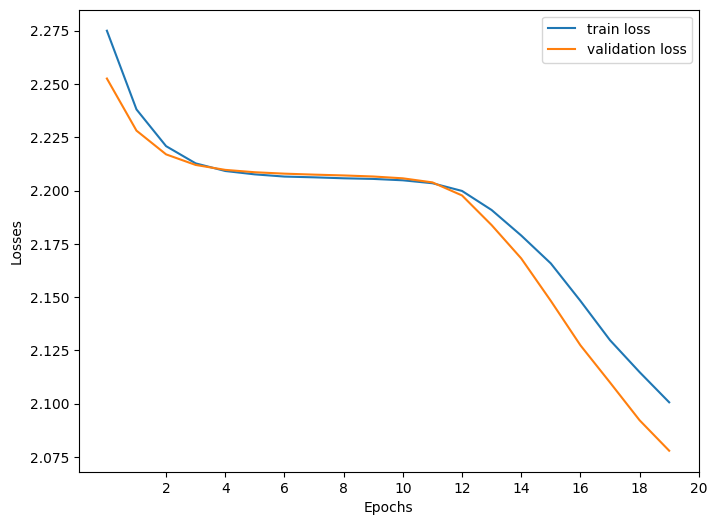

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:58<18:26, 58.24s/it]


epoch:   1, loss: 2.21341, valid loss: 2.15793, valid accruacy: 21.796%
Validation loss decreased (inf --> 2.157928). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:55<17:21, 57.86s/it]


epoch:   2, loss: 2.10156, valid loss: 2.00834, valid accruacy: 29.952%
Validation loss decreased (2.157928 --> 2.008343). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:53<16:25, 58.00s/it]


epoch:   3, loss: 1.98734, valid loss: 1.91429, valid accruacy: 32.970%
Validation loss decreased (2.008343 --> 1.914289). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:52<15:29, 58.09s/it]


epoch:   4, loss: 1.91790, valid loss: 1.85127, valid accruacy: 35.110%
Validation loss decreased (1.914289 --> 1.851271). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:49<14:27, 57.84s/it]


epoch:   5, loss: 1.87453, valid loss: 1.81278, valid accruacy: 36.371%
Validation loss decreased (1.851271 --> 1.812776). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:47<13:29, 57.83s/it]


epoch:   6, loss: 1.83477, valid loss: 1.77673, valid accruacy: 37.574%
Validation loss decreased (1.812776 --> 1.776727). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:44<12:28, 57.61s/it]


epoch:   7, loss: 1.80966, valid loss: 1.74996, valid accruacy: 38.911%
Validation loss decreased (1.776727 --> 1.749963). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:42<11:32, 57.71s/it]


epoch:   8, loss: 1.78252, valid loss: 1.72468, valid accruacy: 40.191%
Validation loss decreased (1.749963 --> 1.724681). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:40<10:37, 57.93s/it]


epoch:   9, loss: 1.76661, valid loss: 1.70485, valid accruacy: 40.917%
Validation loss decreased (1.724681 --> 1.704853). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:38<09:38, 57.87s/it]


epoch:  10, loss: 1.74163, valid loss: 1.69030, valid accruacy: 41.184%
Validation loss decreased (1.704853 --> 1.690303). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:36<08:41, 57.90s/it]


epoch:  11, loss: 1.72757, valid loss: 1.66890, valid accruacy: 42.082%
Validation loss decreased (1.690303 --> 1.668904). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:34<07:42, 57.86s/it]


epoch:  12, loss: 1.71331, valid loss: 1.65715, valid accruacy: 42.464%
Validation loss decreased (1.668904 --> 1.657147). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [12:33<06:46, 58.08s/it]


epoch:  13, loss: 1.69406, valid loss: 1.64136, valid accruacy: 42.770%
Validation loss decreased (1.657147 --> 1.641361). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [13:30<05:47, 57.85s/it]


epoch:  14, loss: 1.68449, valid loss: 1.62970, valid accruacy: 43.610%
Validation loss decreased (1.641361 --> 1.629701). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [14:27<04:48, 57.79s/it]


epoch:  15, loss: 1.67229, valid loss: 1.61326, valid accruacy: 44.260%
Validation loss decreased (1.629701 --> 1.613256). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [15:25<03:50, 57.64s/it]


epoch:  16, loss: 1.65619, valid loss: 1.60133, valid accruacy: 44.088%
Validation loss decreased (1.613256 --> 1.601333). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [16:23<02:53, 57.83s/it]


epoch:  17, loss: 1.63918, valid loss: 1.58709, valid accruacy: 44.756%
Validation loss decreased (1.601333 --> 1.587092). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [17:21<01:55, 57.78s/it]


epoch:  18, loss: 1.62739, valid loss: 1.57364, valid accruacy: 44.814%
Validation loss decreased (1.587092 --> 1.573641). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [18:19<00:57, 57.94s/it]


epoch:  19, loss: 1.61831, valid loss: 1.56279, valid accruacy: 45.406%
Validation loss decreased (1.573641 --> 1.562793). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:17<00:00, 57.88s/it]


epoch:  20, loss: 1.60159, valid loss: 1.55163, valid accruacy: 45.692%
Validation loss decreased (1.562793 --> 1.551630). Saving model...
Fit time: 1157.6892018318176 s


Test loss: 1.55568	Test accruacy: 45.743%
Saving model


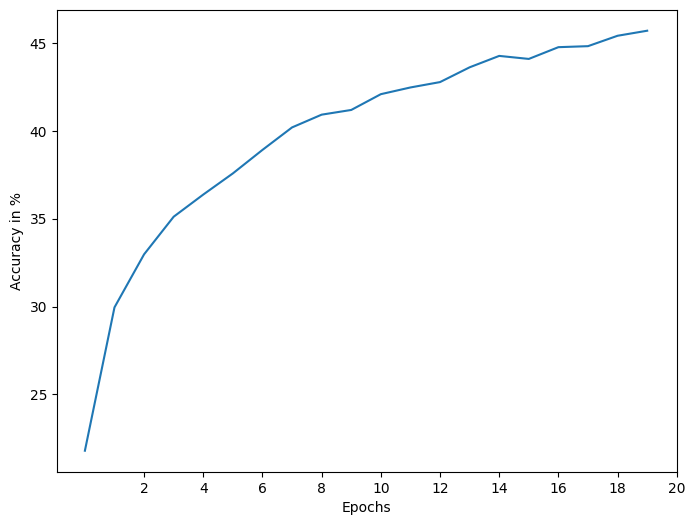

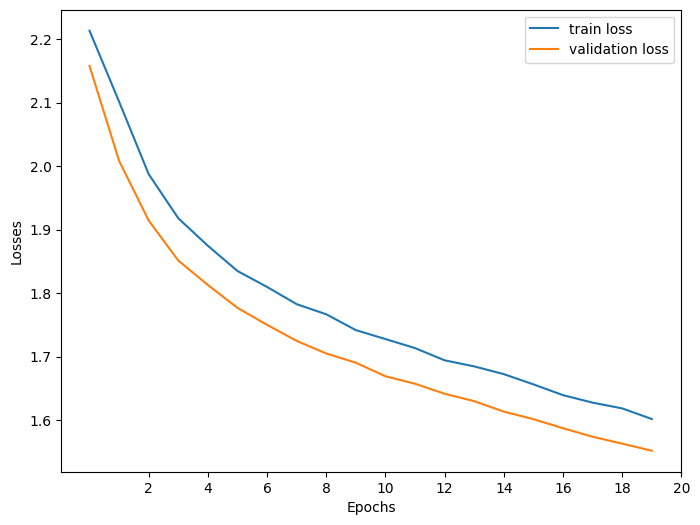

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:57<18:19, 57.86s/it]


epoch:   1, loss: 2.21573, valid loss: 2.15443, valid accruacy: 22.502%
Validation loss decreased (inf --> 2.154434). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:56<17:25, 58.08s/it]


epoch:   2, loss: 2.12510, valid loss: 2.04612, valid accruacy: 28.806%
Validation loss decreased (2.154434 --> 2.046118). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:54<16:27, 58.09s/it]


epoch:   3, loss: 2.03341, valid loss: 1.93875, valid accruacy: 32.779%
Validation loss decreased (2.046118 --> 1.938755). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:52<15:31, 58.20s/it]


epoch:   4, loss: 1.94910, valid loss: 1.87238, valid accruacy: 34.766%
Validation loss decreased (1.938755 --> 1.872375). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:51<14:35, 58.37s/it]


epoch:   5, loss: 1.90433, valid loss: 1.83577, valid accruacy: 36.027%
Validation loss decreased (1.872375 --> 1.835774). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:49<13:38, 58.46s/it]


epoch:   6, loss: 1.86958, valid loss: 1.80305, valid accruacy: 36.925%
Validation loss decreased (1.835774 --> 1.803047). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:48<12:38, 58.38s/it]


epoch:   7, loss: 1.84191, valid loss: 1.78081, valid accruacy: 38.090%
Validation loss decreased (1.803047 --> 1.780809). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:46<11:41, 58.43s/it]


epoch:   8, loss: 1.81840, valid loss: 1.75411, valid accruacy: 38.128%
Validation loss decreased (1.780809 --> 1.754112). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:45<10:44, 58.59s/it]


epoch:   9, loss: 1.80382, valid loss: 1.74053, valid accruacy: 39.752%
Validation loss decreased (1.754112 --> 1.740534). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:44<09:47, 58.77s/it]


epoch:  10, loss: 1.78379, valid loss: 1.72011, valid accruacy: 40.076%
Validation loss decreased (1.740534 --> 1.720113). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:43<08:49, 58.84s/it]


epoch:  11, loss: 1.76895, valid loss: 1.70554, valid accruacy: 40.783%
Validation loss decreased (1.720113 --> 1.705541). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:41<07:49, 58.64s/it]


epoch:  12, loss: 1.74578, valid loss: 1.68037, valid accruacy: 41.624%
Validation loss decreased (1.705541 --> 1.680369). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [12:40<06:49, 58.53s/it]


epoch:  13, loss: 1.73860, valid loss: 1.67254, valid accruacy: 42.159%
Validation loss decreased (1.680369 --> 1.672536). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [13:38<05:51, 58.56s/it]


epoch:  14, loss: 1.72235, valid loss: 1.65029, valid accruacy: 42.942%
Validation loss decreased (1.672536 --> 1.650287). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [14:37<04:52, 58.44s/it]


epoch:  15, loss: 1.70357, valid loss: 1.63747, valid accruacy: 43.305%
Validation loss decreased (1.650287 --> 1.637473). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [15:34<03:52, 58.21s/it]


epoch:  16, loss: 1.69196, valid loss: 1.62448, valid accruacy: 43.649%
Validation loss decreased (1.637473 --> 1.624485). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [16:32<02:54, 58.10s/it]


epoch:  17, loss: 1.67349, valid loss: 1.60605, valid accruacy: 44.546%
Validation loss decreased (1.624485 --> 1.606047). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [17:30<01:56, 58.01s/it]


epoch:  18, loss: 1.66523, valid loss: 1.59623, valid accruacy: 44.947%
Validation loss decreased (1.606047 --> 1.596231). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [18:30<00:58, 58.67s/it]


epoch:  19, loss: 1.65112, valid loss: 1.58095, valid accruacy: 45.272%
Validation loss decreased (1.596231 --> 1.580952). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:28<00:00, 58.43s/it]


epoch:  20, loss: 1.63350, valid loss: 1.56780, valid accruacy: 45.864%
Validation loss decreased (1.580952 --> 1.567803). Saving model...
Fit time: 1168.6129257678986 s


Test loss: 1.60398	Test accruacy: 43.872%
Saving model


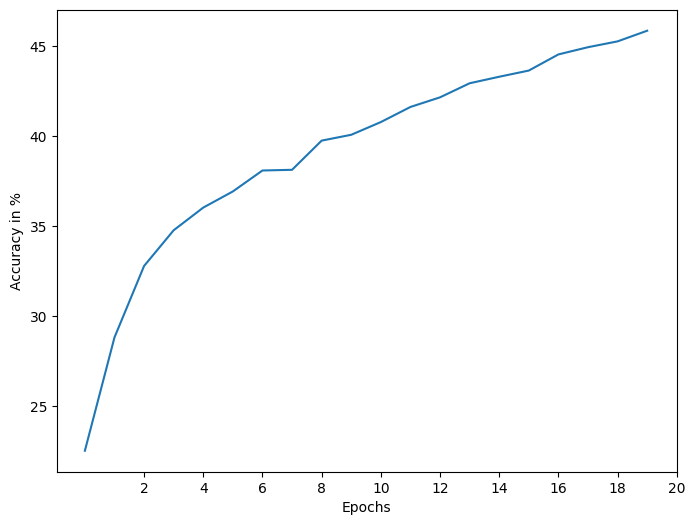

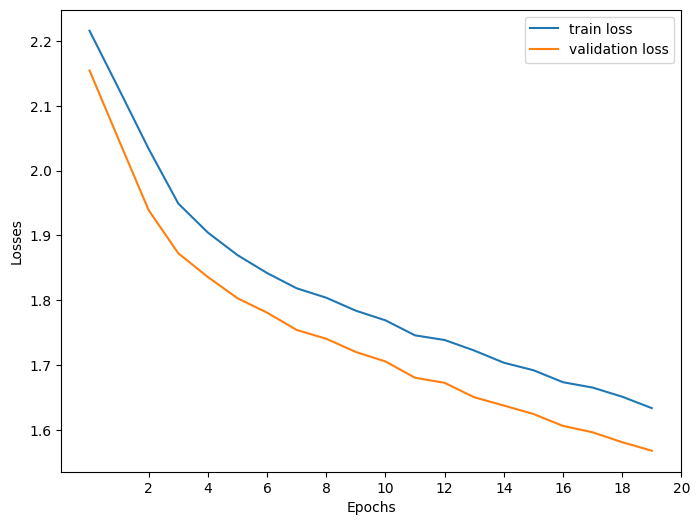

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [00:57<18:12, 57.51s/it]


epoch:   1, loss: 2.29869, valid loss: 2.29509, valid accruacy: 14.174%
Validation loss decreased (inf --> 2.295094). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [01:56<17:25, 58.10s/it]


epoch:   2, loss: 2.29242, valid loss: 2.28880, valid accruacy: 18.491%
Validation loss decreased (2.295094 --> 2.288795). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [02:53<16:25, 57.96s/it]


epoch:   3, loss: 2.28646, valid loss: 2.28290, valid accruacy: 18.529%
Validation loss decreased (2.288795 --> 2.282897). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [03:51<15:23, 57.74s/it]


epoch:   4, loss: 2.28096, valid loss: 2.27736, valid accruacy: 18.548%
Validation loss decreased (2.282897 --> 2.277356). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [04:48<14:25, 57.68s/it]


epoch:   5, loss: 2.27603, valid loss: 2.27222, valid accruacy: 18.548%
Validation loss decreased (2.277356 --> 2.272220). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [05:46<13:25, 57.53s/it]


epoch:   6, loss: 2.27120, valid loss: 2.26743, valid accruacy: 18.548%
Validation loss decreased (2.272220 --> 2.267433). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [06:43<12:27, 57.53s/it]


epoch:   7, loss: 2.26671, valid loss: 2.26293, valid accruacy: 18.548%
Validation loss decreased (2.267433 --> 2.262926). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [07:40<11:29, 57.42s/it]


epoch:   8, loss: 2.26249, valid loss: 2.25870, valid accruacy: 18.548%
Validation loss decreased (2.262926 --> 2.258696). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [08:37<10:30, 57.35s/it]


epoch:   9, loss: 2.25858, valid loss: 2.25483, valid accruacy: 18.548%
Validation loss decreased (2.258696 --> 2.254829). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [09:36<09:36, 57.66s/it]


epoch:  10, loss: 2.25504, valid loss: 2.25119, valid accruacy: 18.548%
Validation loss decreased (2.254829 --> 2.251191). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [10:35<08:43, 58.12s/it]


epoch:  11, loss: 2.25169, valid loss: 2.24780, valid accruacy: 18.548%
Validation loss decreased (2.251191 --> 2.247801). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [11:32<07:42, 57.85s/it]


epoch:  12, loss: 2.24856, valid loss: 2.24466, valid accruacy: 18.548%
Validation loss decreased (2.247801 --> 2.244660). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [12:30<06:44, 57.72s/it]


epoch:  13, loss: 2.24572, valid loss: 2.24171, valid accruacy: 18.548%
Validation loss decreased (2.244660 --> 2.241708). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [13:27<05:45, 57.57s/it]


epoch:  14, loss: 2.24297, valid loss: 2.23898, valid accruacy: 18.548%
Validation loss decreased (2.241708 --> 2.238980). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [14:24<04:47, 57.54s/it]


epoch:  15, loss: 2.24045, valid loss: 2.23643, valid accruacy: 18.548%
Validation loss decreased (2.238980 --> 2.236434). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [15:22<03:50, 57.58s/it]


epoch:  16, loss: 2.23842, valid loss: 2.23408, valid accruacy: 18.548%
Validation loss decreased (2.236434 --> 2.234076). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [16:20<02:52, 57.56s/it]


epoch:  17, loss: 2.23599, valid loss: 2.23189, valid accruacy: 18.548%
Validation loss decreased (2.234076 --> 2.231889). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [17:18<01:55, 57.96s/it]


epoch:  18, loss: 2.23403, valid loss: 2.22985, valid accruacy: 18.548%
Validation loss decreased (2.231889 --> 2.229849). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [18:16<00:57, 57.91s/it]


epoch:  19, loss: 2.23225, valid loss: 2.22796, valid accruacy: 18.548%
Validation loss decreased (2.229849 --> 2.227962). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:14<00:00, 57.74s/it]


epoch:  20, loss: 2.23060, valid loss: 2.22622, valid accruacy: 18.548%
Validation loss decreased (2.227962 --> 2.226220). Saving model...
Fit time: 1154.8269453048706 s


Test loss: 2.22844	Test accruacy: 18.557%
Saving model


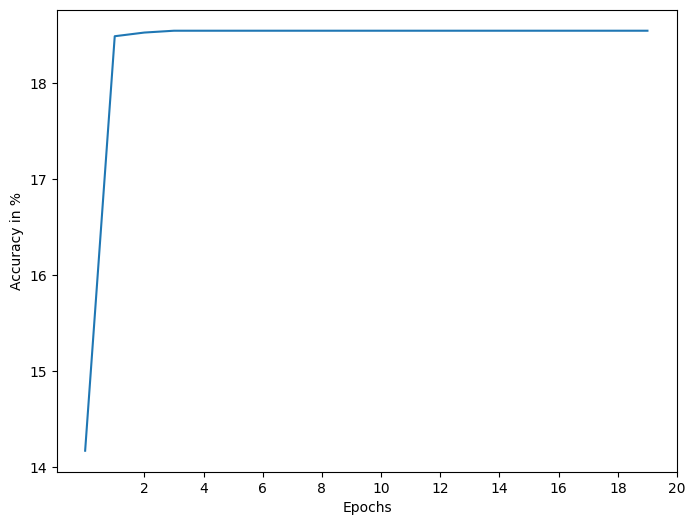

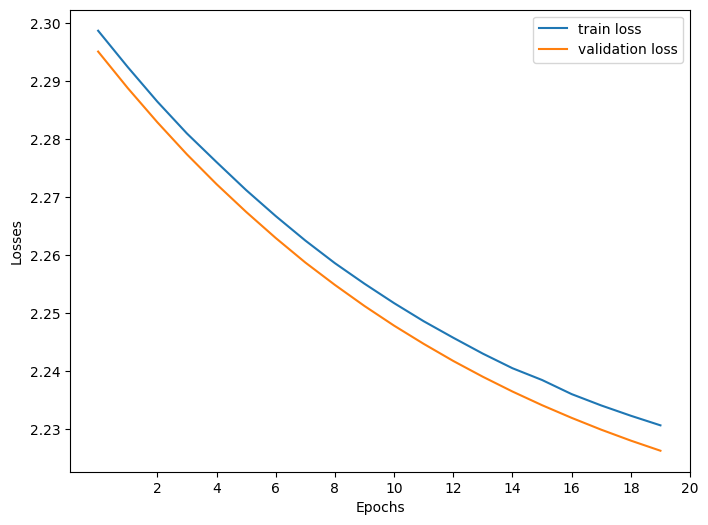

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [00:58<28:07, 58.21s/it]


epoch:   1, loss: 2.01866, valid loss: 1.80013, valid accruacy: 35.530%
Validation loss decreased (inf --> 1.800130). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [01:55<26:54, 57.65s/it]


epoch:   2, loss: 1.77438, valid loss: 1.64983, valid accruacy: 42.216%
Validation loss decreased (1.800130 --> 1.649826). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:53<26:01, 57.83s/it]


epoch:   3, loss: 1.64893, valid loss: 1.53471, valid accruacy: 46.953%
Validation loss decreased (1.649826 --> 1.534712). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:51<25:01, 57.75s/it]


epoch:   4, loss: 1.55058, valid loss: 1.45532, valid accruacy: 49.016%
Validation loss decreased (1.534712 --> 1.455322). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:49<24:07, 57.92s/it]


epoch:   5, loss: 1.47354, valid loss: 1.38296, valid accruacy: 52.512%
Validation loss decreased (1.455322 --> 1.382961). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [05:47<23:14, 58.08s/it]


epoch:   6, loss: 1.41422, valid loss: 1.30051, valid accruacy: 55.205%
Validation loss decreased (1.382961 --> 1.300510). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:45<22:12, 57.94s/it]


epoch:   7, loss: 1.34774, valid loss: 1.24143, valid accruacy: 57.230%
Validation loss decreased (1.300510 --> 1.241429). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:43<21:12, 57.86s/it]


epoch:   8, loss: 1.30211, valid loss: 1.18946, valid accruacy: 59.522%
Validation loss decreased (1.241429 --> 1.189461). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:41<20:19, 58.09s/it]


epoch:   9, loss: 1.23068, valid loss: 1.12997, valid accruacy: 62.330%
Validation loss decreased (1.189461 --> 1.129966). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:38<19:16, 57.84s/it]


epoch:  10, loss: 1.19056, valid loss: 1.09393, valid accruacy: 62.980%
Validation loss decreased (1.129966 --> 1.093925). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:36<18:16, 57.69s/it]


epoch:  11, loss: 1.12924, valid loss: 1.03979, valid accruacy: 65.043%
Validation loss decreased (1.093925 --> 1.039786). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:32<17:10, 57.23s/it]


epoch:  12, loss: 1.08877, valid loss: 0.98953, valid accruacy: 68.061%
Validation loss decreased (1.039786 --> 0.989528). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:29<16:09, 57.03s/it]


epoch:  13, loss: 1.04547, valid loss: 0.94244, valid accruacy: 69.819%
Validation loss decreased (0.989528 --> 0.942438). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:25<15:09, 56.85s/it]


epoch:  14, loss: 0.99593, valid loss: 0.90583, valid accruacy: 71.404%
Validation loss decreased (0.942438 --> 0.905825). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [14:21<14:10, 56.70s/it]


epoch:  15, loss: 0.96315, valid loss: 0.88745, valid accruacy: 72.569%
Validation loss decreased (0.905825 --> 0.887446). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [15:17<13:11, 56.50s/it]


epoch:  16, loss: 0.92454, valid loss: 0.91674, valid accruacy: 71.500%


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [16:14<12:13, 56.43s/it]


epoch:  17, loss: 0.88575, valid loss: 0.82729, valid accruacy: 74.957%
Validation loss decreased (0.887446 --> 0.827286). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [17:10<11:16, 56.42s/it]


epoch:  18, loss: 0.84695, valid loss: 0.80507, valid accruacy: 75.683%
Validation loss decreased (0.827286 --> 0.805071). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [18:06<10:20, 56.39s/it]


epoch:  19, loss: 0.82211, valid loss: 0.79096, valid accruacy: 76.218%
Validation loss decreased (0.805071 --> 0.790961). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [19:03<09:24, 56.41s/it]


epoch:  20, loss: 0.79152, valid loss: 0.76290, valid accruacy: 77.841%
Validation loss decreased (0.790961 --> 0.762900). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [20:00<08:28, 56.55s/it]


epoch:  21, loss: 0.75383, valid loss: 0.74504, valid accruacy: 78.472%
Validation loss decreased (0.762900 --> 0.745038). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [20:57<07:34, 56.82s/it]


epoch:  22, loss: 0.72750, valid loss: 0.74365, valid accruacy: 79.217%
Validation loss decreased (0.745038 --> 0.743652). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [21:54<06:38, 56.96s/it]


epoch:  23, loss: 0.71799, valid loss: 0.71075, valid accruacy: 80.898%
Validation loss decreased (0.743652 --> 0.710753). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [22:52<05:43, 57.19s/it]


epoch:  24, loss: 0.68500, valid loss: 0.70725, valid accruacy: 80.936%
Validation loss decreased (0.710753 --> 0.707247). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [23:50<04:46, 57.31s/it]


epoch:  25, loss: 0.66535, valid loss: 0.69839, valid accruacy: 81.242%
Validation loss decreased (0.707247 --> 0.698392). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [24:48<03:50, 57.54s/it]


epoch:  26, loss: 0.64662, valid loss: 0.68890, valid accruacy: 81.681%
Validation loss decreased (0.698392 --> 0.688904). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [25:46<02:53, 57.78s/it]


epoch:  27, loss: 0.64259, valid loss: 0.69869, valid accruacy: 82.178%


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [26:44<01:55, 57.74s/it]


epoch:  28, loss: 0.61933, valid loss: 0.67705, valid accruacy: 82.770%
Validation loss decreased (0.688904 --> 0.677052). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [27:41<00:57, 57.65s/it]


epoch:  29, loss: 0.59515, valid loss: 0.66988, valid accruacy: 83.534%
Validation loss decreased (0.677052 --> 0.669878). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [28:38<00:00, 57.29s/it]


epoch:  30, loss: 0.56807, valid loss: 0.66506, valid accruacy: 83.114%
Validation loss decreased (0.669878 --> 0.665059). Saving model...
Fit time: 1718.800154209137 s


Test loss: 0.66723	Test accruacy: 82.016%
Saving model


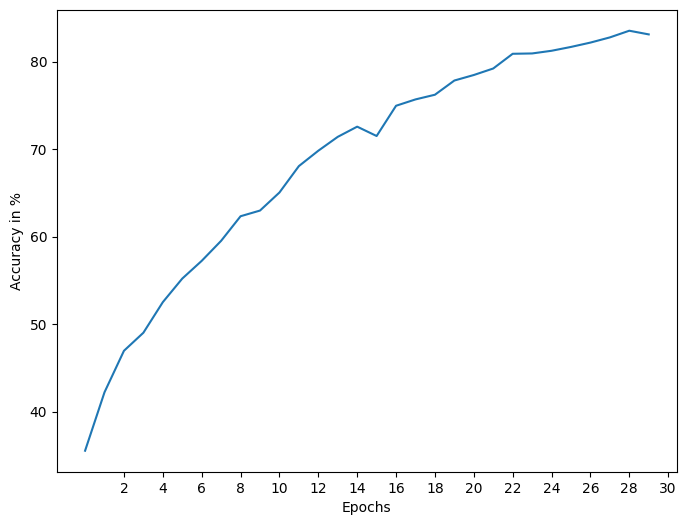

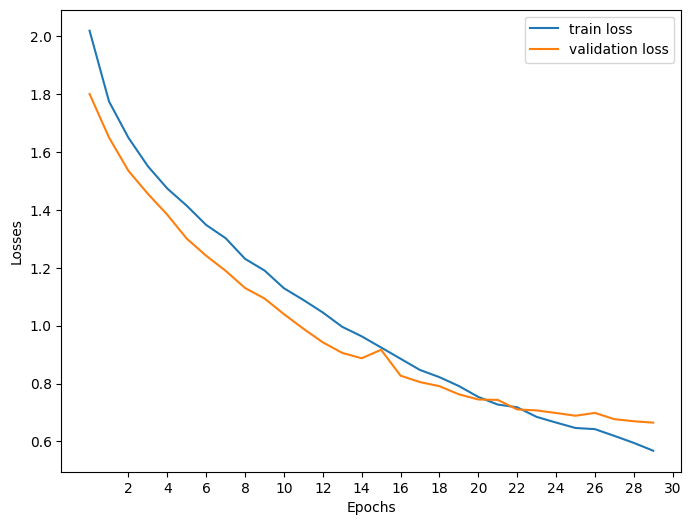

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [00:59<28:33, 59.07s/it]


epoch:   1, loss: 2.02001, valid loss: 1.80730, valid accruacy: 36.485%
Validation loss decreased (inf --> 1.807298). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [01:58<27:32, 59.02s/it]


epoch:   2, loss: 1.78324, valid loss: 1.63198, valid accruacy: 42.942%
Validation loss decreased (1.807298 --> 1.631978). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:57<26:37, 59.17s/it]


epoch:   3, loss: 1.64822, valid loss: 1.49424, valid accruacy: 47.736%
Validation loss decreased (1.631978 --> 1.494238). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:55<25:31, 58.90s/it]


epoch:   4, loss: 1.53963, valid loss: 1.39228, valid accruacy: 51.977%
Validation loss decreased (1.494238 --> 1.392284). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:53<24:24, 58.58s/it]


epoch:   5, loss: 1.46042, valid loss: 1.32681, valid accruacy: 53.620%
Validation loss decreased (1.392284 --> 1.326814). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [05:53<23:31, 58.83s/it]


epoch:   6, loss: 1.37887, valid loss: 1.23023, valid accruacy: 58.338%
Validation loss decreased (1.326814 --> 1.230233). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:51<22:30, 58.71s/it]


epoch:   7, loss: 1.31516, valid loss: 1.18866, valid accruacy: 59.981%
Validation loss decreased (1.230233 --> 1.188662). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:50<21:29, 58.61s/it]


epoch:   8, loss: 1.26070, valid loss: 1.13321, valid accruacy: 61.624%
Validation loss decreased (1.188662 --> 1.133206). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:48<20:28, 58.51s/it]


epoch:   9, loss: 1.20643, valid loss: 1.09072, valid accruacy: 63.400%
Validation loss decreased (1.133206 --> 1.090718). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:47<19:32, 58.61s/it]


epoch:  10, loss: 1.15524, valid loss: 1.03242, valid accruacy: 66.380%
Validation loss decreased (1.090718 --> 1.032421). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:47<18:44, 59.18s/it]


epoch:  11, loss: 1.11042, valid loss: 0.99155, valid accruacy: 68.138%
Validation loss decreased (1.032421 --> 0.991546). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:46<17:45, 59.17s/it]


epoch:  12, loss: 1.06561, valid loss: 0.94595, valid accruacy: 69.780%
Validation loss decreased (0.991546 --> 0.945954). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:44<16:40, 58.84s/it]


epoch:  13, loss: 1.01577, valid loss: 0.90872, valid accruacy: 71.117%
Validation loss decreased (0.945954 --> 0.908725). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:42<15:37, 58.61s/it]


epoch:  14, loss: 0.96459, valid loss: 0.88730, valid accruacy: 72.932%
Validation loss decreased (0.908725 --> 0.887300). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [14:41<14:36, 58.46s/it]


epoch:  15, loss: 0.92842, valid loss: 0.83853, valid accruacy: 73.811%
Validation loss decreased (0.887300 --> 0.838530). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [15:39<13:37, 58.42s/it]


epoch:  16, loss: 0.88758, valid loss: 0.82091, valid accruacy: 75.263%
Validation loss decreased (0.838530 --> 0.820912). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [16:37<12:38, 58.36s/it]


epoch:  17, loss: 0.85100, valid loss: 0.77774, valid accruacy: 76.504%
Validation loss decreased (0.820912 --> 0.777737). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [17:35<11:40, 58.33s/it]


epoch:  18, loss: 0.82036, valid loss: 0.76952, valid accruacy: 77.421%
Validation loss decreased (0.777737 --> 0.769522). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [18:33<10:40, 58.23s/it]


epoch:  19, loss: 0.78923, valid loss: 0.76743, valid accruacy: 77.345%
Validation loss decreased (0.769522 --> 0.767435). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [19:32<09:42, 58.27s/it]


epoch:  20, loss: 0.74960, valid loss: 0.72541, valid accruacy: 79.217%
Validation loss decreased (0.767435 --> 0.725407). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [20:30<08:44, 58.32s/it]


epoch:  21, loss: 0.71589, valid loss: 0.75837, valid accruacy: 78.758%


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [21:29<07:46, 58.35s/it]


epoch:  22, loss: 0.71568, valid loss: 0.69501, valid accruacy: 80.993%
Validation loss decreased (0.725407 --> 0.695005). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [22:28<06:51, 58.79s/it]


epoch:  23, loss: 0.69321, valid loss: 0.69959, valid accruacy: 80.764%


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [23:27<05:52, 58.72s/it]


epoch:  24, loss: 0.65279, valid loss: 0.72297, valid accruacy: 80.076%


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [24:25<04:52, 58.52s/it]


epoch:  25, loss: 0.64499, valid loss: 0.68988, valid accruacy: 81.987%
Validation loss decreased (0.695005 --> 0.689884). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [25:23<03:53, 58.41s/it]


epoch:  26, loss: 0.61734, valid loss: 0.67971, valid accruacy: 81.815%
Validation loss decreased (0.689884 --> 0.679711). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [26:21<02:54, 58.30s/it]


epoch:  27, loss: 0.60003, valid loss: 0.69388, valid accruacy: 81.624%


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [27:20<01:56, 58.48s/it]


epoch:  28, loss: 0.58912, valid loss: 0.66438, valid accruacy: 83.095%
Validation loss decreased (0.679711 --> 0.664378). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [28:18<00:58, 58.37s/it]


epoch:  29, loss: 0.56808, valid loss: 0.66182, valid accruacy: 83.190%
Validation loss decreased (0.664378 --> 0.661821). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [29:18<00:00, 58.60s/it]


epoch:  30, loss: 0.56465, valid loss: 0.65079, valid accruacy: 83.266%
Validation loss decreased (0.661821 --> 0.650785). Saving model...
Fit time: 1758.1113543510437 s


Test loss: 0.63928	Test accruacy: 83.543%
Saving model


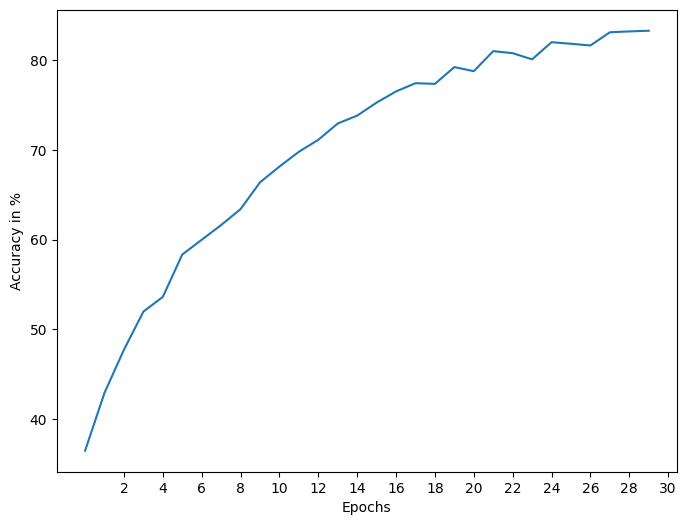

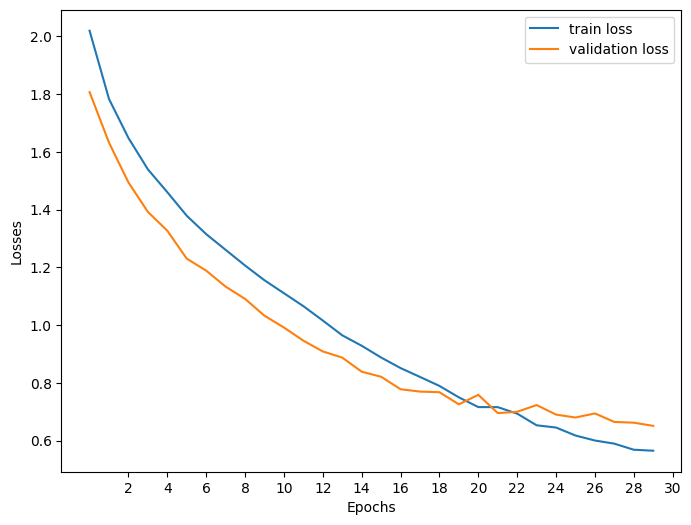

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [00:57<28:00, 57.96s/it]


epoch:   1, loss: 2.27386, valid loss: 2.25220, valid accruacy: 18.453%
Validation loss decreased (inf --> 2.252200). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [01:55<26:52, 57.60s/it]


epoch:   2, loss: 2.23916, valid loss: 2.22882, valid accruacy: 18.453%
Validation loss decreased (2.252200 --> 2.228823). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:52<25:52, 57.50s/it]


epoch:   3, loss: 2.22256, valid loss: 2.21825, valid accruacy: 18.453%
Validation loss decreased (2.228823 --> 2.218247). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:50<24:55, 57.50s/it]


epoch:   4, loss: 2.21532, valid loss: 2.21337, valid accruacy: 18.453%
Validation loss decreased (2.218247 --> 2.213368). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:47<23:56, 57.46s/it]


epoch:   5, loss: 2.21177, valid loss: 2.21092, valid accruacy: 18.453%
Validation loss decreased (2.213368 --> 2.210916). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [05:44<22:58, 57.42s/it]


epoch:   6, loss: 2.20974, valid loss: 2.20921, valid accruacy: 18.453%
Validation loss decreased (2.210916 --> 2.209212). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:42<22:03, 57.56s/it]


epoch:   7, loss: 2.20751, valid loss: 2.20669, valid accruacy: 21.146%
Validation loss decreased (2.209212 --> 2.206689). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:41<21:12, 57.86s/it]


epoch:   8, loss: 2.20399, valid loss: 2.20096, valid accruacy: 20.917%
Validation loss decreased (2.206689 --> 2.200961). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:39<20:18, 58.01s/it]


epoch:   9, loss: 2.19818, valid loss: 2.19161, valid accruacy: 21.223%
Validation loss decreased (2.200961 --> 2.191613). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:37<19:21, 58.09s/it]


epoch:  10, loss: 2.19016, valid loss: 2.18090, valid accruacy: 21.433%
Validation loss decreased (2.191613 --> 2.180901). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:36<18:25, 58.19s/it]


epoch:  11, loss: 2.17966, valid loss: 2.16567, valid accruacy: 21.757%
Validation loss decreased (2.180901 --> 2.165668). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:34<17:27, 58.21s/it]


epoch:  12, loss: 2.16345, valid loss: 2.14373, valid accruacy: 22.617%
Validation loss decreased (2.165668 --> 2.143734). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:32<16:28, 58.14s/it]


epoch:  13, loss: 2.14673, valid loss: 2.12361, valid accruacy: 24.489%
Validation loss decreased (2.143734 --> 2.123610). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:30<15:27, 57.94s/it]


epoch:  14, loss: 2.12833, valid loss: 2.09766, valid accruacy: 25.673%
Validation loss decreased (2.123610 --> 2.097663). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [14:26<14:24, 57.64s/it]


epoch:  15, loss: 2.11063, valid loss: 2.07454, valid accruacy: 26.648%
Validation loss decreased (2.097663 --> 2.074544). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [15:23<13:23, 57.36s/it]


epoch:  16, loss: 2.09059, valid loss: 2.05383, valid accruacy: 27.603%
Validation loss decreased (2.074544 --> 2.053833). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [16:20<12:24, 57.30s/it]


epoch:  17, loss: 2.06867, valid loss: 2.02676, valid accruacy: 28.424%
Validation loss decreased (2.053833 --> 2.026758). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [17:18<11:27, 57.27s/it]


epoch:  18, loss: 2.04710, valid loss: 1.99692, valid accruacy: 30.277%
Validation loss decreased (2.026758 --> 1.996917). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [18:15<10:30, 57.28s/it]


epoch:  19, loss: 2.02608, valid loss: 1.97223, valid accruacy: 30.697%
Validation loss decreased (1.996917 --> 1.972230). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [19:11<09:30, 57.05s/it]


epoch:  20, loss: 2.00077, valid loss: 1.94873, valid accruacy: 32.283%
Validation loss decreased (1.972230 --> 1.948727). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [20:08<08:33, 57.01s/it]


epoch:  21, loss: 1.97728, valid loss: 1.91692, valid accruacy: 33.047%
Validation loss decreased (1.948727 --> 1.916920). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [21:05<07:34, 56.86s/it]


epoch:  22, loss: 1.95453, valid loss: 1.89658, valid accruacy: 33.486%
Validation loss decreased (1.916920 --> 1.896583). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [22:03<06:41, 57.31s/it]


epoch:  23, loss: 1.93647, valid loss: 1.88123, valid accruacy: 34.040%
Validation loss decreased (1.896583 --> 1.881231). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [23:00<05:42, 57.16s/it]


epoch:  24, loss: 1.91921, valid loss: 1.86039, valid accruacy: 34.881%
Validation loss decreased (1.881231 --> 1.860390). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [23:56<04:44, 56.93s/it]


epoch:  25, loss: 1.90950, valid loss: 1.84666, valid accruacy: 34.766%
Validation loss decreased (1.860390 --> 1.846664). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [24:53<03:47, 56.84s/it]


epoch:  26, loss: 1.88853, valid loss: 1.82973, valid accruacy: 35.549%
Validation loss decreased (1.846664 --> 1.829726). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [25:50<02:50, 56.92s/it]


epoch:  27, loss: 1.87616, valid loss: 1.81534, valid accruacy: 36.199%
Validation loss decreased (1.829726 --> 1.815345). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [26:48<01:54, 57.10s/it]


epoch:  28, loss: 1.86588, valid loss: 1.80740, valid accruacy: 36.734%
Validation loss decreased (1.815345 --> 1.807396). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [27:45<00:57, 57.33s/it]


epoch:  29, loss: 1.85277, valid loss: 1.79576, valid accruacy: 36.867%
Validation loss decreased (1.807396 --> 1.795764). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [28:43<00:00, 57.45s/it]


epoch:  30, loss: 1.84327, valid loss: 1.79258, valid accruacy: 36.562%
Validation loss decreased (1.795764 --> 1.792582). Saving model...
Fit time: 1723.4023904800415 s


Test loss: 1.78587	Test accruacy: 36.388%
Saving model


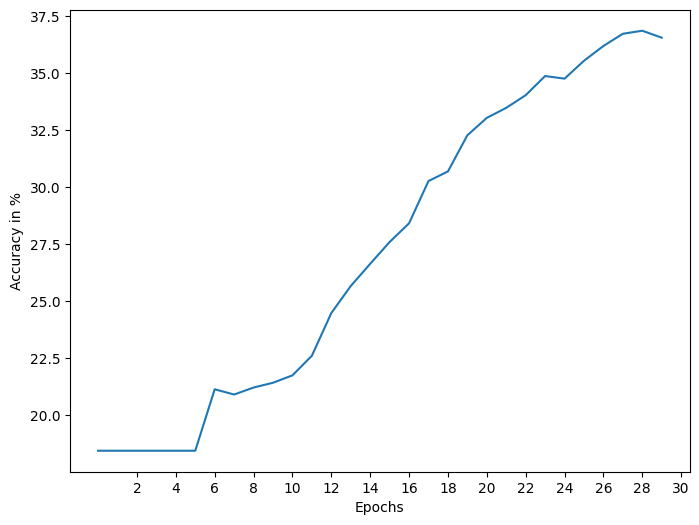

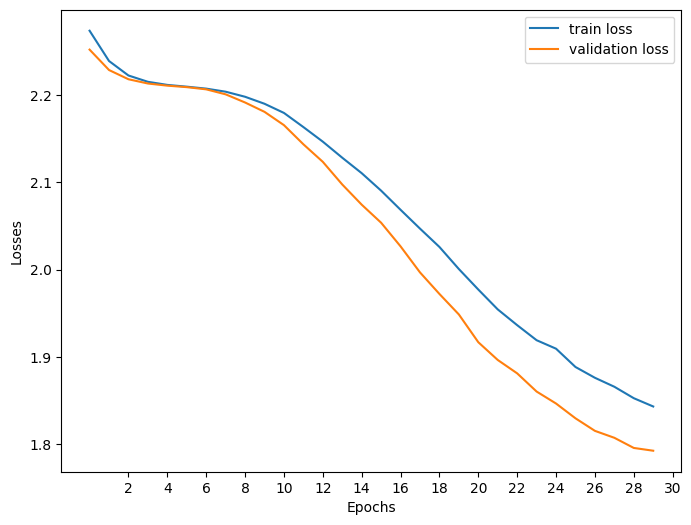

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [00:58<28:14, 58.43s/it]


epoch:   1, loss: 2.21690, valid loss: 2.16198, valid accruacy: 21.815%
Validation loss decreased (inf --> 2.161975). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [01:57<27:20, 58.59s/it]


epoch:   2, loss: 2.12127, valid loss: 2.04158, valid accruacy: 29.436%
Validation loss decreased (2.161975 --> 2.041580). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:56<26:25, 58.74s/it]


epoch:   3, loss: 2.03512, valid loss: 1.96976, valid accruacy: 32.550%
Validation loss decreased (2.041580 --> 1.969765). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:54<25:28, 58.78s/it]


epoch:   4, loss: 1.97654, valid loss: 1.92331, valid accruacy: 34.002%
Validation loss decreased (1.969765 --> 1.923311). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:54<24:34, 58.97s/it]


epoch:   5, loss: 1.93793, valid loss: 1.87763, valid accruacy: 34.747%
Validation loss decreased (1.923311 --> 1.877629). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [05:53<23:37, 59.05s/it]


epoch:   6, loss: 1.90190, valid loss: 1.84285, valid accruacy: 35.568%
Validation loss decreased (1.877629 --> 1.842846). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:52<22:36, 58.97s/it]


epoch:   7, loss: 1.87791, valid loss: 1.81881, valid accruacy: 36.428%
Validation loss decreased (1.842846 --> 1.818811). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:53<21:52, 59.64s/it]


epoch:   8, loss: 1.85149, valid loss: 1.80138, valid accruacy: 37.326%
Validation loss decreased (1.818811 --> 1.801378). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:52<20:50, 59.52s/it]


epoch:   9, loss: 1.83441, valid loss: 1.77809, valid accruacy: 37.650%
Validation loss decreased (1.801378 --> 1.778092). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:51<19:47, 59.40s/it]


epoch:  10, loss: 1.81868, valid loss: 1.75649, valid accruacy: 38.988%
Validation loss decreased (1.778092 --> 1.756488). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:50<18:45, 59.25s/it]


epoch:  11, loss: 1.80440, valid loss: 1.74881, valid accruacy: 38.739%
Validation loss decreased (1.756488 --> 1.748807). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:50<17:50, 59.45s/it]


epoch:  12, loss: 1.78349, valid loss: 1.72496, valid accruacy: 40.382%
Validation loss decreased (1.748807 --> 1.724961). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:51<16:59, 59.95s/it]


epoch:  13, loss: 1.77054, valid loss: 1.70418, valid accruacy: 40.783%
Validation loss decreased (1.724961 --> 1.704181). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:51<15:57, 59.83s/it]


epoch:  14, loss: 1.75362, valid loss: 1.69284, valid accruacy: 41.700%
Validation loss decreased (1.704181 --> 1.692840). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [14:48<14:48, 59.21s/it]


epoch:  15, loss: 1.73876, valid loss: 1.67547, valid accruacy: 41.987%
Validation loss decreased (1.692840 --> 1.675473). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [15:43<13:30, 57.90s/it]


epoch:  16, loss: 1.72003, valid loss: 1.66157, valid accruacy: 42.235%
Validation loss decreased (1.675473 --> 1.661567). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [16:38<12:18, 56.81s/it]


epoch:  17, loss: 1.71187, valid loss: 1.64398, valid accruacy: 42.923%
Validation loss decreased (1.661567 --> 1.643979). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [17:33<11:15, 56.31s/it]


epoch:  18, loss: 1.70083, valid loss: 1.62824, valid accruacy: 43.515%
Validation loss decreased (1.643979 --> 1.628237). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [18:28<10:15, 55.92s/it]


epoch:  19, loss: 1.68609, valid loss: 1.62514, valid accruacy: 43.878%
Validation loss decreased (1.628237 --> 1.625142). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [19:23<09:17, 55.73s/it]


epoch:  20, loss: 1.66977, valid loss: 1.60200, valid accruacy: 44.585%
Validation loss decreased (1.625142 --> 1.602004). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [20:19<08:21, 55.67s/it]


epoch:  21, loss: 1.66032, valid loss: 1.59452, valid accruacy: 44.699%
Validation loss decreased (1.602004 --> 1.594519). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [21:15<07:26, 55.81s/it]


epoch:  22, loss: 1.64399, valid loss: 1.58262, valid accruacy: 45.501%
Validation loss decreased (1.594519 --> 1.582619). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [22:11<06:32, 56.07s/it]


epoch:  23, loss: 1.63434, valid loss: 1.56561, valid accruacy: 46.055%
Validation loss decreased (1.582619 --> 1.565613). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [23:09<05:39, 56.51s/it]


epoch:  24, loss: 1.62651, valid loss: 1.55999, valid accruacy: 45.826%
Validation loss decreased (1.565613 --> 1.559992). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [24:09<04:47, 57.51s/it]


epoch:  25, loss: 1.61046, valid loss: 1.54556, valid accruacy: 46.323%
Validation loss decreased (1.559992 --> 1.545558). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [25:07<03:50, 57.67s/it]


epoch:  26, loss: 1.59874, valid loss: 1.53468, valid accruacy: 46.686%
Validation loss decreased (1.545558 --> 1.534681). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [26:05<02:53, 57.84s/it]


epoch:  27, loss: 1.59372, valid loss: 1.52728, valid accruacy: 47.049%
Validation loss decreased (1.534681 --> 1.527278). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [27:03<01:55, 57.98s/it]


epoch:  28, loss: 1.57484, valid loss: 1.52009, valid accruacy: 47.393%
Validation loss decreased (1.527278 --> 1.520087). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [28:02<00:58, 58.16s/it]


epoch:  29, loss: 1.56841, valid loss: 1.50374, valid accruacy: 47.507%
Validation loss decreased (1.520087 --> 1.503741). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [29:01<00:00, 58.05s/it]


epoch:  30, loss: 1.55566, valid loss: 1.49283, valid accruacy: 47.584%
Validation loss decreased (1.503741 --> 1.492835). Saving model...
Fit time: 1741.4984714984894 s


Test loss: 1.49465	Test accruacy: 47.041%
Saving model


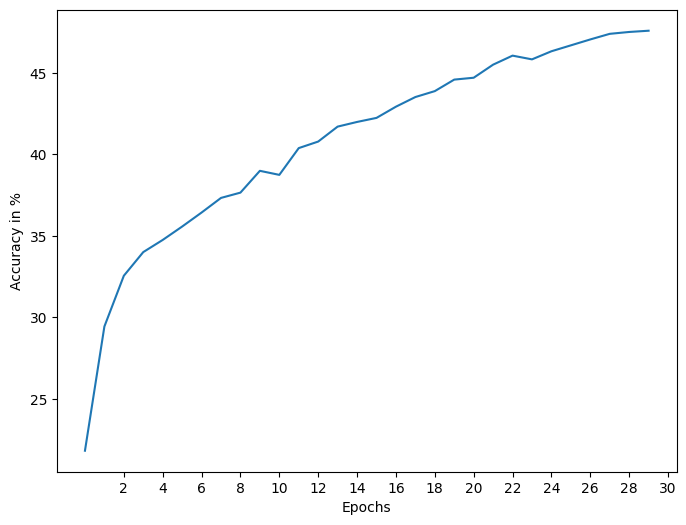

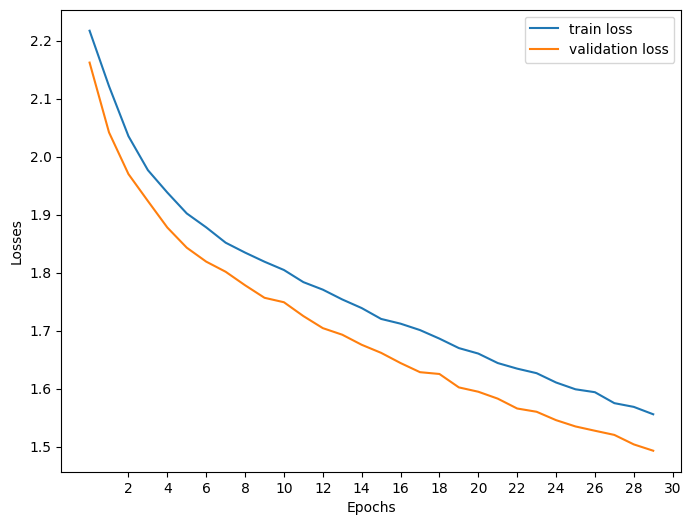

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [00:57<27:56, 57.82s/it]


epoch:   1, loss: 2.22228, valid loss: 2.14836, valid accruacy: 21.796%
Validation loss decreased (inf --> 2.148355). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [01:56<27:17, 58.47s/it]


epoch:   2, loss: 2.13064, valid loss: 2.05763, valid accruacy: 26.743%
Validation loss decreased (2.148355 --> 2.057630). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:54<26:10, 58.16s/it]


epoch:   3, loss: 2.06920, valid loss: 1.99756, valid accruacy: 30.984%
Validation loss decreased (2.057630 --> 1.997564). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:52<25:09, 58.07s/it]


epoch:   4, loss: 2.01146, valid loss: 1.93133, valid accruacy: 32.875%
Validation loss decreased (1.997564 --> 1.931325). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:50<24:14, 58.19s/it]


epoch:   5, loss: 1.94847, valid loss: 1.86718, valid accruacy: 35.148%
Validation loss decreased (1.931325 --> 1.867183). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [05:48<23:14, 58.11s/it]


epoch:   6, loss: 1.90440, valid loss: 1.82625, valid accruacy: 36.275%
Validation loss decreased (1.867183 --> 1.826246). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:47<22:19, 58.23s/it]


epoch:   7, loss: 1.86550, valid loss: 1.78973, valid accruacy: 37.861%
Validation loss decreased (1.826246 --> 1.789727). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:45<21:21, 58.26s/it]


epoch:   8, loss: 1.83983, valid loss: 1.77040, valid accruacy: 38.606%
Validation loss decreased (1.789727 --> 1.770404). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:44<20:27, 58.46s/it]


epoch:   9, loss: 1.81560, valid loss: 1.74588, valid accruacy: 39.045%
Validation loss decreased (1.770404 --> 1.745878). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:43<19:30, 58.50s/it]


epoch:  10, loss: 1.79557, valid loss: 1.71927, valid accruacy: 40.458%
Validation loss decreased (1.745878 --> 1.719273). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:41<18:30, 58.46s/it]


epoch:  11, loss: 1.77724, valid loss: 1.70366, valid accruacy: 40.840%
Validation loss decreased (1.719273 --> 1.703661). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:40<17:36, 58.68s/it]


epoch:  12, loss: 1.75899, valid loss: 1.69397, valid accruacy: 41.910%
Validation loss decreased (1.703661 --> 1.693966). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:40<16:43, 59.04s/it]


epoch:  13, loss: 1.74463, valid loss: 1.67173, valid accruacy: 42.025%
Validation loss decreased (1.693966 --> 1.671725). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:39<15:44, 59.05s/it]


epoch:  14, loss: 1.72695, valid loss: 1.65231, valid accruacy: 42.254%
Validation loss decreased (1.671725 --> 1.652305). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [14:38<14:44, 58.97s/it]


epoch:  15, loss: 1.70670, valid loss: 1.63951, valid accruacy: 42.770%
Validation loss decreased (1.652305 --> 1.639508). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [15:36<13:43, 58.81s/it]


epoch:  16, loss: 1.69789, valid loss: 1.62529, valid accruacy: 43.152%
Validation loss decreased (1.639508 --> 1.625286). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [16:35<12:44, 58.83s/it]


epoch:  17, loss: 1.68355, valid loss: 1.60668, valid accruacy: 44.336%
Validation loss decreased (1.625286 --> 1.606682). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [17:34<11:45, 58.79s/it]


epoch:  18, loss: 1.66848, valid loss: 1.59802, valid accruacy: 44.470%
Validation loss decreased (1.606682 --> 1.598021). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [18:32<10:45, 58.69s/it]


epoch:  19, loss: 1.65470, valid loss: 1.57913, valid accruacy: 44.947%
Validation loss decreased (1.598021 --> 1.579135). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [19:31<09:46, 58.63s/it]


epoch:  20, loss: 1.64170, valid loss: 1.56657, valid accruacy: 45.673%
Validation loss decreased (1.579135 --> 1.566566). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [20:30<08:48, 58.69s/it]


epoch:  21, loss: 1.62970, valid loss: 1.55020, valid accruacy: 45.482%
Validation loss decreased (1.566566 --> 1.550204). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [21:27<07:46, 58.36s/it]


epoch:  22, loss: 1.61406, valid loss: 1.53706, valid accruacy: 46.686%
Validation loss decreased (1.550204 --> 1.537062). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [22:25<06:48, 58.30s/it]


epoch:  23, loss: 1.59996, valid loss: 1.52269, valid accruacy: 46.972%
Validation loss decreased (1.537062 --> 1.522691). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [23:24<05:49, 58.31s/it]


epoch:  24, loss: 1.58948, valid loss: 1.50945, valid accruacy: 46.934%
Validation loss decreased (1.522691 --> 1.509453). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [24:22<04:51, 58.33s/it]


epoch:  25, loss: 1.57554, valid loss: 1.49267, valid accruacy: 47.526%
Validation loss decreased (1.509453 --> 1.492665). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [25:20<03:52, 58.20s/it]


epoch:  26, loss: 1.56026, valid loss: 1.48582, valid accruacy: 48.118%
Validation loss decreased (1.492665 --> 1.485822). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [26:18<02:54, 58.10s/it]


epoch:  27, loss: 1.54944, valid loss: 1.46711, valid accruacy: 49.016%
Validation loss decreased (1.485822 --> 1.467107). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [27:17<01:56, 58.27s/it]


epoch:  28, loss: 1.53416, valid loss: 1.45886, valid accruacy: 49.284%
Validation loss decreased (1.467107 --> 1.458865). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [28:15<00:58, 58.19s/it]


epoch:  29, loss: 1.52660, valid loss: 1.44341, valid accruacy: 49.647%
Validation loss decreased (1.458865 --> 1.443410). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [29:13<00:00, 58.45s/it]



epoch:  30, loss: 1.51233, valid loss: 1.43572, valid accruacy: 49.551%
Validation loss decreased (1.443410 --> 1.435719). Saving model...
Fit time: 1753.6272320747375 s
Test loss: 1.44101	Test accruacy: 50.134%
Saving model


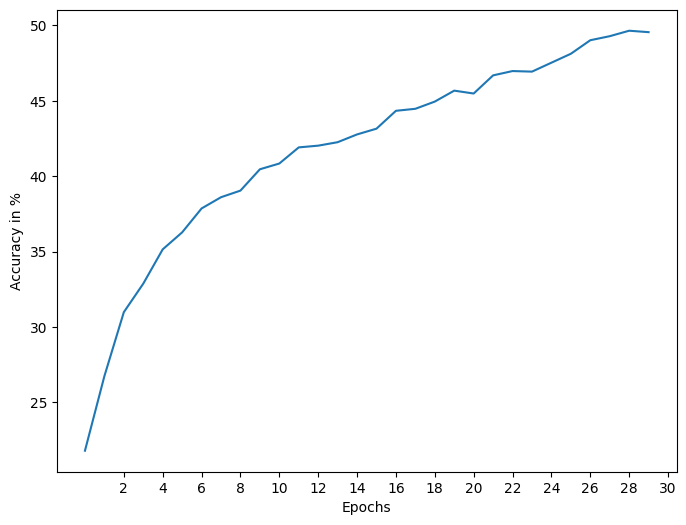

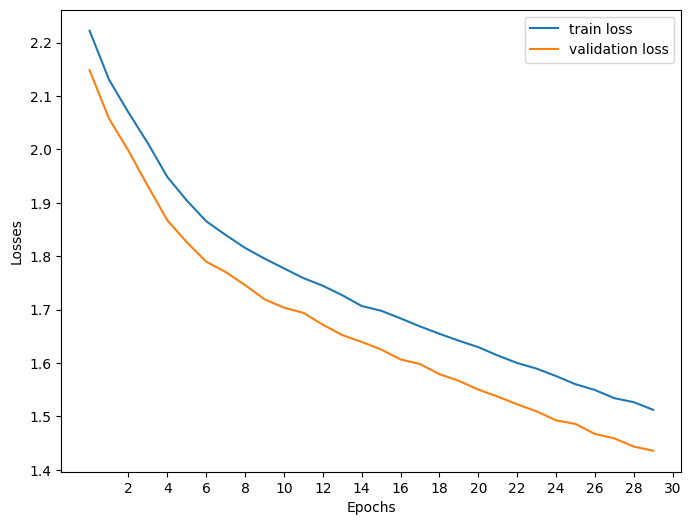

results were saved to csv

Fitting nn model


  3%|██████▌                                                                                                                                                                                            | 1/30 [00:57<27:47, 57.51s/it]


epoch:   1, loss: 2.28894, valid loss: 2.28705, valid accruacy: 18.625%
Validation loss decreased (inf --> 2.287045). Saving model...


  7%|█████████████                                                                                                                                                                                      | 2/30 [01:54<26:35, 56.98s/it]


epoch:   2, loss: 2.28285, valid loss: 2.28170, valid accruacy: 18.625%
Validation loss decreased (2.287045 --> 2.281701). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 3/30 [02:51<25:41, 57.11s/it]


epoch:   3, loss: 2.27756, valid loss: 2.27675, valid accruacy: 18.625%
Validation loss decreased (2.281701 --> 2.276747). Saving model...


 13%|██████████████████████████                                                                                                                                                                         | 4/30 [03:47<24:36, 56.80s/it]


epoch:   4, loss: 2.27198, valid loss: 2.27213, valid accruacy: 18.625%
Validation loss decreased (2.276747 --> 2.272125). Saving model...


 17%|████████████████████████████████▌                                                                                                                                                                  | 5/30 [04:45<23:52, 57.30s/it]


epoch:   5, loss: 2.26731, valid loss: 2.26785, valid accruacy: 18.625%
Validation loss decreased (2.272125 --> 2.267845). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 6/30 [05:43<22:55, 57.32s/it]


epoch:   6, loss: 2.26295, valid loss: 2.26386, valid accruacy: 18.625%
Validation loss decreased (2.267845 --> 2.263856). Saving model...


 23%|█████████████████████████████████████████████▌                                                                                                                                                     | 7/30 [06:40<21:59, 57.39s/it]


epoch:   7, loss: 2.25866, valid loss: 2.26012, valid accruacy: 18.625%
Validation loss decreased (2.263856 --> 2.260119). Saving model...


 27%|████████████████████████████████████████████████████                                                                                                                                               | 8/30 [07:39<21:08, 57.67s/it]


epoch:   8, loss: 2.25459, valid loss: 2.25667, valid accruacy: 18.625%
Validation loss decreased (2.260119 --> 2.256667). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 9/30 [08:35<20:04, 57.35s/it]


epoch:   9, loss: 2.25085, valid loss: 2.25348, valid accruacy: 18.625%
Validation loss decreased (2.256667 --> 2.253479). Saving model...


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                 | 10/30 [09:33<19:07, 57.39s/it]


epoch:  10, loss: 2.24757, valid loss: 2.25053, valid accruacy: 18.625%
Validation loss decreased (2.253479 --> 2.250533). Saving model...


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                          | 11/30 [10:30<18:12, 57.48s/it]


epoch:  11, loss: 2.24449, valid loss: 2.24779, valid accruacy: 18.625%
Validation loss decreased (2.250533 --> 2.247793). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 12/30 [11:28<17:13, 57.43s/it]


epoch:  12, loss: 2.24159, valid loss: 2.24528, valid accruacy: 18.625%
Validation loss decreased (2.247793 --> 2.245283). Saving model...


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 13/30 [12:25<16:17, 57.49s/it]


epoch:  13, loss: 2.23871, valid loss: 2.24294, valid accruacy: 18.625%
Validation loss decreased (2.245283 --> 2.242942). Saving model...


 47%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 14/30 [13:24<15:26, 57.94s/it]


epoch:  14, loss: 2.23623, valid loss: 2.24080, valid accruacy: 18.625%
Validation loss decreased (2.242942 --> 2.240803). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 15/30 [14:23<14:34, 58.29s/it]


epoch:  15, loss: 2.23379, valid loss: 2.23880, valid accruacy: 18.625%
Validation loss decreased (2.240803 --> 2.238803). Saving model...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 16/30 [15:23<13:42, 58.73s/it]


epoch:  16, loss: 2.23187, valid loss: 2.23696, valid accruacy: 18.625%
Validation loss decreased (2.238803 --> 2.236962). Saving model...


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 17/30 [16:21<12:39, 58.43s/it]


epoch:  17, loss: 2.22983, valid loss: 2.23529, valid accruacy: 18.625%
Validation loss decreased (2.236962 --> 2.235294). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 18/30 [17:19<11:39, 58.28s/it]


epoch:  18, loss: 2.22794, valid loss: 2.23372, valid accruacy: 18.625%
Validation loss decreased (2.235294 --> 2.233722). Saving model...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 19/30 [18:17<10:42, 58.40s/it]


epoch:  19, loss: 2.22633, valid loss: 2.23228, valid accruacy: 18.625%
Validation loss decreased (2.233722 --> 2.232282). Saving model...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 20/30 [19:17<09:47, 58.76s/it]


epoch:  20, loss: 2.22457, valid loss: 2.23094, valid accruacy: 18.625%
Validation loss decreased (2.232282 --> 2.230944). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 21/30 [20:16<08:50, 58.92s/it]


epoch:  21, loss: 2.22313, valid loss: 2.22974, valid accruacy: 18.625%
Validation loss decreased (2.230944 --> 2.229741). Saving model...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 22/30 [21:15<07:51, 58.91s/it]


epoch:  22, loss: 2.22184, valid loss: 2.22861, valid accruacy: 18.625%
Validation loss decreased (2.229741 --> 2.228613). Saving model...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 23/30 [22:14<06:52, 58.98s/it]


epoch:  23, loss: 2.22043, valid loss: 2.22758, valid accruacy: 18.625%
Validation loss decreased (2.228613 --> 2.227584). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 24/30 [23:13<05:53, 58.95s/it]


epoch:  24, loss: 2.21927, valid loss: 2.22664, valid accruacy: 18.625%
Validation loss decreased (2.227584 --> 2.226636). Saving model...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 25/30 [24:13<04:55, 59.08s/it]


epoch:  25, loss: 2.21828, valid loss: 2.22577, valid accruacy: 18.625%
Validation loss decreased (2.226636 --> 2.225774). Saving model...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 26/30 [25:12<03:56, 59.15s/it]


epoch:  26, loss: 2.21720, valid loss: 2.22497, valid accruacy: 18.625%
Validation loss decreased (2.225774 --> 2.224966). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 27/30 [26:12<02:58, 59.39s/it]


epoch:  27, loss: 2.21619, valid loss: 2.22423, valid accruacy: 18.625%
Validation loss decreased (2.224966 --> 2.224234). Saving model...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 28/30 [27:10<01:57, 58.95s/it]


epoch:  28, loss: 2.21548, valid loss: 2.22356, valid accruacy: 18.625%
Validation loss decreased (2.224234 --> 2.223562). Saving model...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 29/30 [28:07<00:58, 58.36s/it]


epoch:  29, loss: 2.21462, valid loss: 2.22294, valid accruacy: 18.625%
Validation loss decreased (2.223562 --> 2.222939). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [29:04<00:00, 58.15s/it]


epoch:  30, loss: 2.21372, valid loss: 2.22237, valid accruacy: 18.625%
Validation loss decreased (2.222939 --> 2.222368). Saving model...
Fit time: 1744.5721154212952 s


Test loss: 2.22182	Test accruacy: 18.328%
Saving model


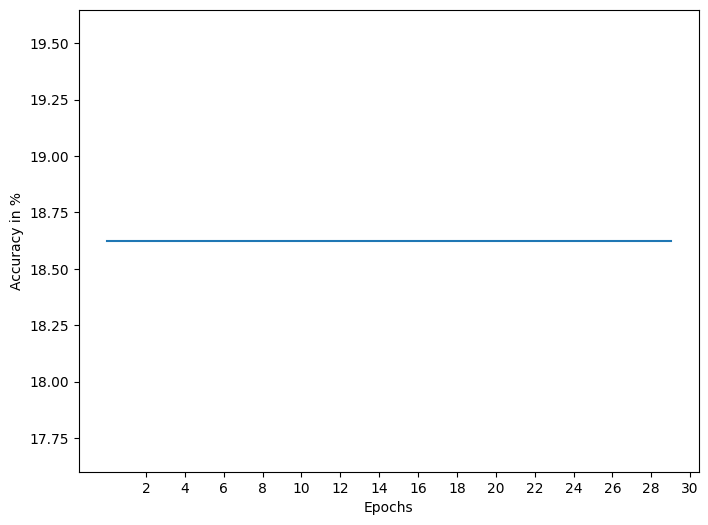

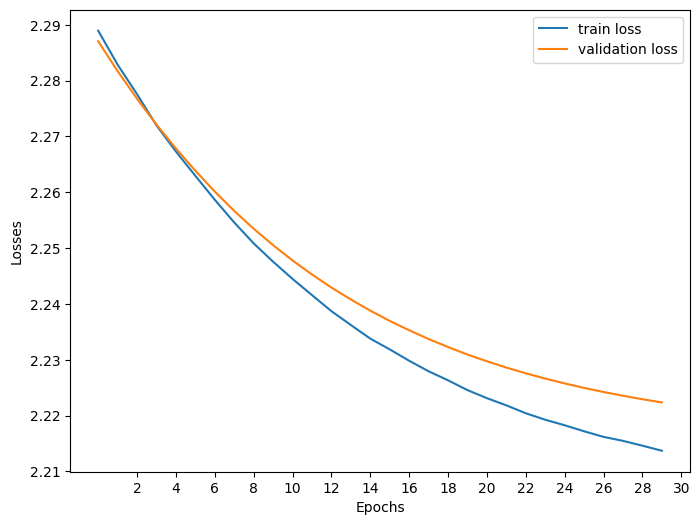

results were saved to csv


In [20]:
df_grid_v1 = grid_search(params_grid)

In [21]:
df_grid_v1

batch_size      lr epochs                   activation_fn optimizer  \
0          32  0.0010     20  LeakyReLU(negative_slope=0.01)     AdamW   
1          32  0.0010     20  LeakyReLU(negative_slope=0.01)      Adam   
2          32  0.0010     20  LeakyReLU(negative_slope=0.01)       SGD   
3          32  0.0001     20  LeakyReLU(negative_slope=0.01)     AdamW   
4          32  0.0001     20  LeakyReLU(negative_slope=0.01)      Adam   
5          32  0.0001     20  LeakyReLU(negative_slope=0.01)       SGD   
6          32  0.0010     30  LeakyReLU(negative_slope=0.01)     AdamW   
7          32  0.0010     30  LeakyReLU(negative_slope=0.01)      Adam   
8          32  0.0010     30  LeakyReLU(negative_slope=0.01)       SGD   
9          32  0.0001     30  LeakyReLU(negative_slope=0.01)     AdamW   
10         32  0.0001     30  LeakyReLU(negative_slope=0.01)      Adam   
11         32  0.0001     30  LeakyReLU(negative_slope=0.01)       SGD   
12         64  0.0010     20  LeakyReLU(negative_slope=0.01)     AdamW   
13         64  0.0010     20  LeakyReLU(negative_slope=0.01)      Adam   
14         64  0.0010     20  LeakyReLU(negative_slope=0.01)       SGD   
15         64  0.0001     20  LeakyReLU(negative_slope=0.01)     AdamW   
16         64  0.0001     20  LeakyReLU(negative_slope=0.01)      Adam   
17         64  0.0001     20  LeakyReLU(negative_slope=0.01)       SGD   
18         64  0.0010     30  LeakyReLU(negative_slope=0.01)     AdamW   
19         64  0.0010     30  LeakyReLU(negative_slope=0.01)      Adam   
20         64  0.0010     30  LeakyReLU(negative_slope=0.01)       SGD   
21         64  0.0001     30  LeakyReLU(negative_slope=0.01)     AdamW   
22         64  0.0001     30  LeakyReLU(negative_slope=0.01)      Adam   
23         64  0.0001     30  LeakyReLU(negative_slope=0.01)       SGD   
24         32  0.0010     20        GELU(approximate='none')     AdamW   
25         32  0.0010     20        GELU(approximate='none')      Adam   
26         32  0.0010     20        GELU(approximate='none')       SGD   
27         32  0.0001     20        GELU(approximate='none')     AdamW   
28         32  0.0001     20        GELU(approximate='none')      Adam   
29         32  0.0001     20        GELU(approximate='none')       SGD   
30         32  0.0010     30        GELU(approximate='none')     AdamW   
31         32  0.0010     30        GELU(approximate='none')      Adam   
32         32  0.0010     30        GELU(approximate='none')       SGD   
33         32  0.0001     30        GELU(approximate='none')     AdamW   
34         32  0.0001     30        GELU(approximate='none')      Adam   
35         32  0.0001     30        GELU(approximate='none')       SGD   
36         64  0.0010     20        GELU(approximate='none')     AdamW   
37         64  0.0010     20        GELU(approximate='none')      Adam   
38         64  0.0010     20        GELU(approximate='none')       SGD   
39         64  0.0001     20        GELU(approximate='none')     AdamW   
40         64  0.0001     20        GELU(approximate='none')      Adam   
41         64  0.0001     20        GELU(approximate='none')       SGD   
42         64  0.0010     30        GELU(approximate='none')     AdamW   
43         64  0.0010     30        GELU(approximate='none')      Adam   
44         64  0.0010     30        GELU(approximate='none')       SGD   
45         64  0.0001     30        GELU(approximate='none')     AdamW   
46         64  0.0001     30        GELU(approximate='none')      Adam   
47         64  0.0001     30        GELU(approximate='none')       SGD   

                                           losses_arr  test_loss  \
0   [(2.0676891619772086, 1.8396680436822042, 36.1...   0.848165   
1   [(2.041085067712594, 1.8623824600503915, 34.04...   0.781317   
2   [(2.2477434995815178, 2.1991226431747335, 18.7...   1.551400   
3   [(2.1992256000747785, 2.1221905284305924, 23.9...   1.524626   
4   [(2.1983182869764173, 2.12018771

In [24]:
df_res = df_grid_v1.sort_values(by='test_accuracy', ascending=False)

In [25]:
df_res['valid_accuracy'] = 1

In [29]:
# df_res

In [28]:
for i in range(df_res.shape[0]):
    df_res.iloc[i,9] = df_res.iloc[i,5][-1][-1]
df_res.to_csv('lab4/models/results_v1.csv', sep=',')

In [32]:
df_res.head()

batch_size     lr epochs             activation_fn optimizer  \
31         32  0.001     30  GELU(approximate='none')      Adam   
43         64  0.001     30  GELU(approximate='none')      Adam   
30         32  0.001     30  GELU(approximate='none')     AdamW   
42         64  0.001     30  GELU(approximate='none')     AdamW   
37         64  0.001     20  GELU(approximate='none')      Adam   

                                           losses_arr  test_loss  \
31  [(1.9687852683008775, 1.736259270966793, 39.21...   0.583627   
43  [(2.020007651616574, 1.8072980990951815, 36.48...   0.639281   
30  [(1.9990270878868572, 1.7443869105952061, 40.0...   0.655752   
42  [(2.0186632107582456, 1.8001297991733496, 35.5...   0.667228   
37  [(2.0218555784485677, 1.825202218076675, 35.83...   0.658761   

    test_accuracy     model  valid_accuracy  
31      84.879725  model_31       83.075454  
43      83.543337  model_43       83.266476  
30      83.314242  model_30       83.801337  
42      82.016037  model_42       83.113658  
37      80.565101  model_37       78.911175

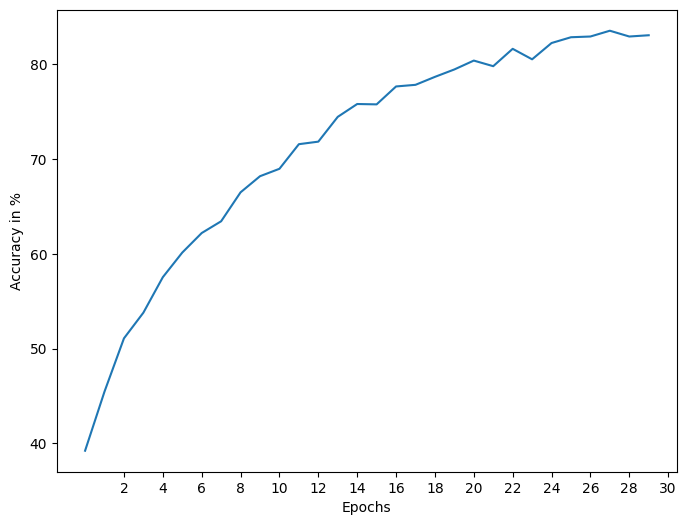

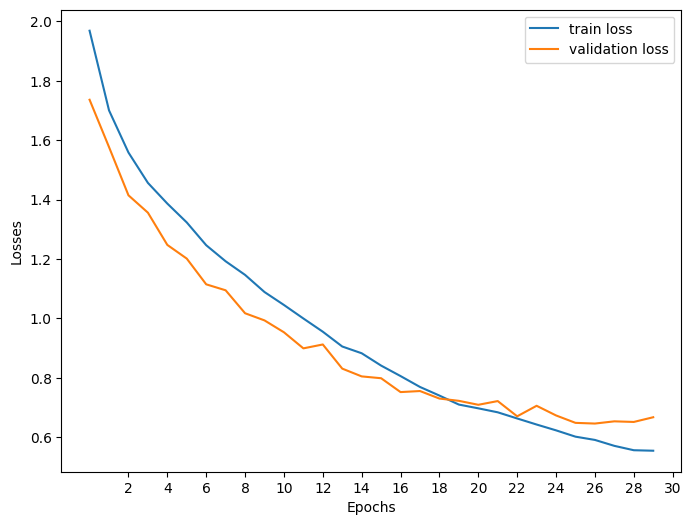

In [31]:
training_plots(df_res.iloc[0,5])